In [50]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.windows import Window
from glob import glob
import matplotlib.pyplot as plt
from rasterio.warp import transform_bounds
from rasterio.merge import merge
from affine import Affine
import numpy as np
from scipy.ndimage import rotate
from sklearn.decomposition import PCA

✅ Extracted 4437 patch pairs.


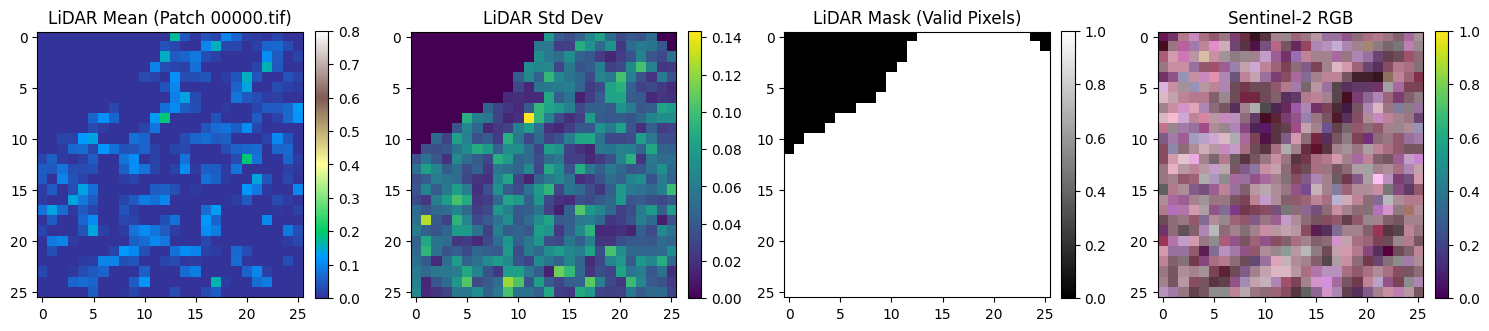

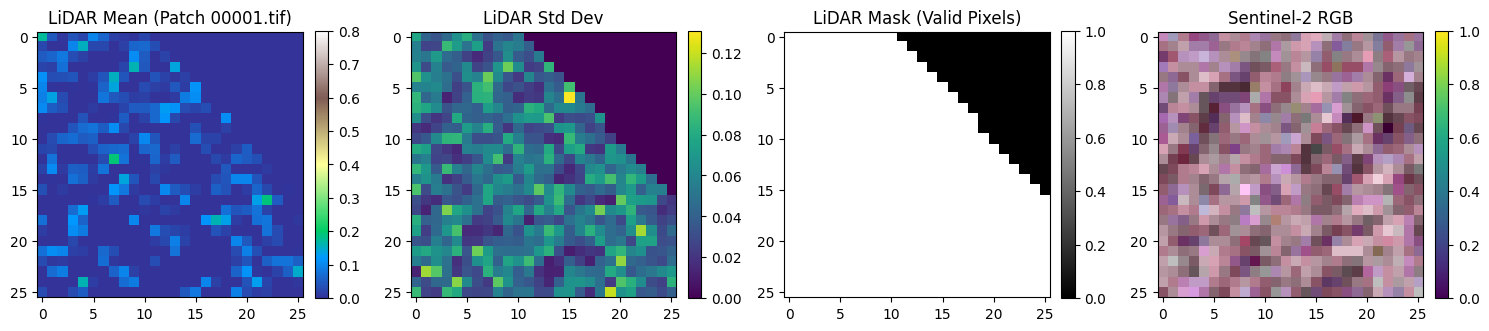

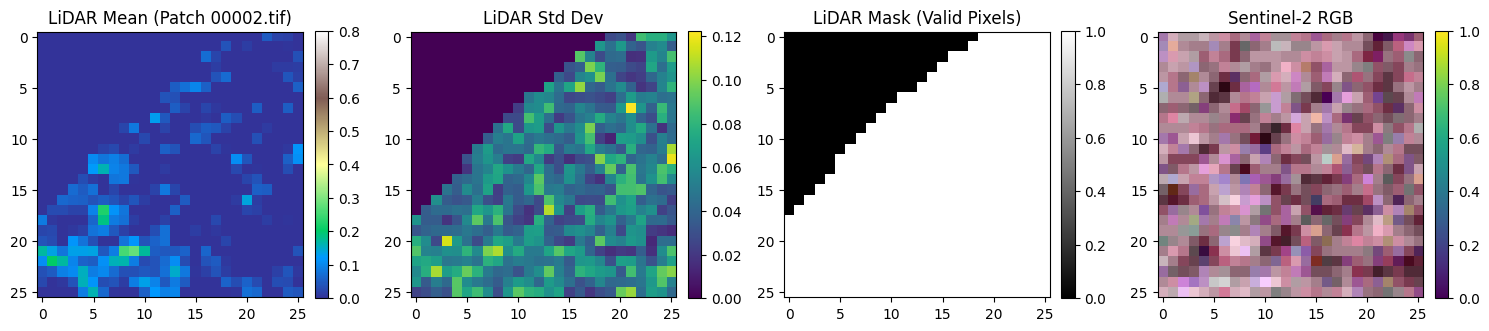

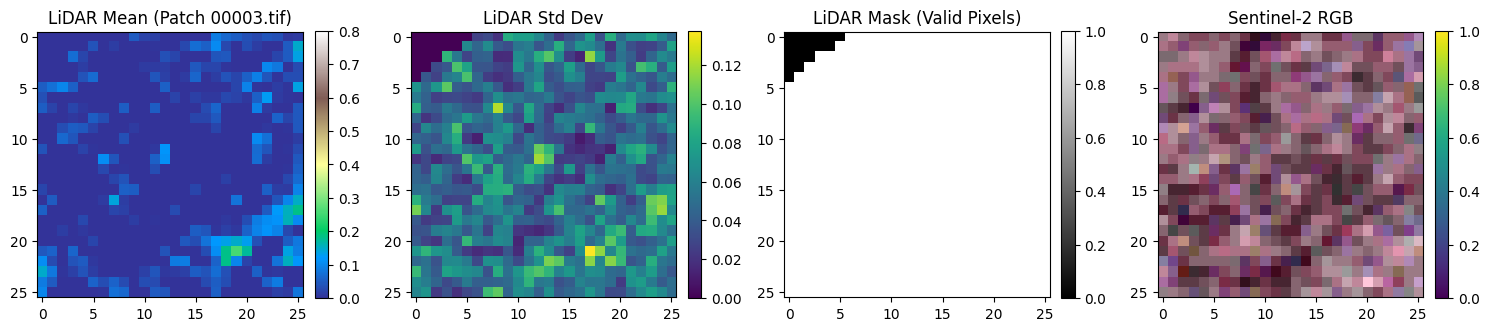

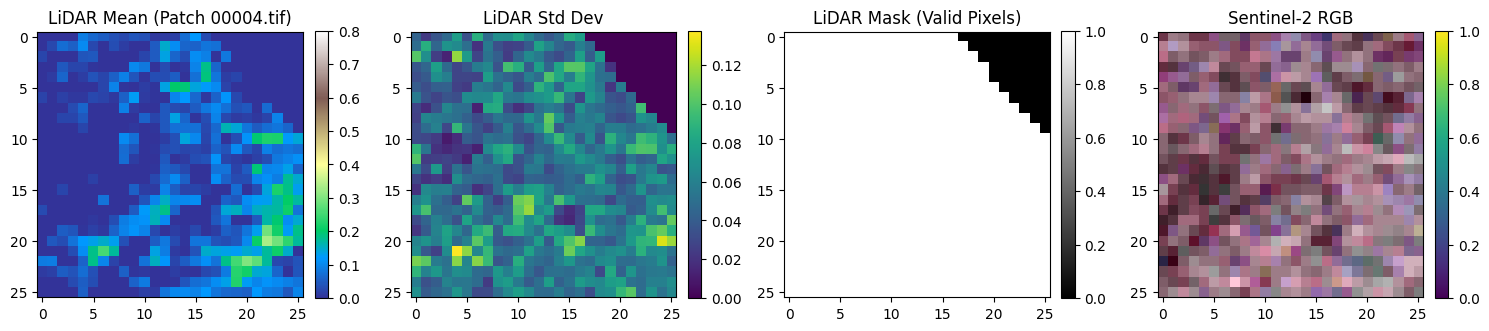

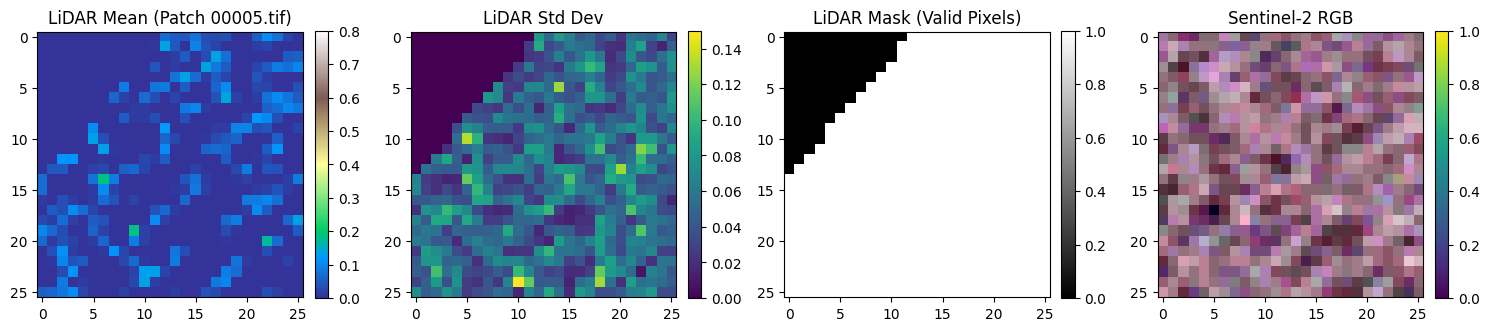

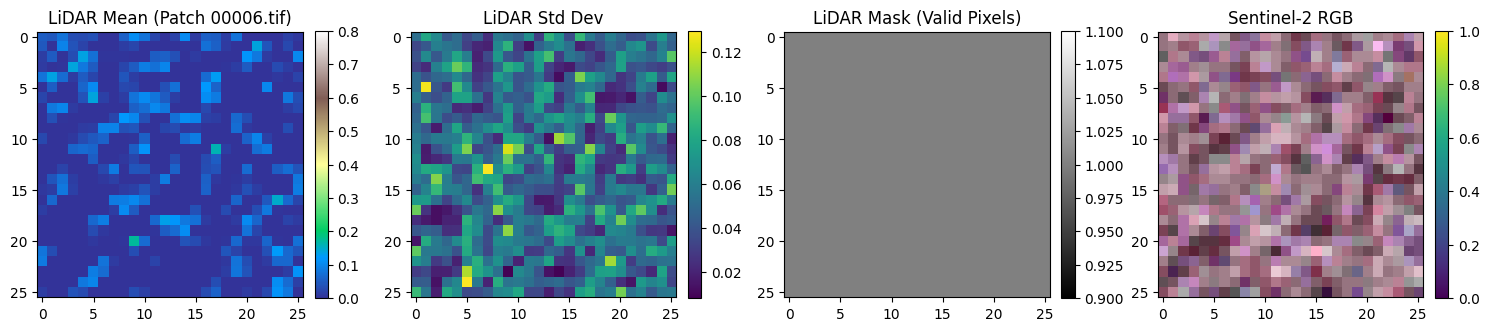

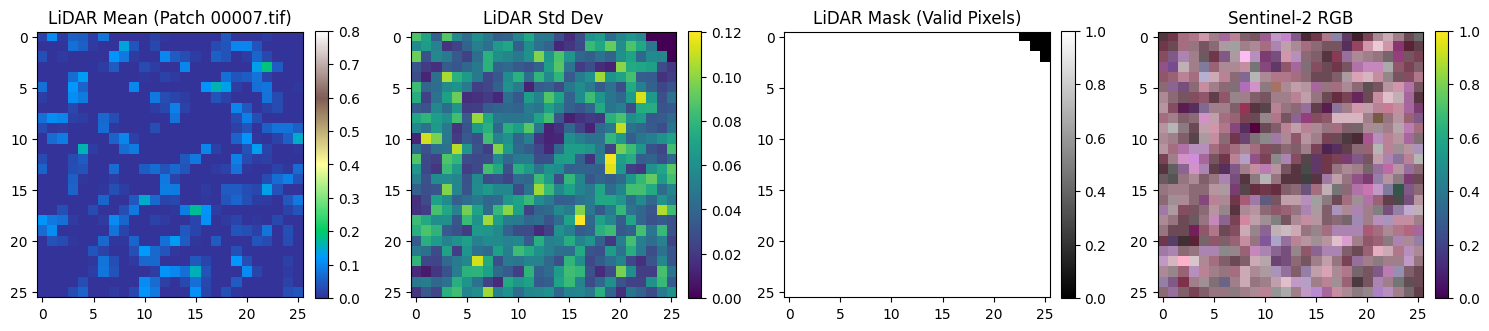

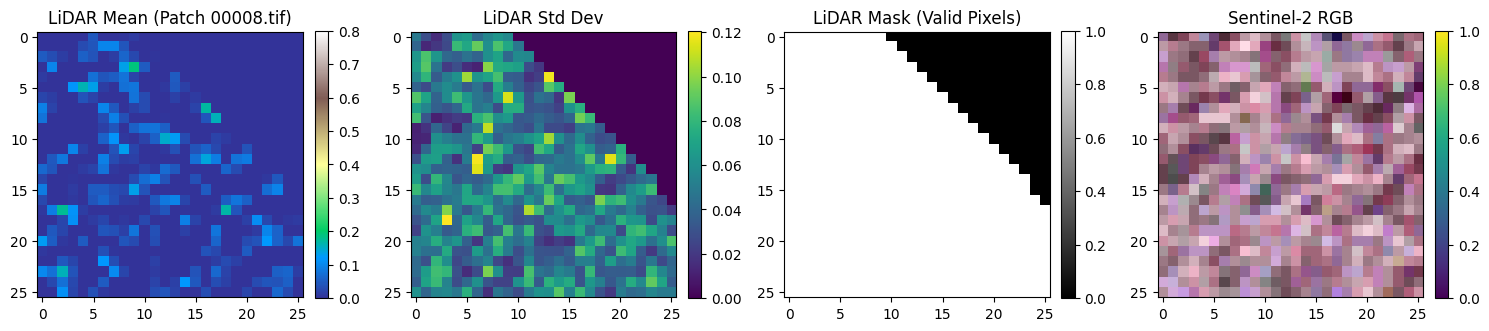

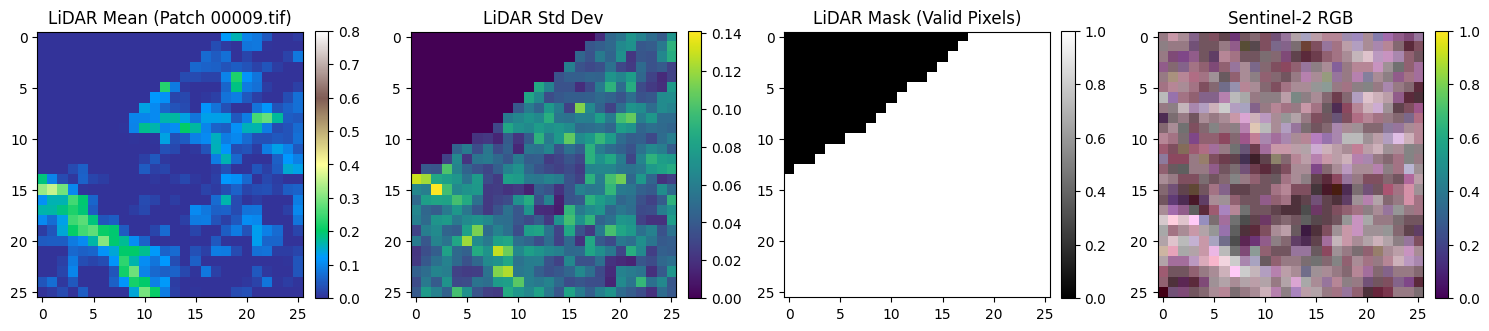

In [58]:
# --------------------------
# CONFIGURATION
# --------------------------
lidar_dir = "/Users/tessacannon/Documents/UCL/Dissertation/tifs"
safe_dir = "/Users/tessacannon/Documents/UCL/Dissertation/sentinel_downloads/S2A_MSIL2A_20240422T173911_N0510_R098_T17XNA_20240423T004122.SAFE/GRANULE"
out_lidar_dir = "lidar_patches"
out_s2_dir = "s2_patches"
patch_size = 26  # 10m resolution (260m spatial extent)

os.makedirs(out_lidar_dir, exist_ok=True)
os.makedirs(out_s2_dir, exist_ok=True)

# --------------------------
# STEP 1: STACK SENTINEL-2 BANDS
# --------------------------
def stack_sentinel_bands(safe_granule_path):
    band_files = {}
    for band in ["B02", "B03", "B04", "B08"]:  # Blue, Green, Red, NIR
        pattern = os.path.join(safe_granule_path, "**", f"*_{band}_10m.jp2")
        matches = glob(pattern, recursive=True)
        if not matches:
            raise FileNotFoundError(f"Could not find band {band}.")
        band_files[band] = matches[0]

    band_stack = []
    for band in ["B04", "B03", "B02", "B08"]:  # R, G, B, NIR
        with rasterio.open(band_files[band]) as src:
            band_stack.append(src.read(1))
            meta = src.meta.copy()
    stacked = np.stack(band_stack, axis=0)
    return stacked, meta

sentinel_stack, sentinel_meta = stack_sentinel_bands(safe_dir)
sentinel_transform = sentinel_meta["transform"]
sentinel_crs = sentinel_meta["crs"]

# --------------------------
# STEP 2: MERGE & DOWNSCALE LIDAR
# --------------------------
def merge_lidar_files(lidar_files):
    srcs = [rasterio.open(fp) for fp in lidar_files]
    mosaic, transform = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": transform})
    for src in srcs:
        src.close()
    return mosaic[0], transform, meta

def downscale_lidar_mean_std(lidar_array, scale=10):
    lidar_array = np.where(lidar_array == -9999, np.nan, lidar_array)
    h, w = lidar_array.shape
    h_ds, w_ds = h // scale, w // scale
    lidar_array = lidar_array[:h_ds * scale, :w_ds * scale]

    reshaped = lidar_array.reshape(h_ds, scale, w_ds, scale).transpose(0, 2, 1, 3)
    mean = reshaped.mean(axis=(2, 3))
    std = reshaped.std(axis=(2, 3))
    return np.stack([mean, std], axis=0)

# --------------------------
# STEP 3: PATCH EXTRACTION
# --------------------------
def extract_lidar_s2_pairs_from_merged(
    lidar_array, lidar_transform, lidar_crs, 
    sentinel_stack, sentinel_transform, sentinel_crs, sentinel_meta, 
    patch_size, out_lidar_dir, out_s2_dir, start_idx=0, stride=None
):
    """
    Extract paired patches from downscaled 2-channel LiDAR and a Sentinel-2 stack.
    - `lidar_array` is expected to be shape (2, H, W) with [0]=mean, [1]=std.
    - LiDAR patches saved with 2 bands (mean, std).
    """
    if stride is None:
        stride = patch_size  # no overlap

    count = 0
    _, height, width = lidar_array.shape

    for row in range(0, height - patch_size + 1, stride):
        for col in range(0, width - patch_size + 1, stride):
            patch_mean = lidar_array[0, row:row+patch_size, col:col+patch_size]
            patch_std = lidar_array[1, row:row+patch_size, col:col+patch_size]

            # Create mask: valid where neither mean nor std is NaN
            valid_mask = ~np.isnan(patch_mean) & ~np.isnan(patch_std)
            mask_channel = valid_mask.astype(np.uint8)

            # Fill NaNs with zero in the patch
            patch_mean = np.nan_to_num(patch_mean, nan=0.0)
            patch_std = np.nan_to_num(patch_std, nan=0.0)

            # Combine into 3-channel patch: [mean, std, mask]
            patch = np.stack([patch_mean, patch_std, mask_channel], axis=0)

            # Skip if too much missing data
            if mask_channel.mean() < 0.7:  # i.e., <70% valid
                continue

            window = Window(col, row, patch_size, patch_size)
            bounds = rasterio.windows.bounds(window, lidar_transform)

            try:
                # Convert bounds from LiDAR CRS to Sentinel-2 CRS
                s2_bounds = transform_bounds(lidar_crs, sentinel_crs, *bounds)
                s2_window = from_bounds(*s2_bounds, sentinel_transform)
                s2_row = int(s2_window.row_off)
                s2_col = int(s2_window.col_off)
                s2_patch = sentinel_stack[:, s2_row:s2_row + patch_size, s2_col:s2_col + patch_size]

                if s2_patch.shape[1:] != (patch_size, patch_size):
                    continue
            except Exception:
                continue

            # Save patches
            patch_id = f"{start_idx + count:05d}"
            lidar_out = os.path.join(out_lidar_dir, f"lidar_patch_{patch_id}.tif")
            s2_out = os.path.join(out_s2_dir, f"s2_patch_{patch_id}.tif")

            # Write LiDAR patch (2 bands)
            lidar_meta = {
                "driver": "GTiff",
                "height": patch_size,
                "width": patch_size,
                "count": 3,  # now includes mask
                "dtype": patch.dtype,
                "crs": lidar_crs,
                "transform": rasterio.windows.transform(window, lidar_transform)
            }
            with rasterio.open(lidar_out, 'w', **lidar_meta) as dst:
                dst.write(patch)

            # Write Sentinel-2 patch
            s2_meta = sentinel_meta.copy()
            s2_meta.update({
                "count": sentinel_stack.shape[0],
                "height": patch_size,
                "width": patch_size,
                "transform": rasterio.windows.transform(s2_window, sentinel_transform)
            })
            with rasterio.open(s2_out, 'w', **s2_meta) as dst:
                dst.write(s2_patch)

            count += 1

    return count

# --------------------------
# EXECUTION
# --------------------------
lidar_files = glob(os.path.join(lidar_dir, "*1m.tif"))
lidar_array, lidar_transform, lidar_meta = merge_lidar_files(lidar_files)
scale = 10
lidar_array = downscale_lidar_mean_std(lidar_array, scale=scale)

# Update transform for 10m resolution
lidar_transform = Affine(
    lidar_transform.a * scale, lidar_transform.b, lidar_transform.c,
    lidar_transform.d, lidar_transform.e * scale, lidar_transform.f
)

total = extract_lidar_s2_pairs_from_merged(
    lidar_array=lidar_array,
    lidar_transform=lidar_transform,
    lidar_crs=lidar_meta["crs"],
    sentinel_stack=sentinel_stack,
    sentinel_transform=sentinel_transform,
    sentinel_crs=sentinel_crs,
    sentinel_meta=sentinel_meta,
    patch_size=patch_size,
    out_lidar_dir=out_lidar_dir,
    out_s2_dir=out_s2_dir,
    start_idx=0,
    stride=13  # 50% overlap
)

print(f"✅ Extracted {total} patch pairs.")

# --------------------------
# STEP 4: VISUALIZATION (LiDAR Mean, LiDAR Std, S2 RGB)
# --------------------------
sample_ids = sorted(glob(os.path.join(out_lidar_dir, "*.tif")))[0:10]

def normalize(img):
    return np.clip((img - np.min(img)) / (np.max(img) - np.min(img)), 0, 1)

for lidar_path in sample_ids:
    patch_id = os.path.basename(lidar_path).split("_")[-1]
    s2_path = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")

    with rasterio.open(lidar_path) as src:
        lidar_mean = src.read(1)
        lidar_std = src.read(2)
        lidar_mask = src.read(3)  # Mask channel

    with rasterio.open(s2_path) as src:
        s2_rgb = src.read([1, 2, 3])

    lidar_mean = np.where(lidar_mean < 0, 0, lidar_mean)
    s2_rgb = np.moveaxis(s2_rgb, 0, -1)
    s2_rgb_norm = normalize(s2_rgb)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # LiDAR Mean
    im0 = axes[0].imshow(lidar_mean, cmap="terrain")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    im0.set_clim(0, 0.8)
    axes[0].set_title(f"LiDAR Mean (Patch {patch_id})")

    # LiDAR Std
    im1 = axes[1].imshow(lidar_std, cmap="viridis")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].set_title("LiDAR Std Dev")

    # LiDAR Mask
    im2 = axes[2].imshow(lidar_mask, cmap="gray")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    axes[2].set_title("LiDAR Mask (Valid Pixels)")

    # Sentinel-2 RGB
    axes[3].imshow(s2_rgb_norm)
    axes[3].set_title("Sentinel-2 RGB")
    plt.colorbar(axes[3].imshow(s2_rgb_norm), ax=axes[3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()


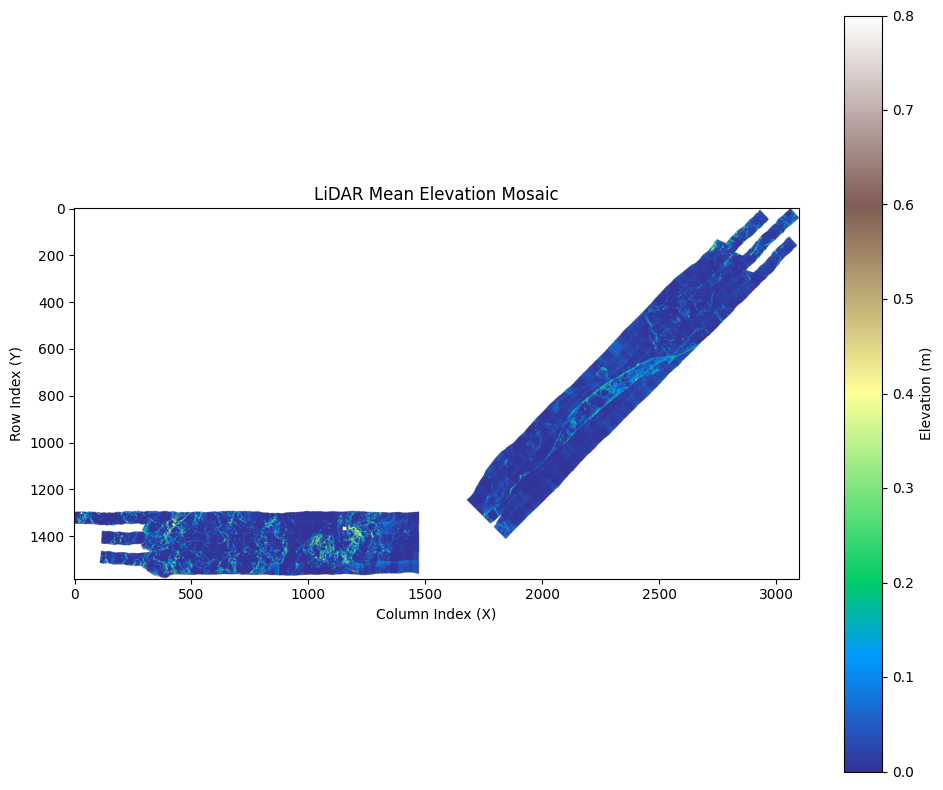

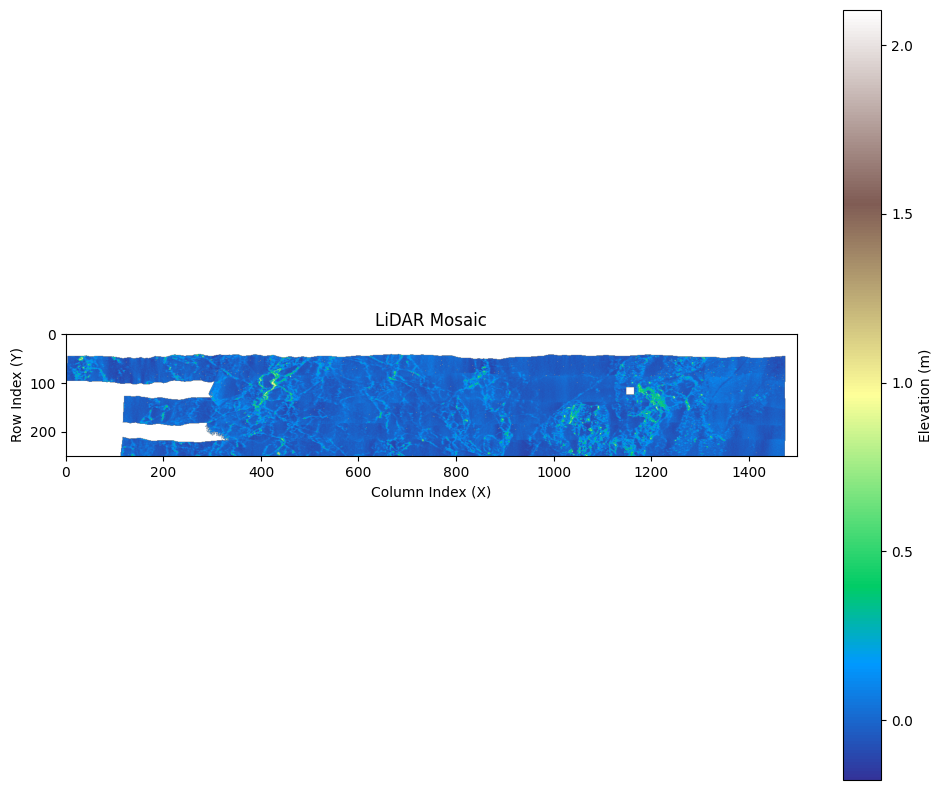

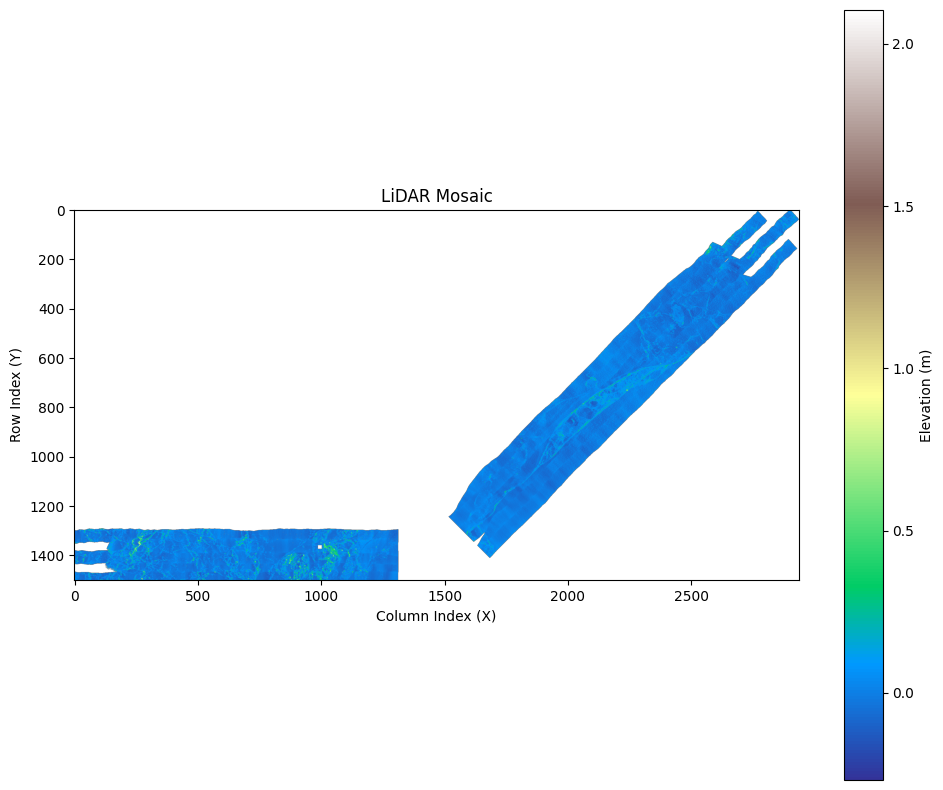

In [ ]:
def plot_lidar_mosaic(lidar_array, title="LiDAR Mosaic", vmin=None, vmax=None):
    """
    Plot the LiDAR mean elevation mosaic with axis labels and a colorbar.

    Parameters:
    - lidar_array: np.ndarray of shape (H, W) or (2, H, W) if mean/std
    - title: plot title
    - vmin, vmax: value range for color normalization (optional)
    """
    if lidar_array.ndim == 3 and lidar_array.shape[0] == 2:
        lidar_array = lidar_array[0]  # show mean by default

    lidar_array = np.where(np.isnan(lidar_array), np.nan, lidar_array)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(lidar_array, cmap="terrain", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Elevation (m)")
    plt.title(title)
    plt.xlabel("Column Index (X)")
    plt.ylabel("Row Index (Y)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot the LiDAR mosaic
plot_lidar_mosaic(lidar_array, title="LiDAR Mean Elevation Mosaic", vmin=0, vmax=0.8)
plot_lidar_mosaic(lidar_array[:, 1250:1500, 0:1500])
plot_lidar_mosaic(lidar_array[:, 0:1500, 160:3200])

Suggested rotation angle: 44.73 degrees


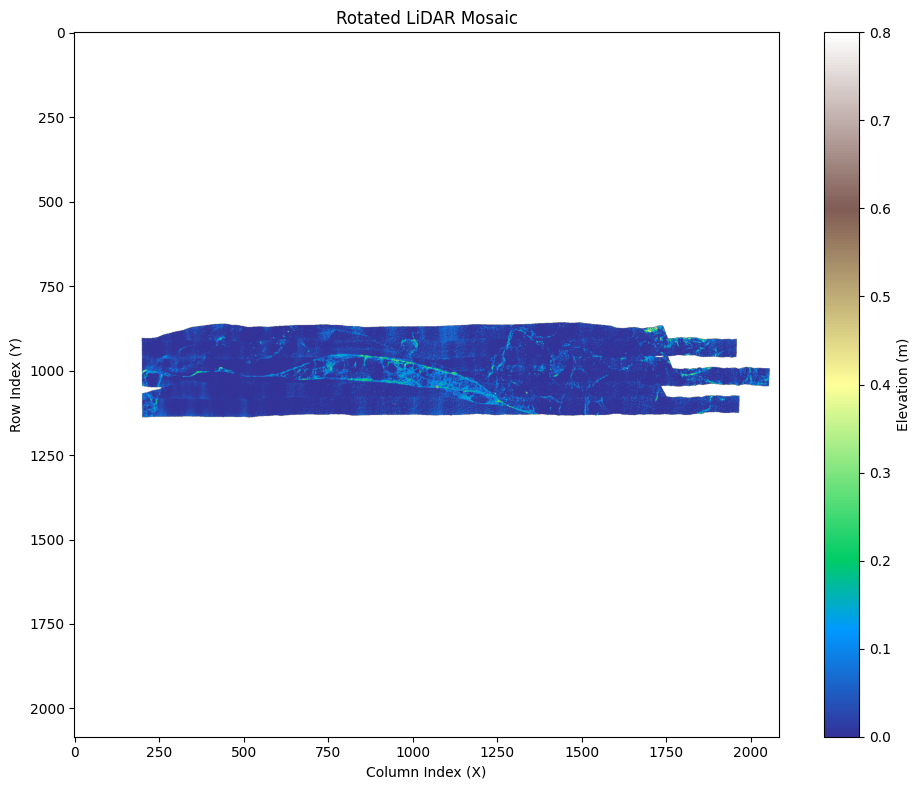

In [53]:
# Extract the second swath
region = lidar_array[:, 0:1500, 1650:3200]
mask = ~np.isnan(region[0])  # use mean channel

# Get Y (rows) and X (cols) of valid pixels in this region
y_coords, x_coords = np.where(mask)

# Convert to real coordinates (optional, if needed): pixel grid is fine for angle

coords = np.stack([x_coords, y_coords], axis=1)  # shape (N, 2)
pca = PCA(n_components=2)
pca.fit(coords)

# First principal component vector
direction_vector = pca.components_[0]  # e.g., [dx, dy]

angle_rad = np.arctan2(direction_vector[1], direction_vector[0])  # dy, dx
angle_deg = np.degrees(angle_rad)

print(f"Suggested rotation angle: {-angle_deg:.2f} degrees")

rotated_lidar = rotate(lidar_array[:, 0:1500, 1650:3200], angle=angle_deg, axes=(1, 2), reshape=True, order=1, mode='constant', cval=np.nan)
plot_lidar_mosaic(rotated_lidar, title="Rotated LiDAR Mosaic", vmin=0, vmax=0.8)


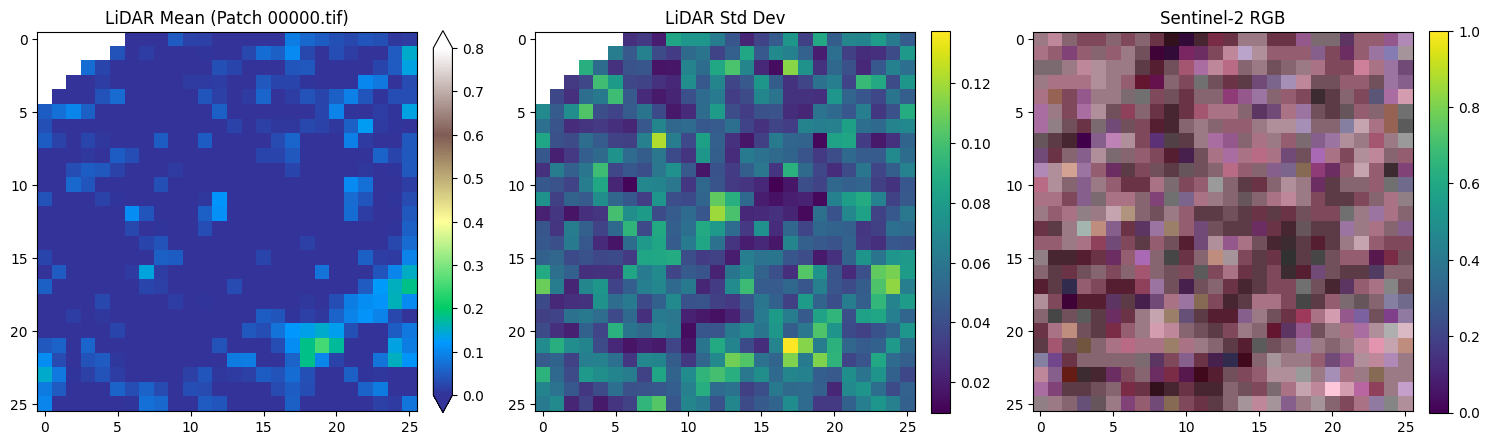

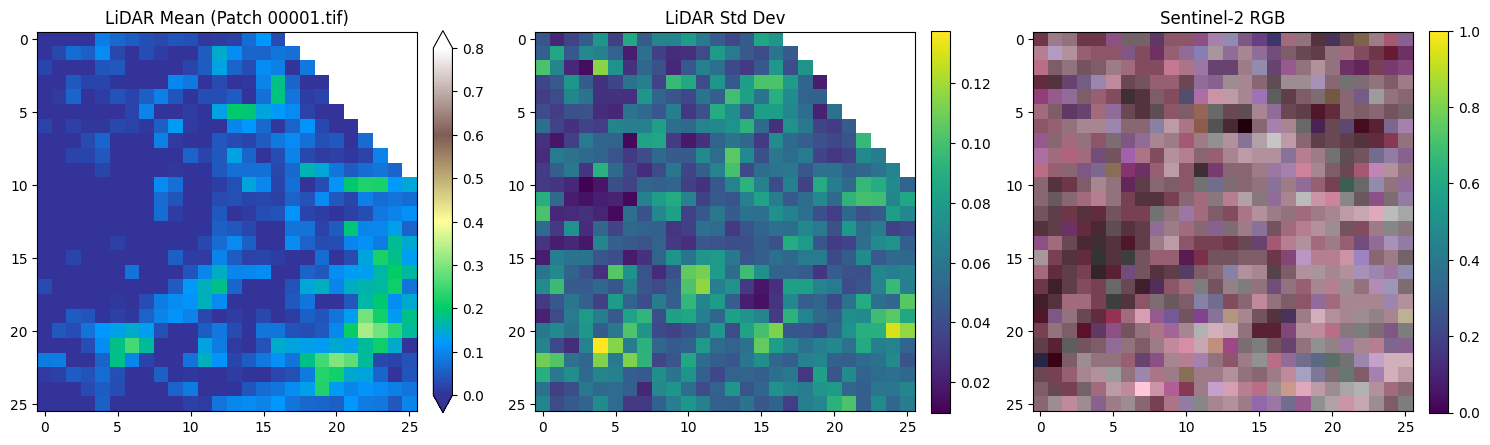

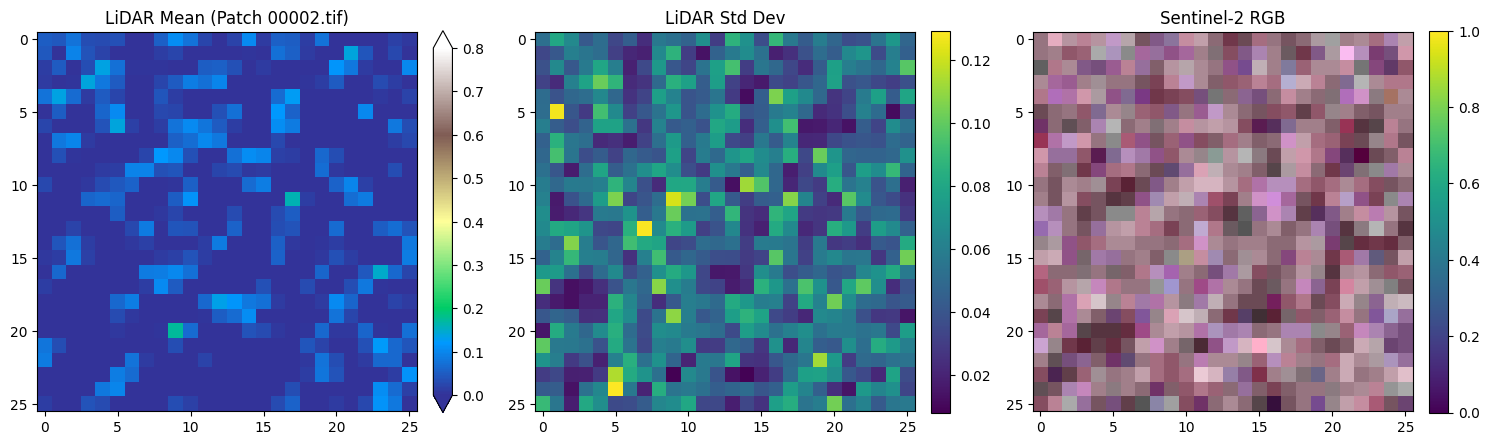

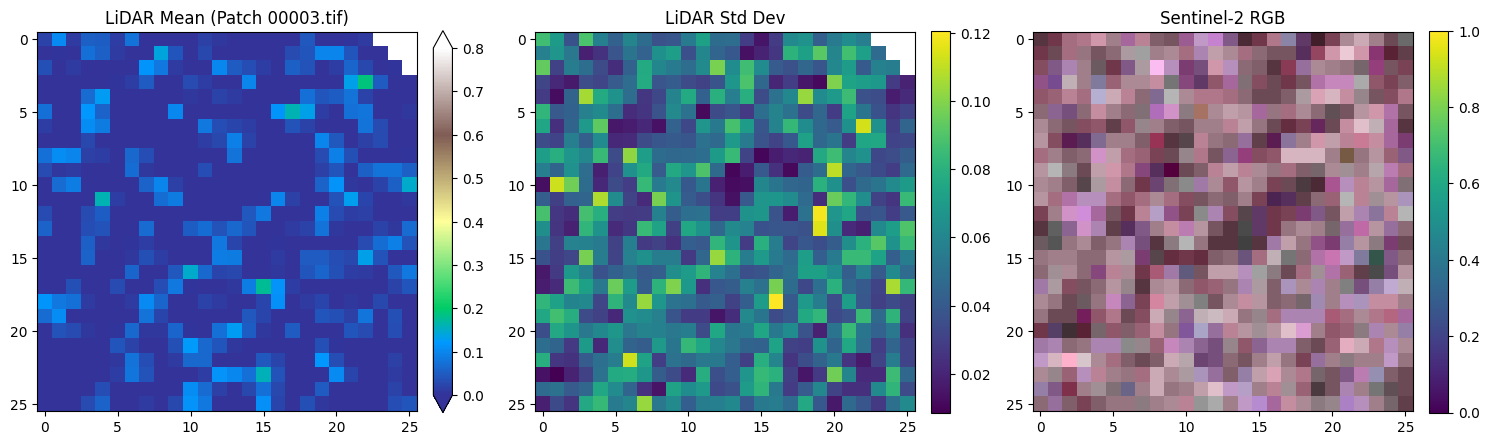

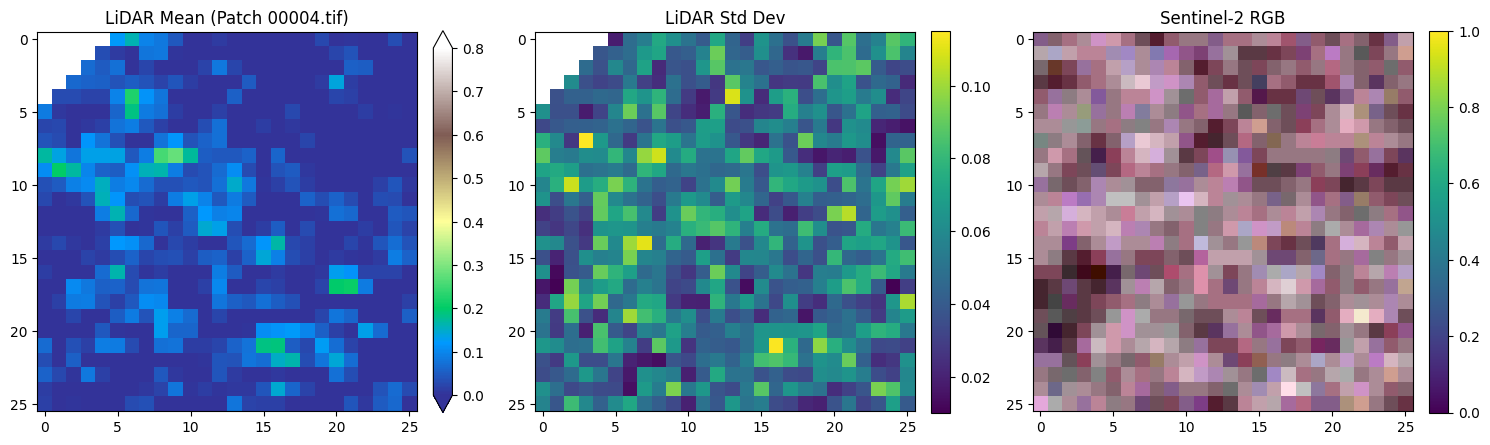

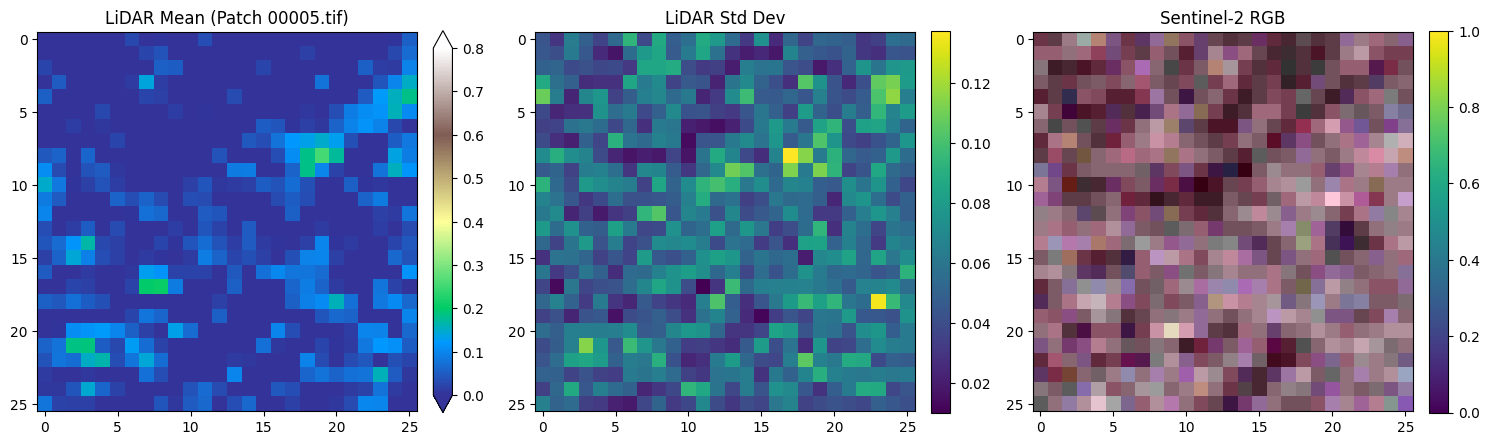

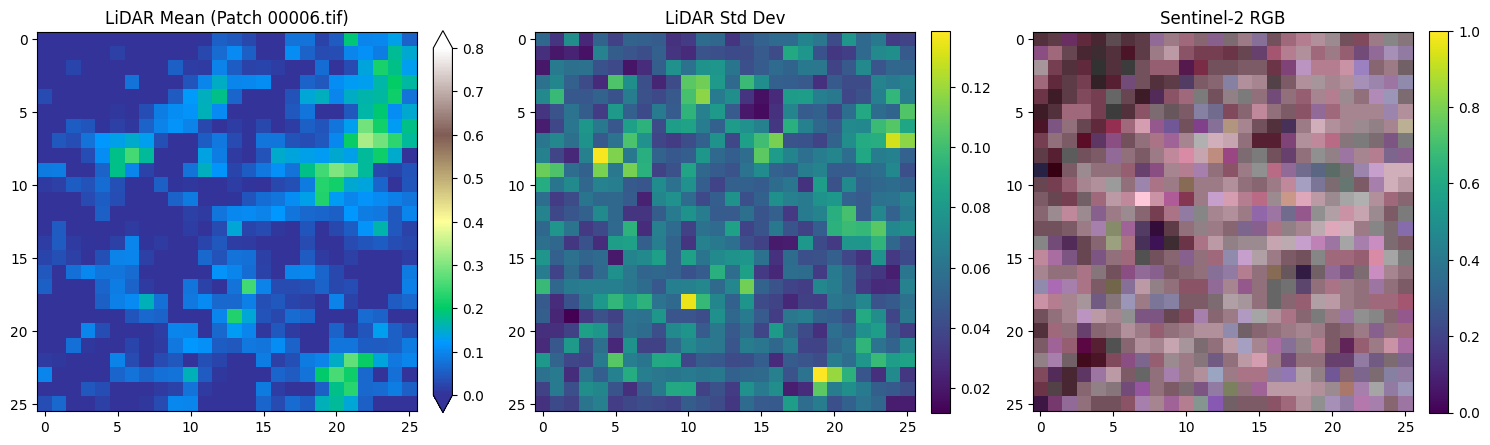

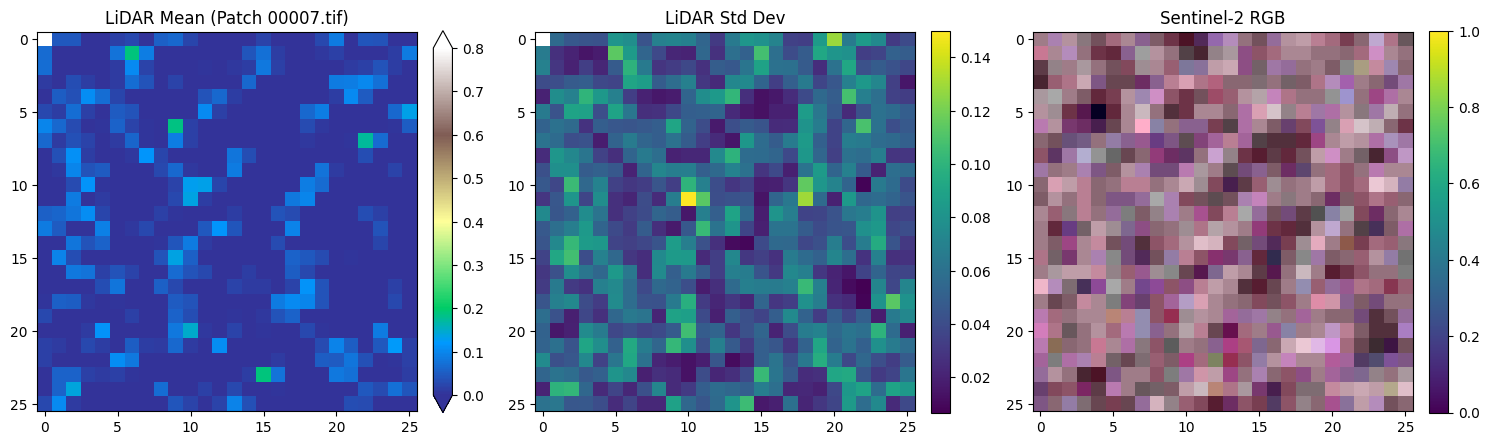

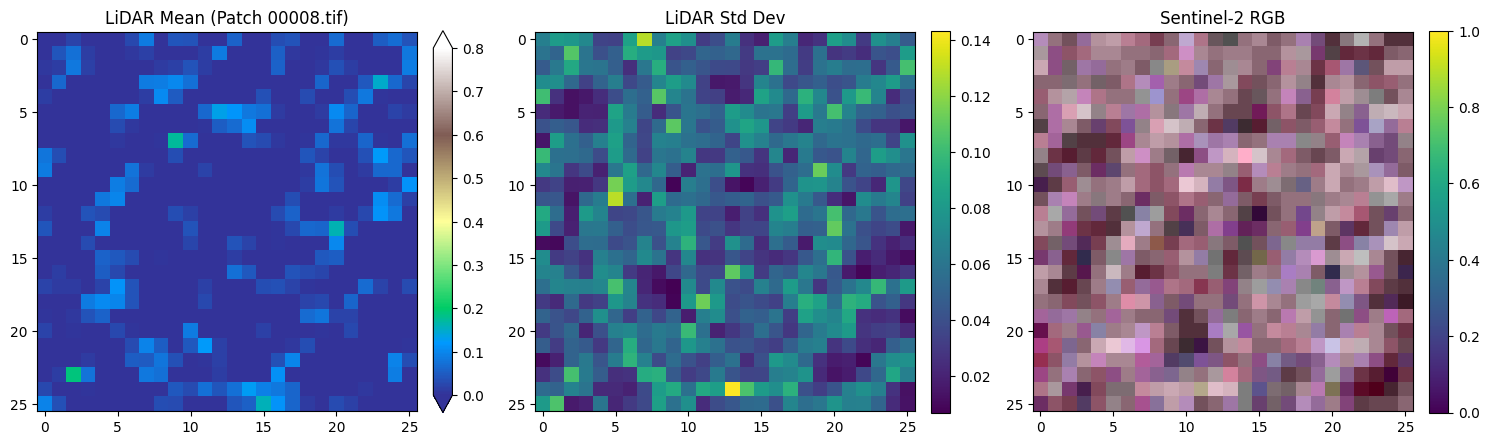

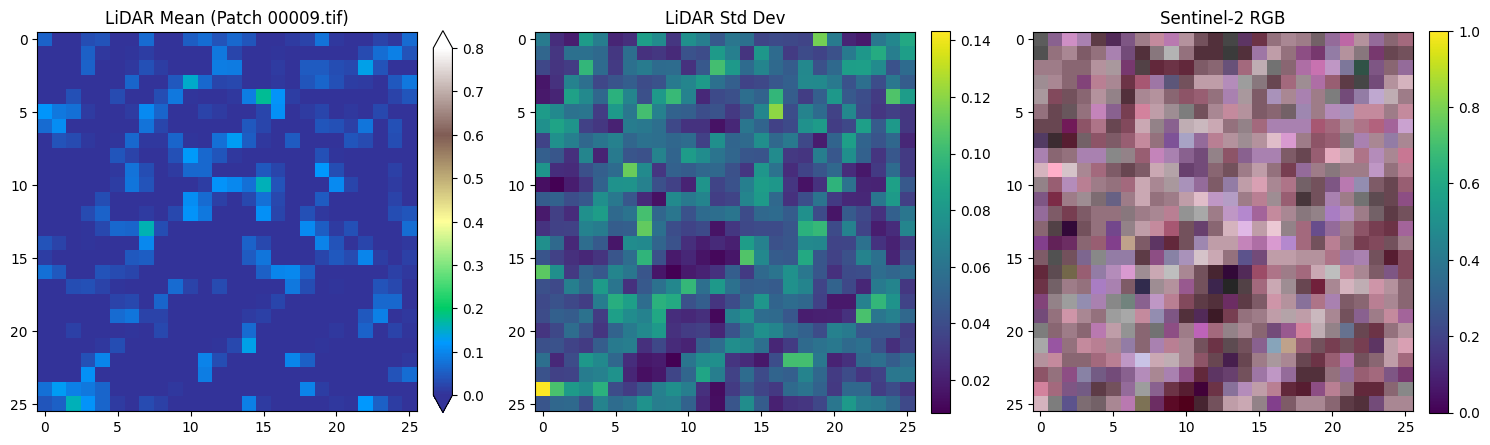

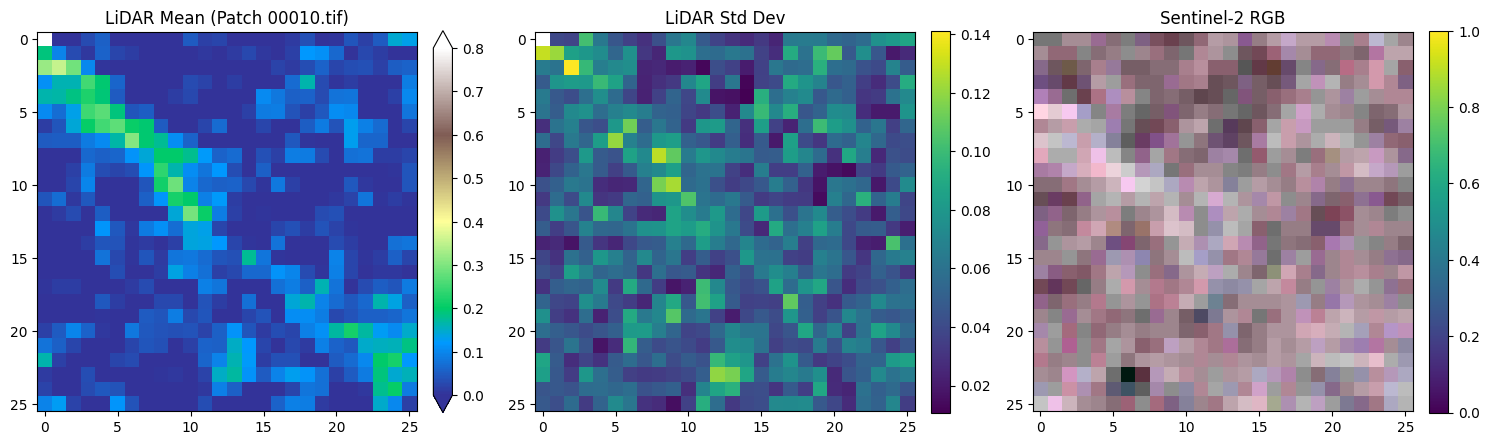

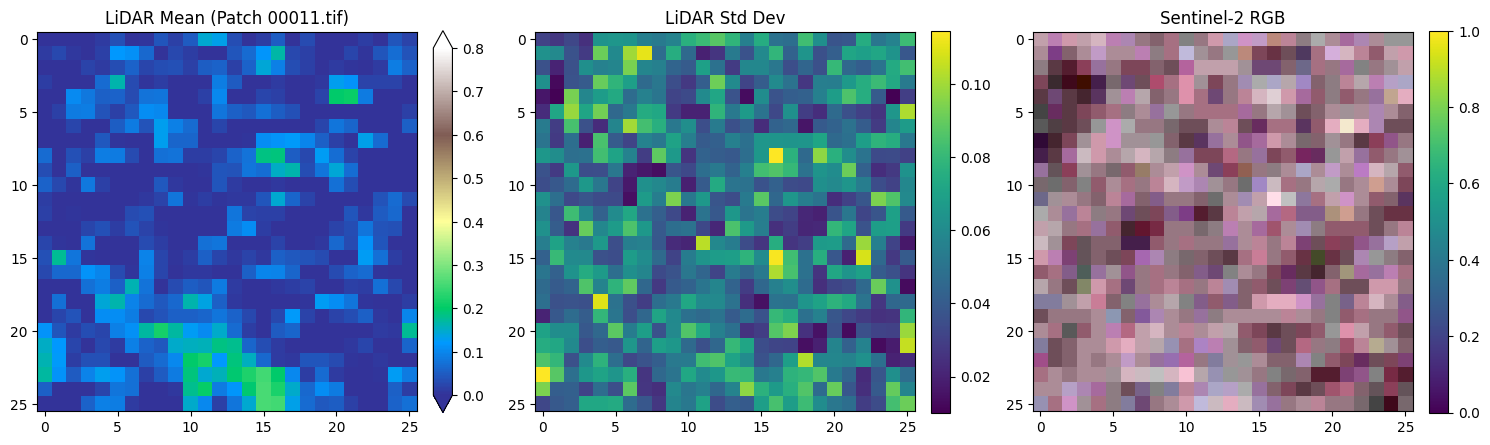

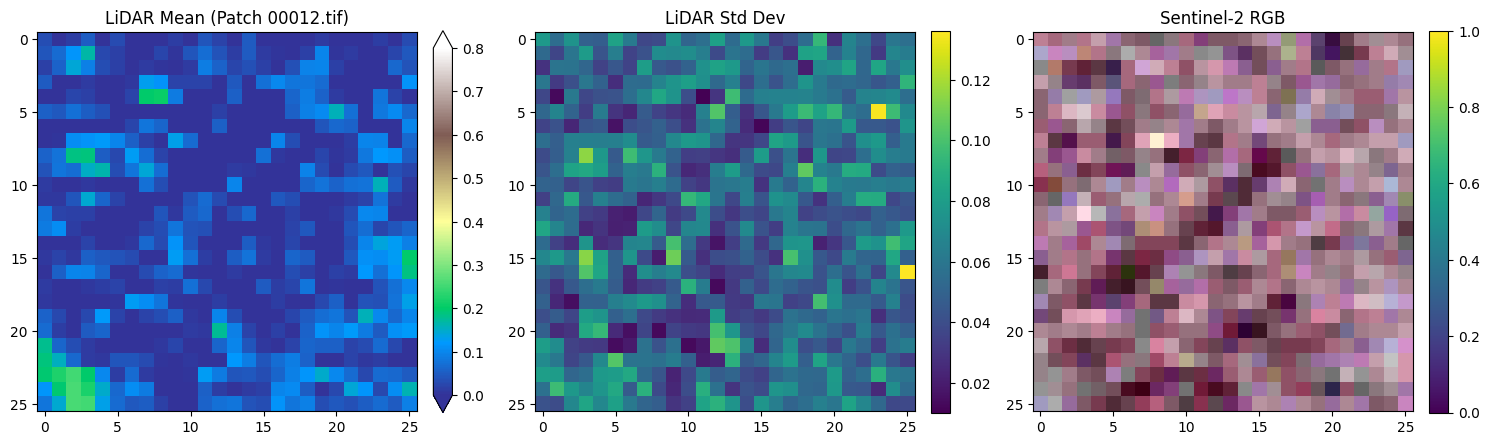

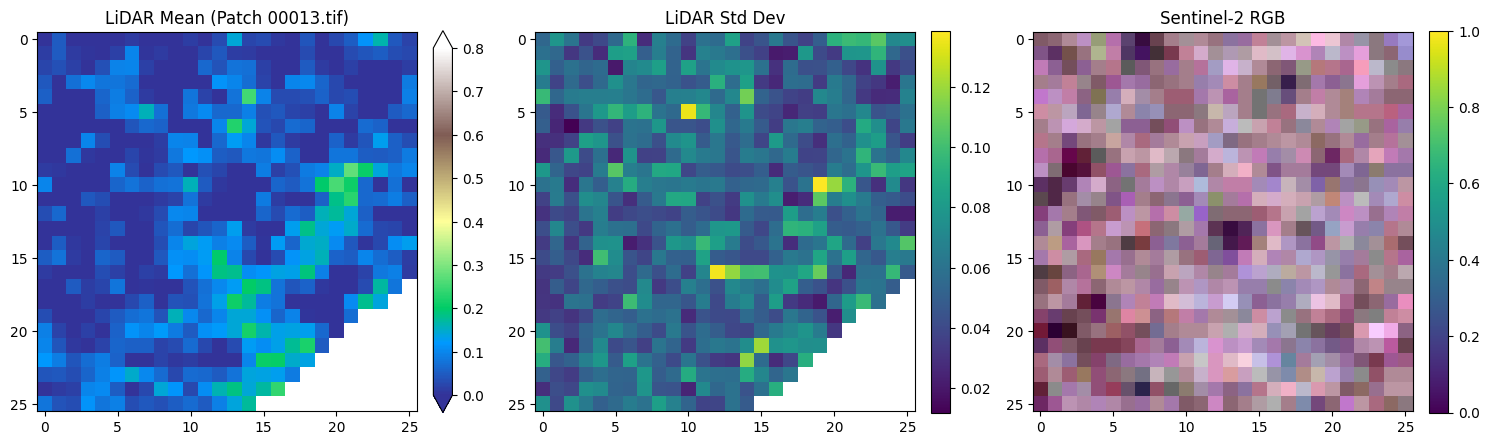

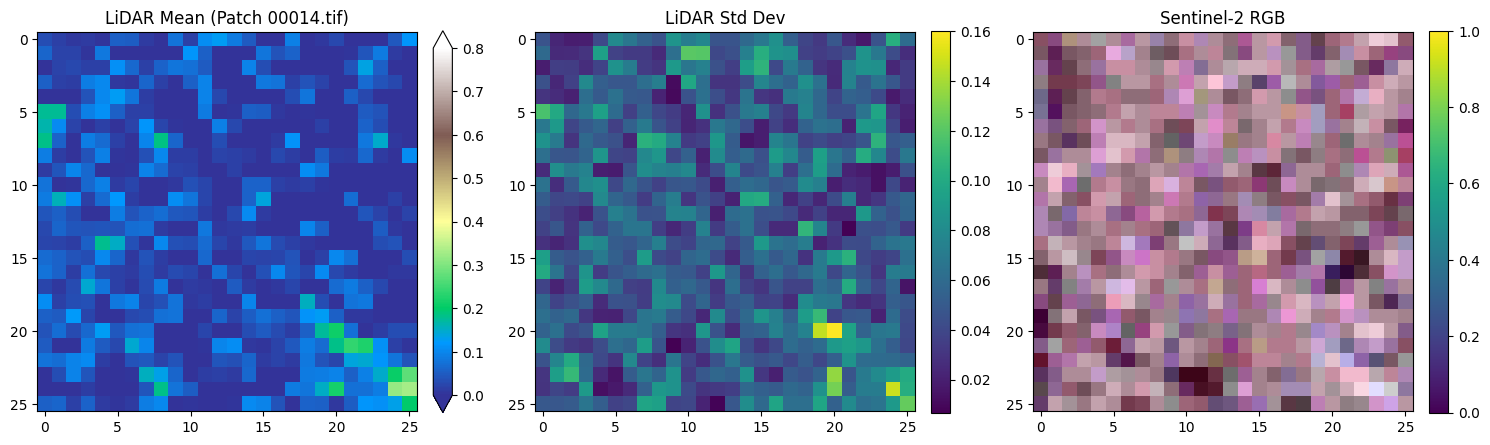

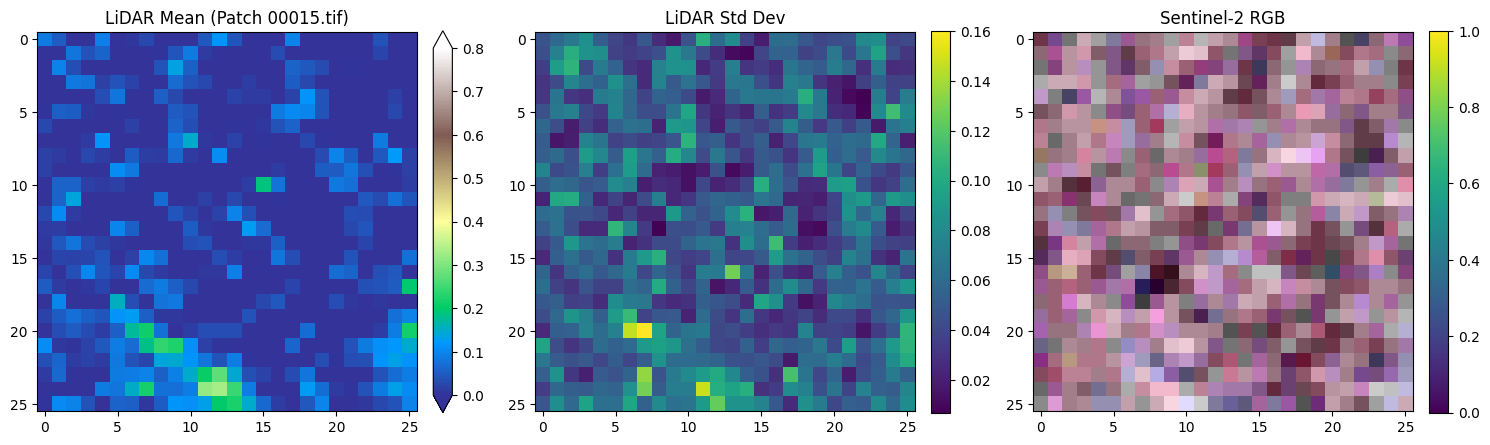

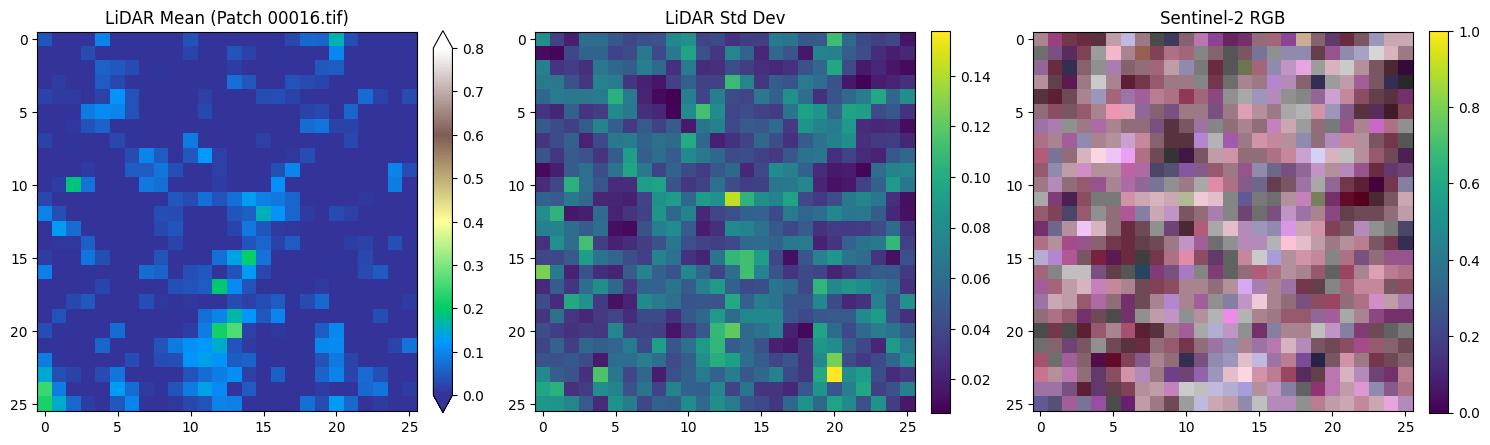

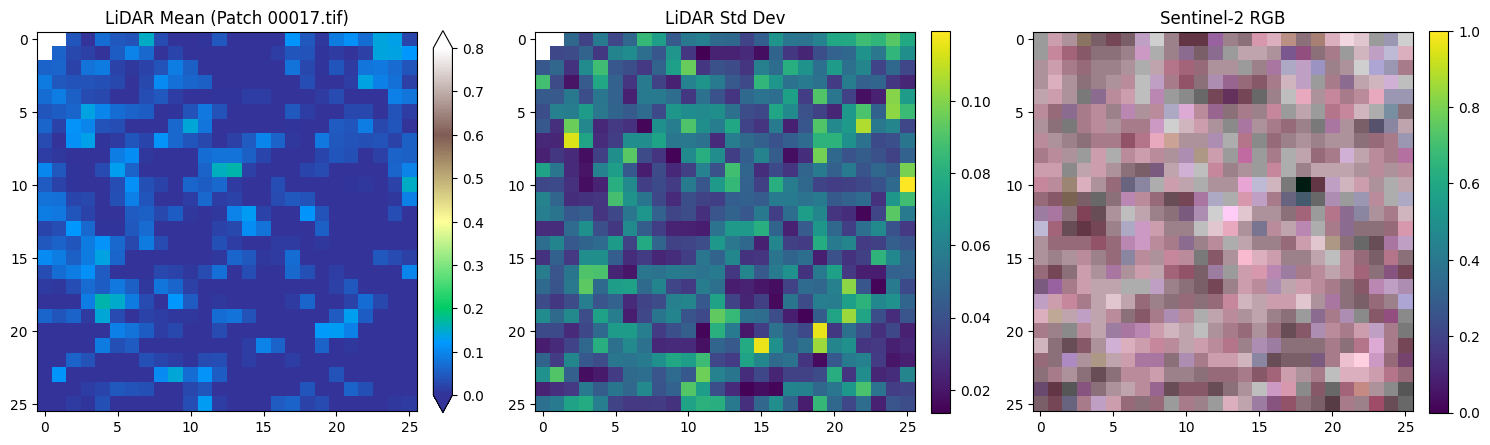

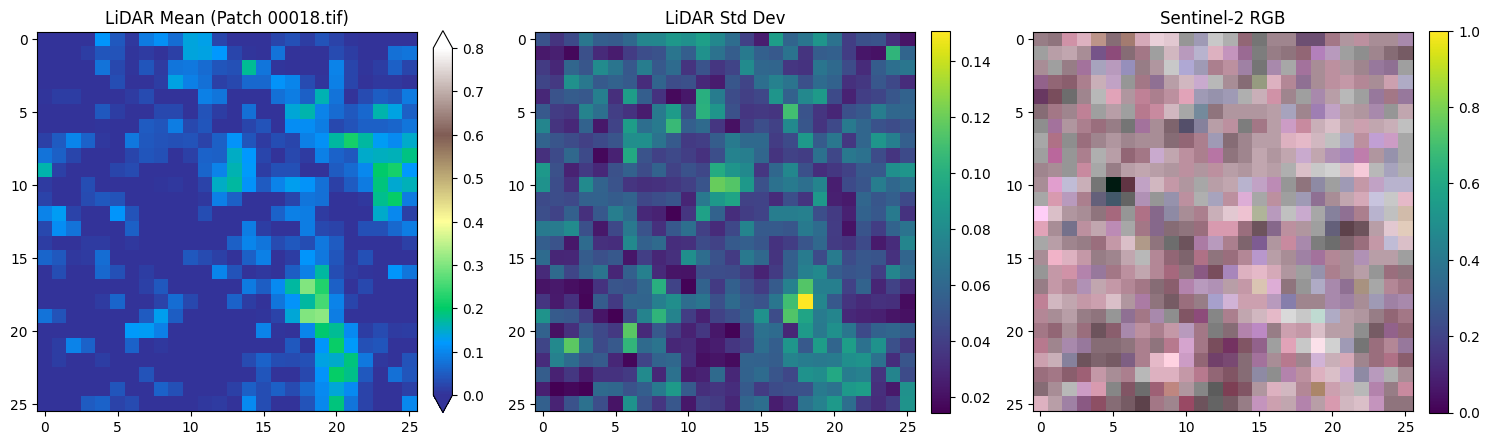

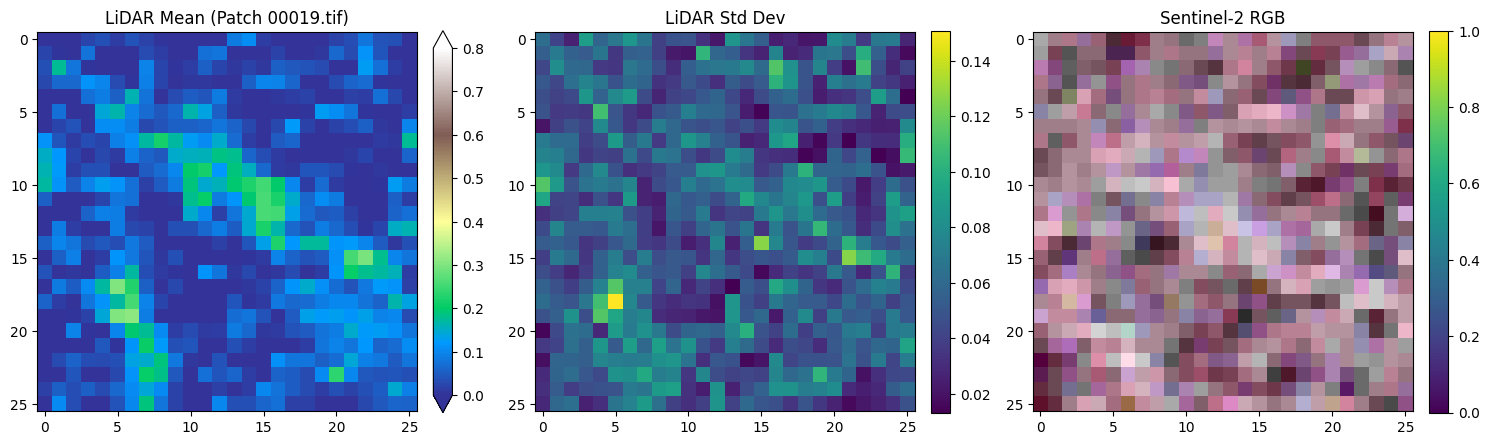

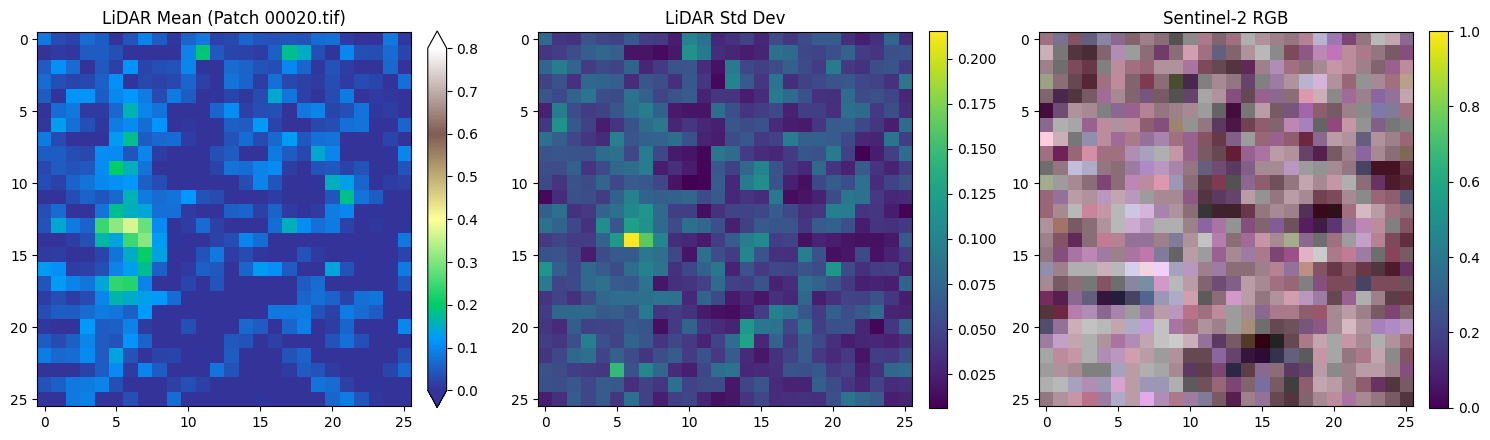

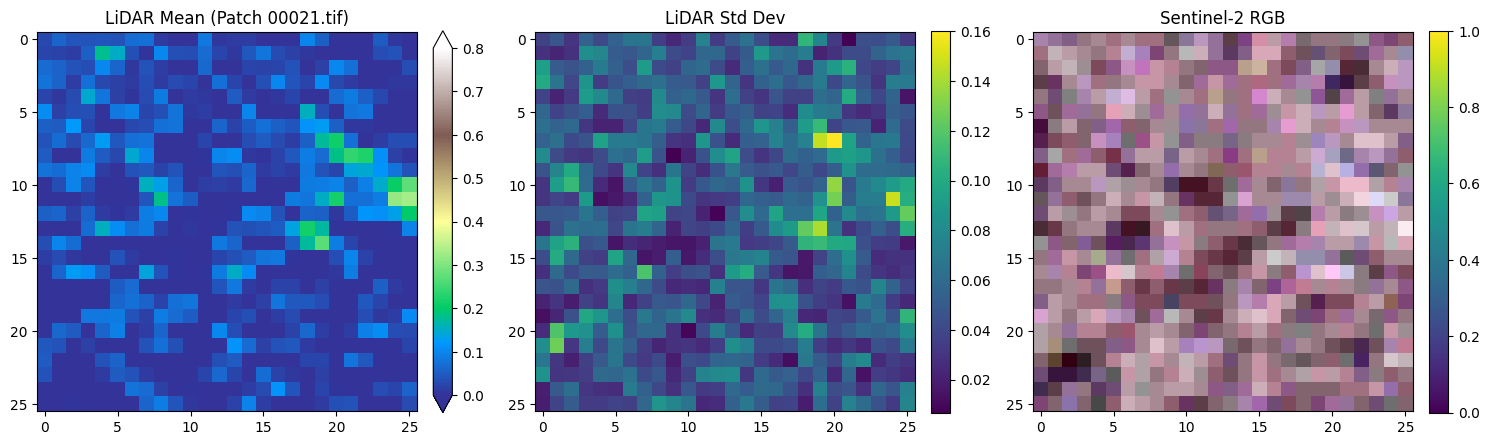

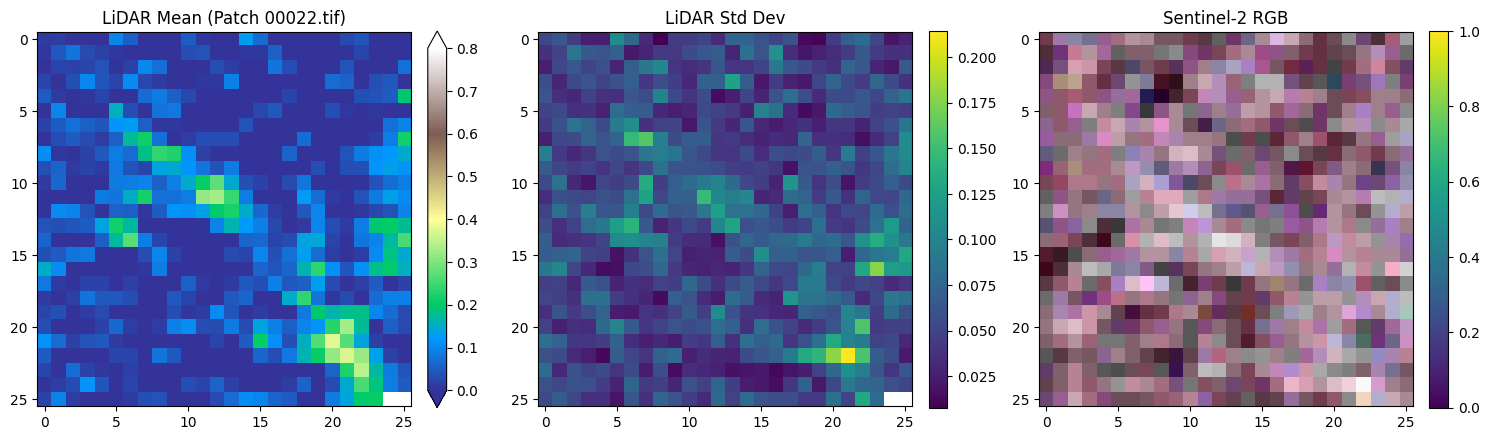

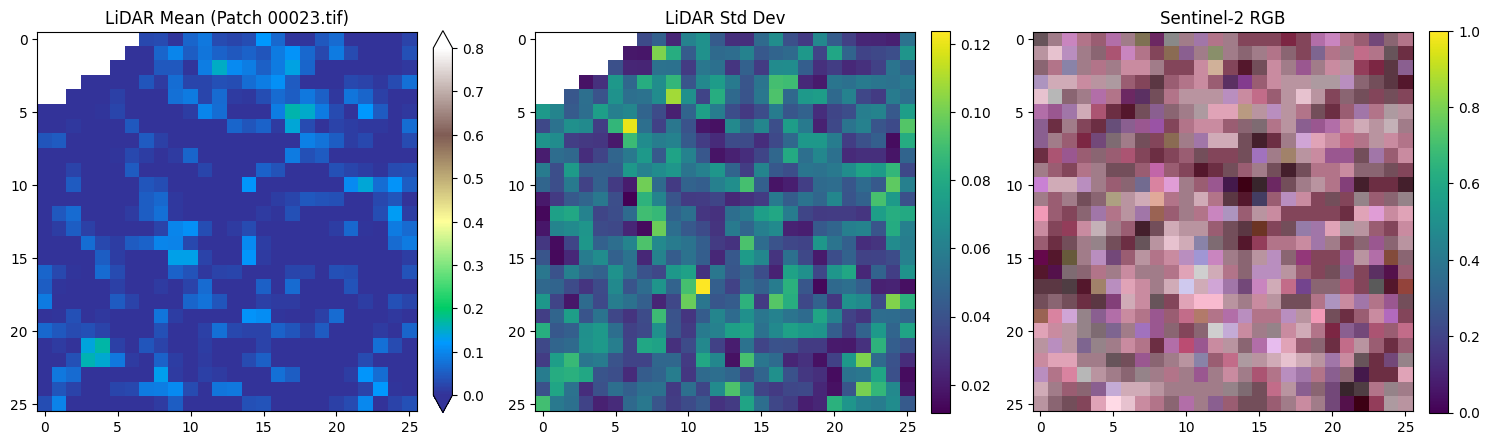

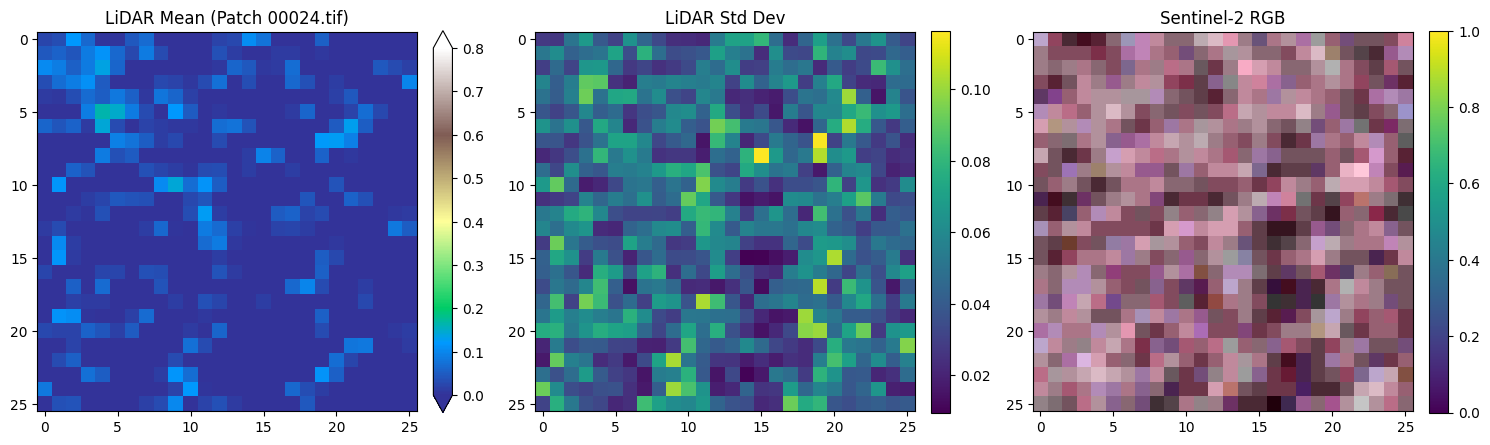

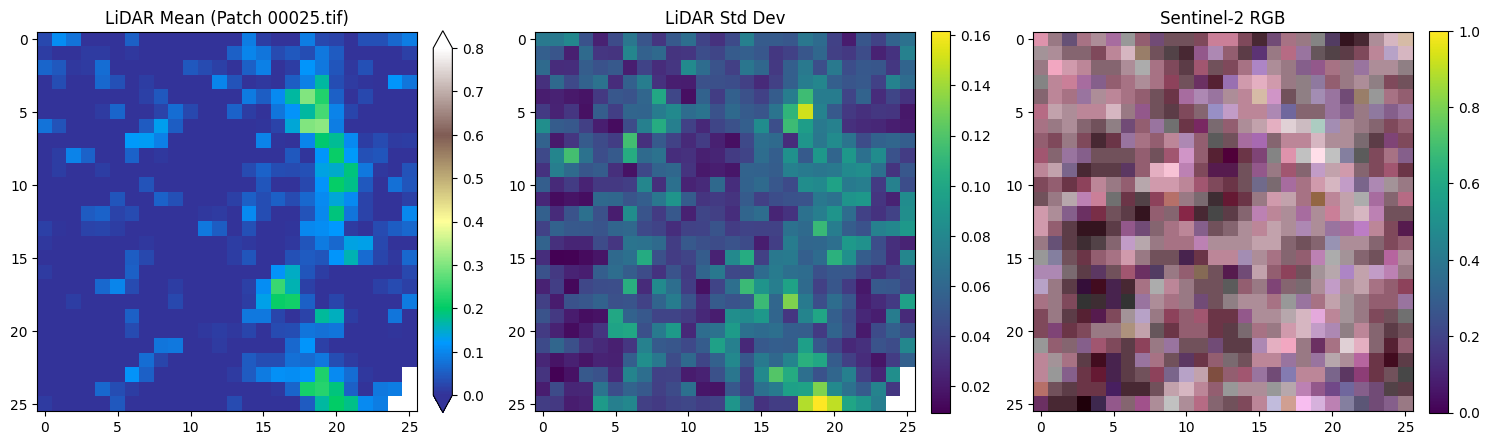

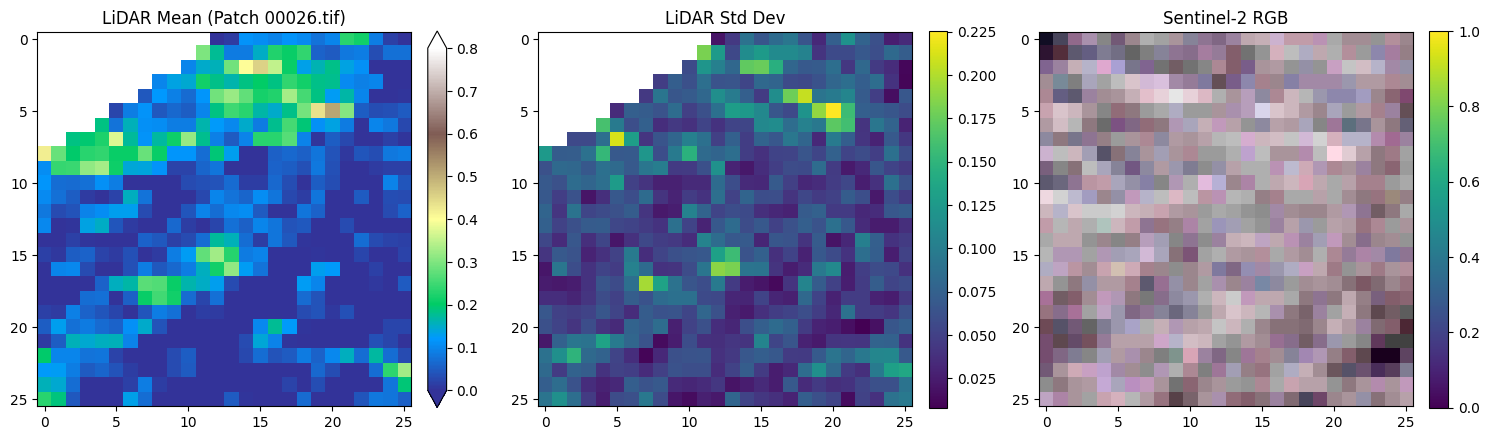

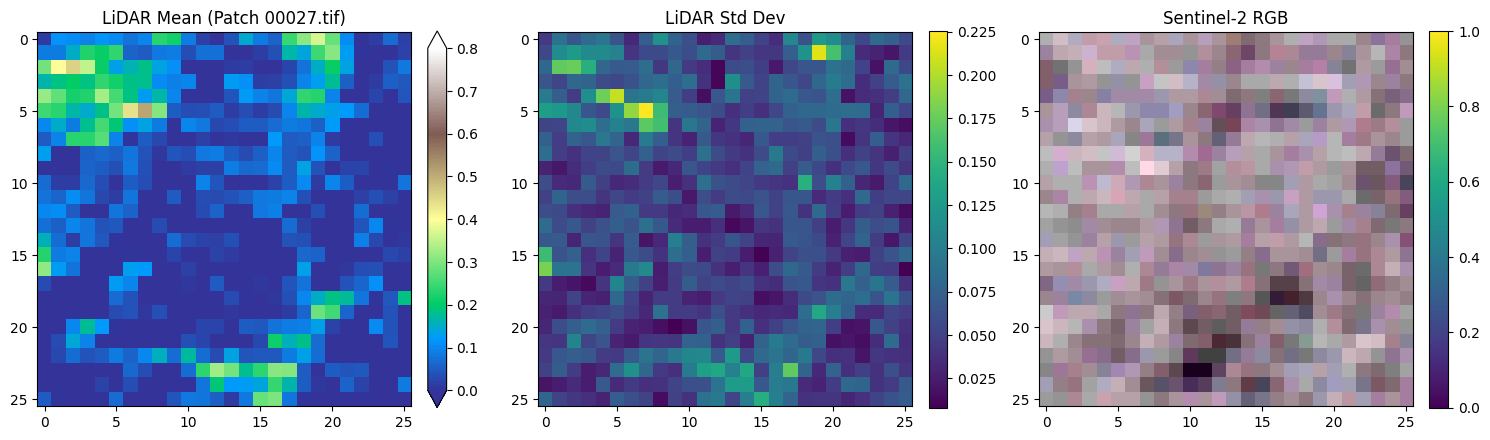

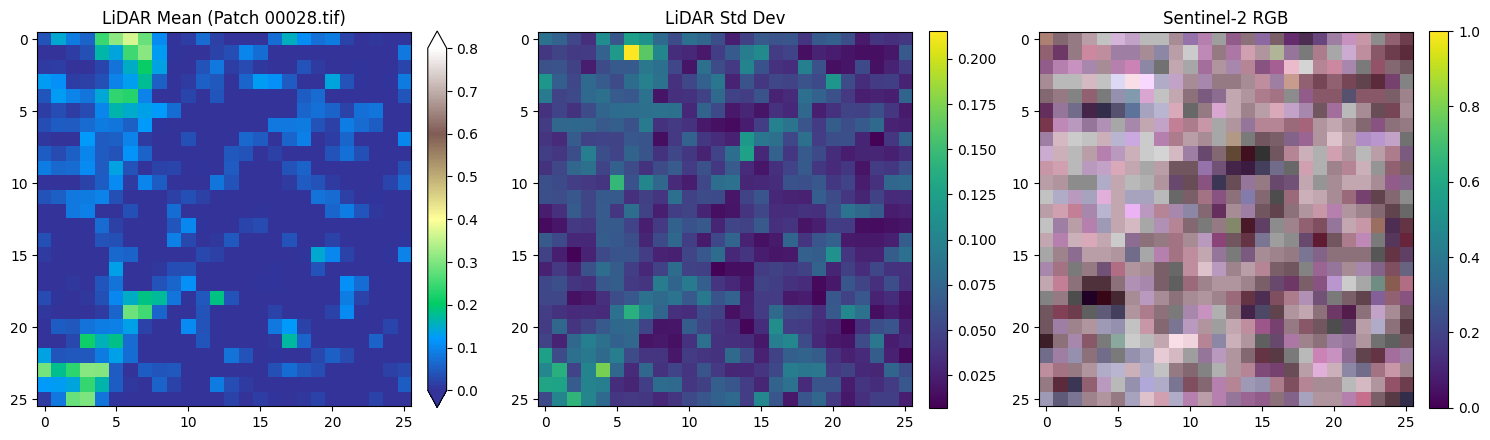

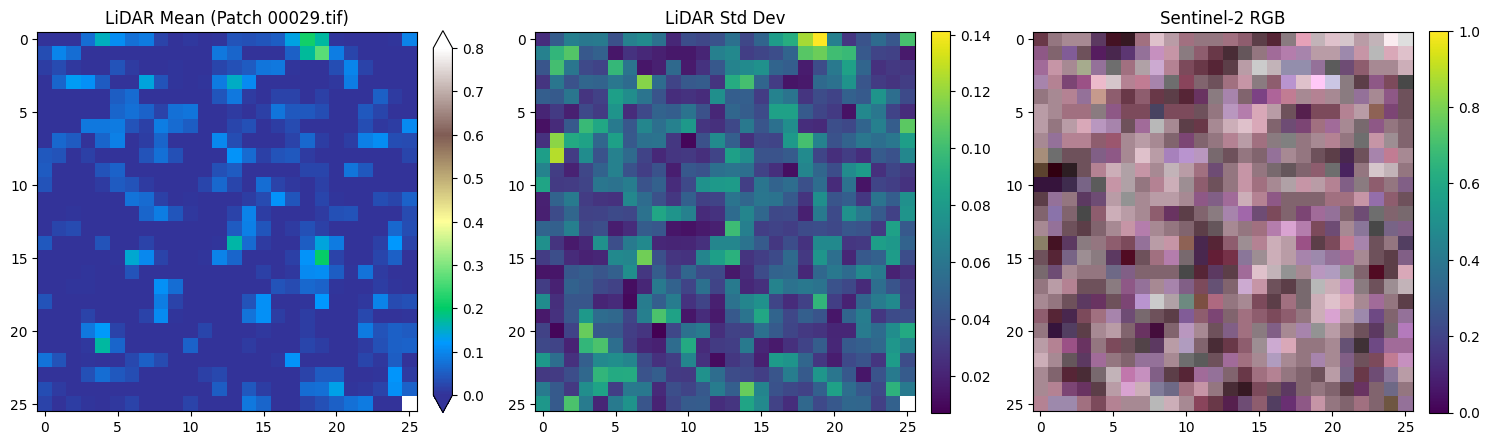

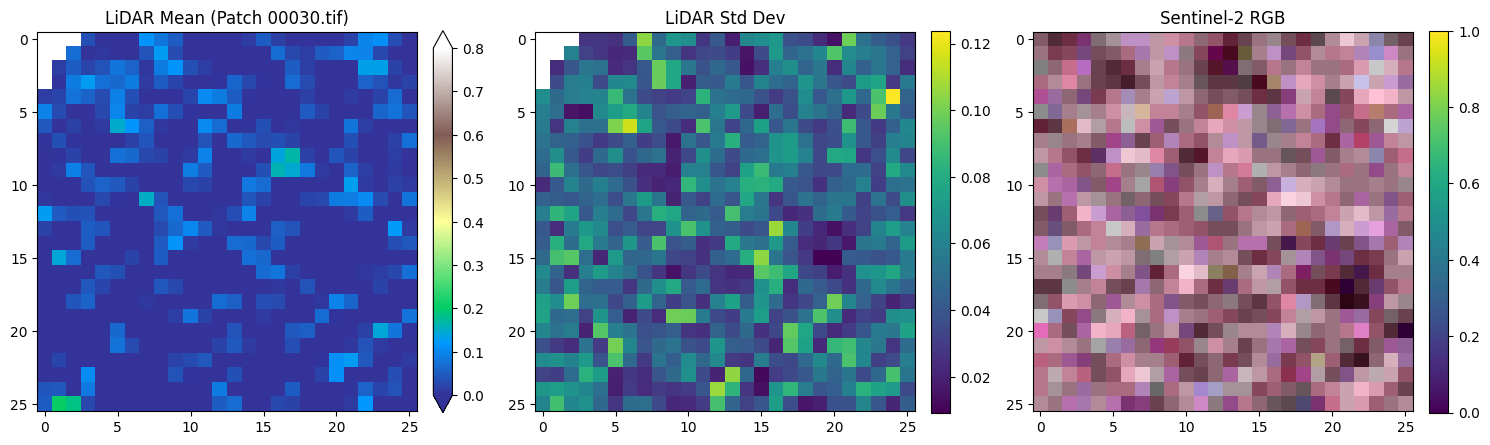

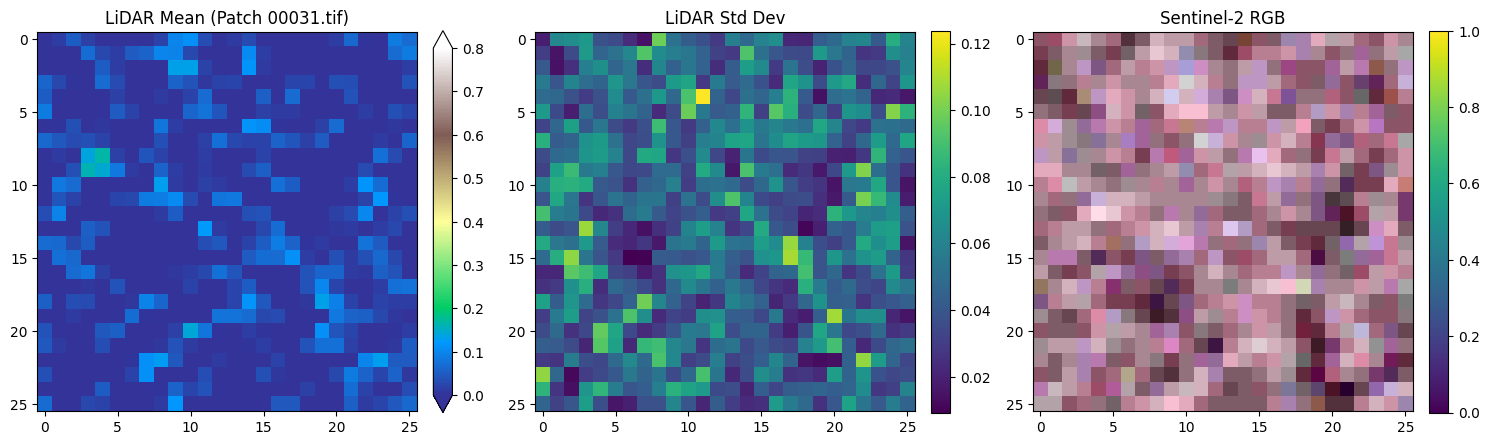

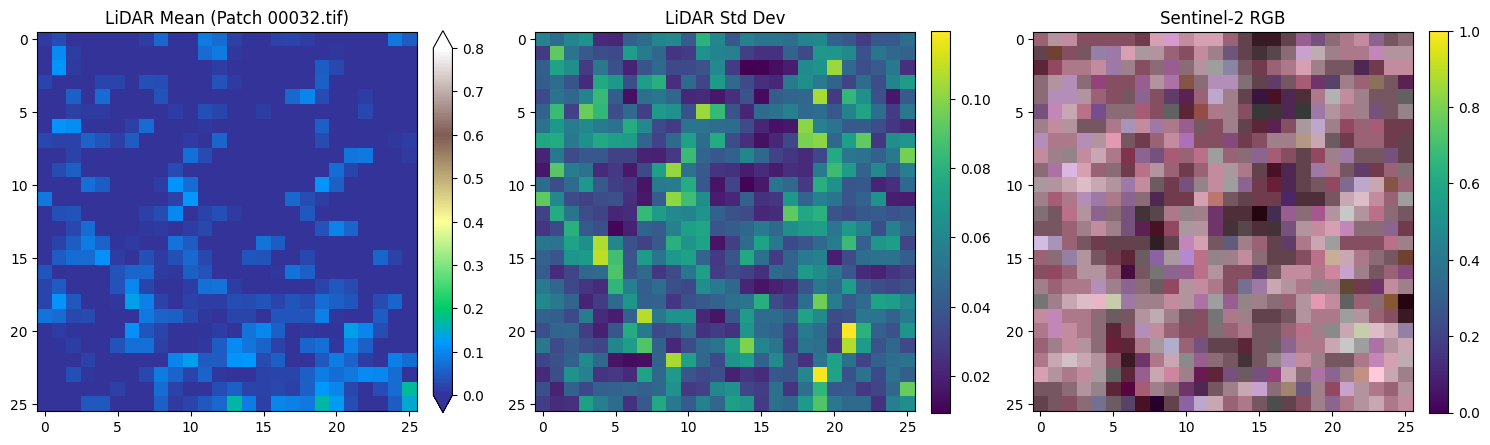

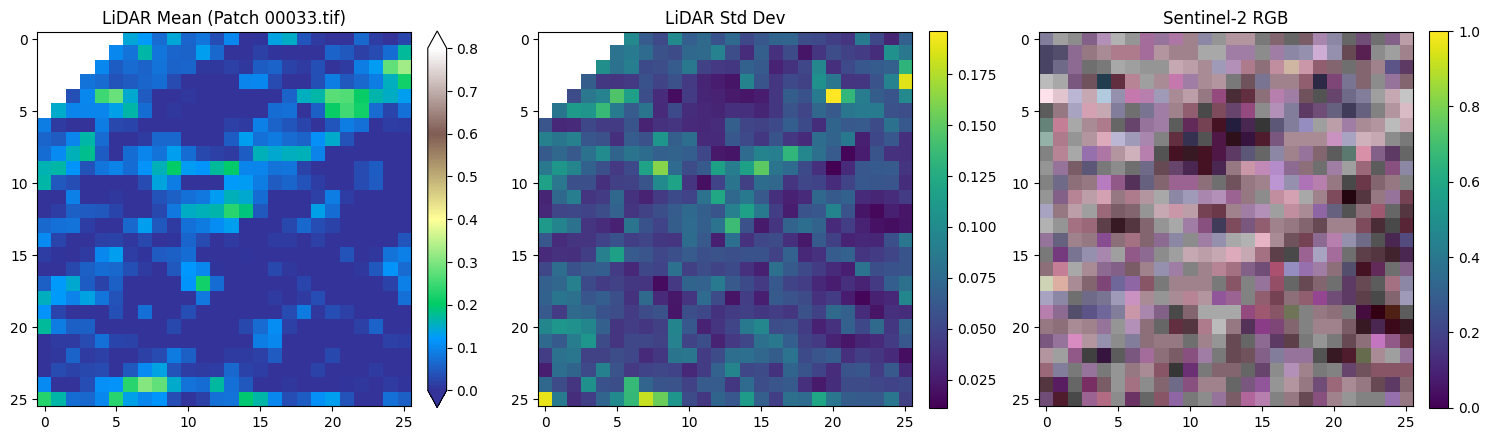

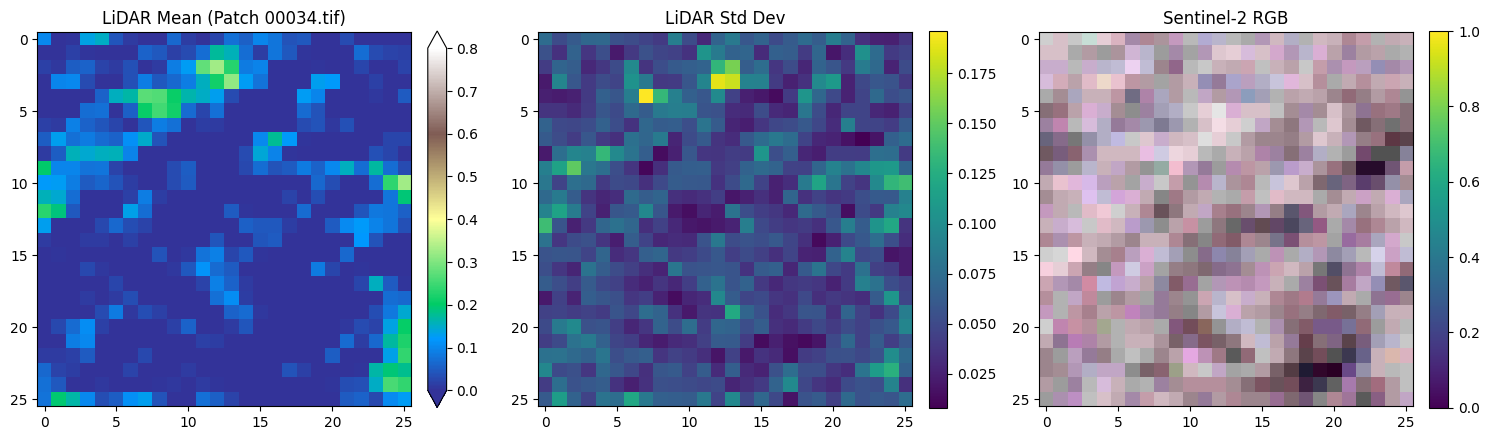

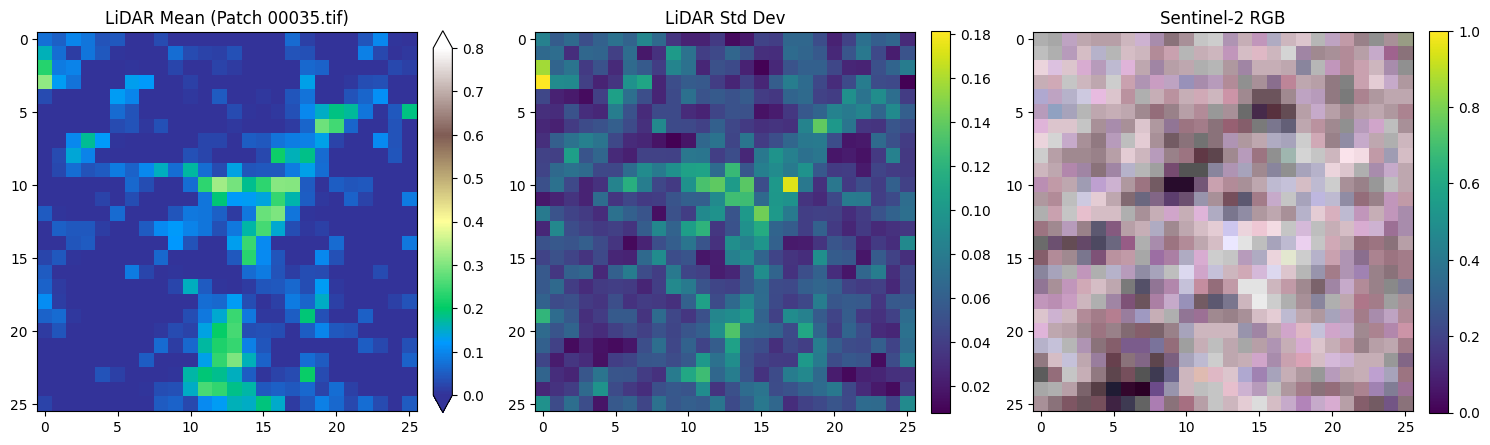

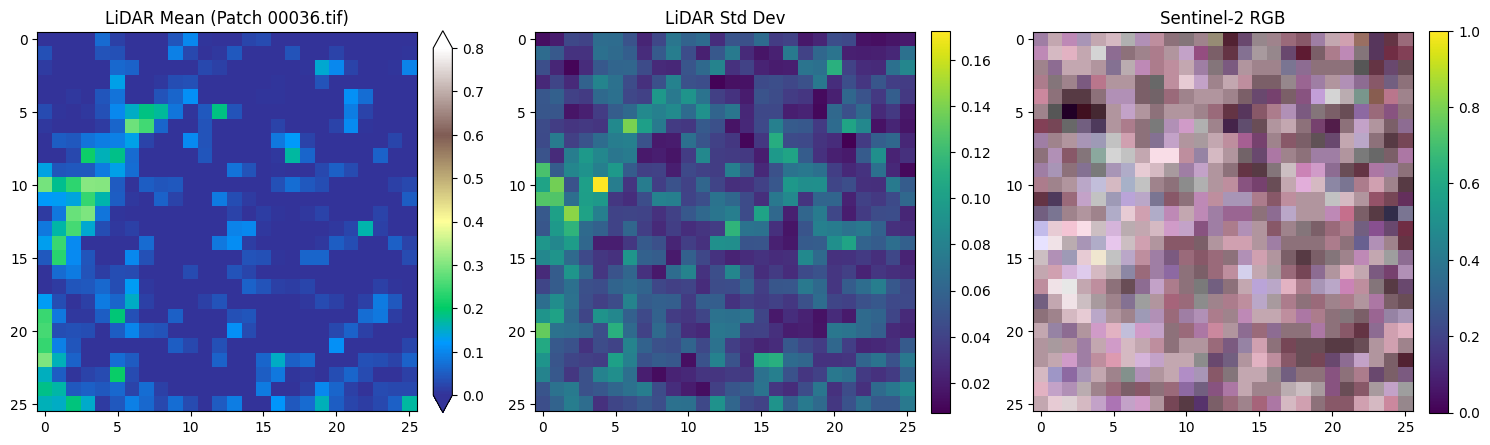

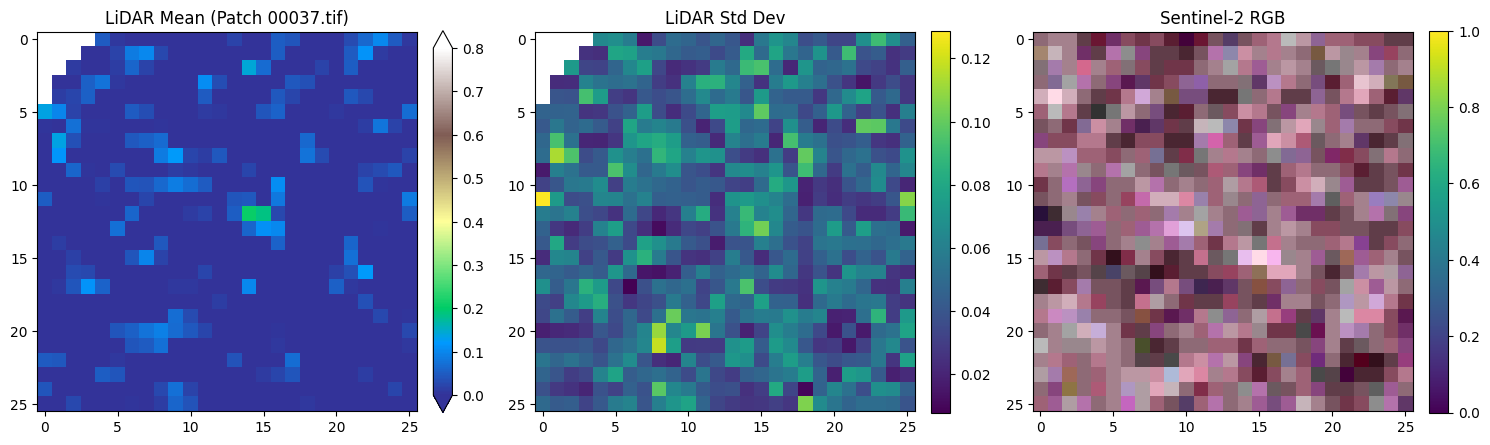

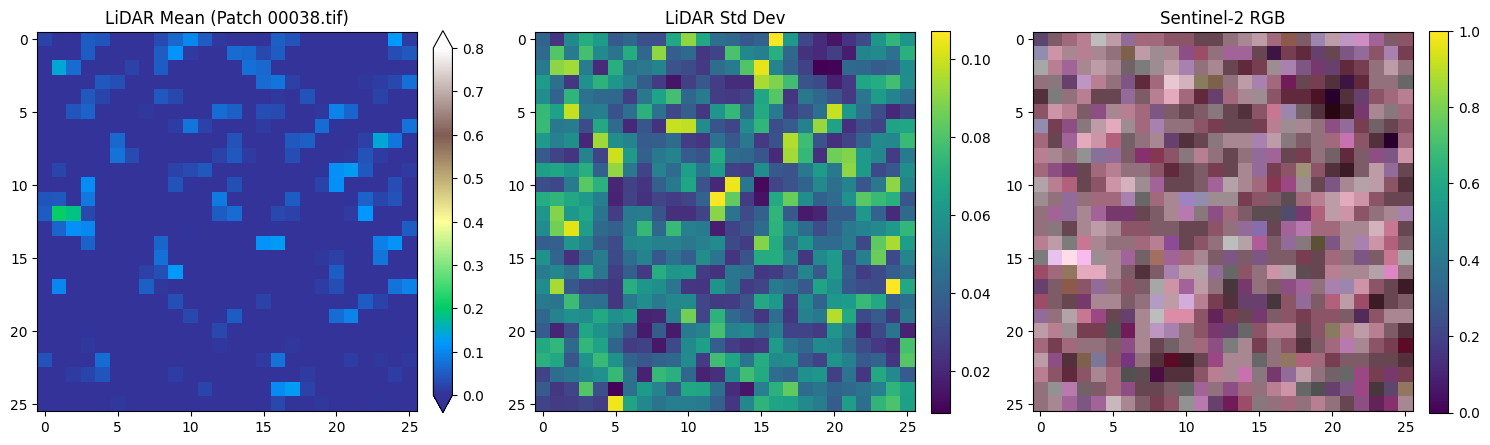

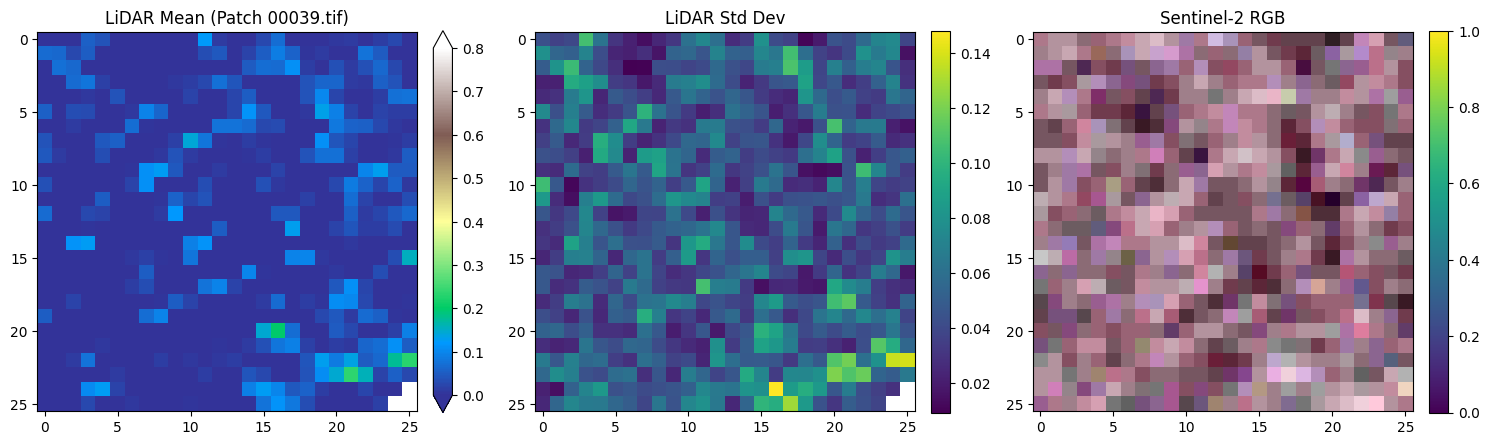

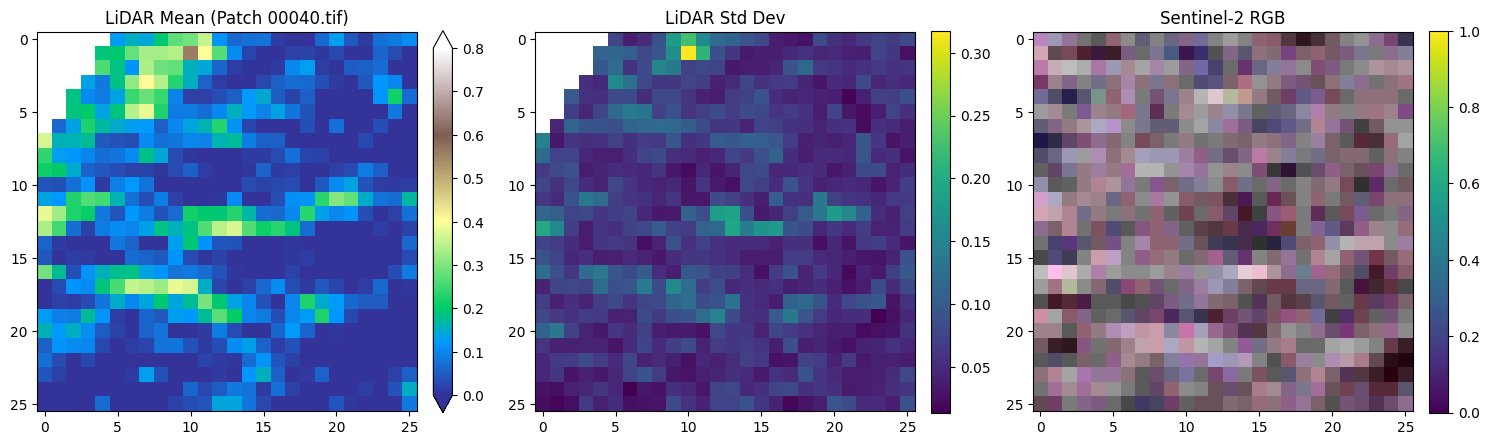

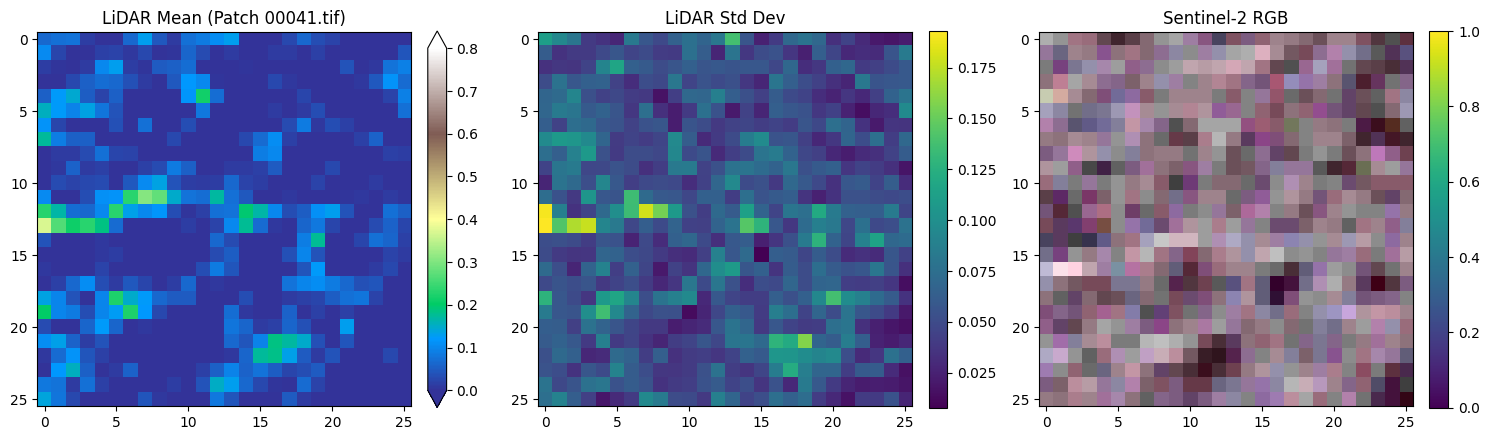

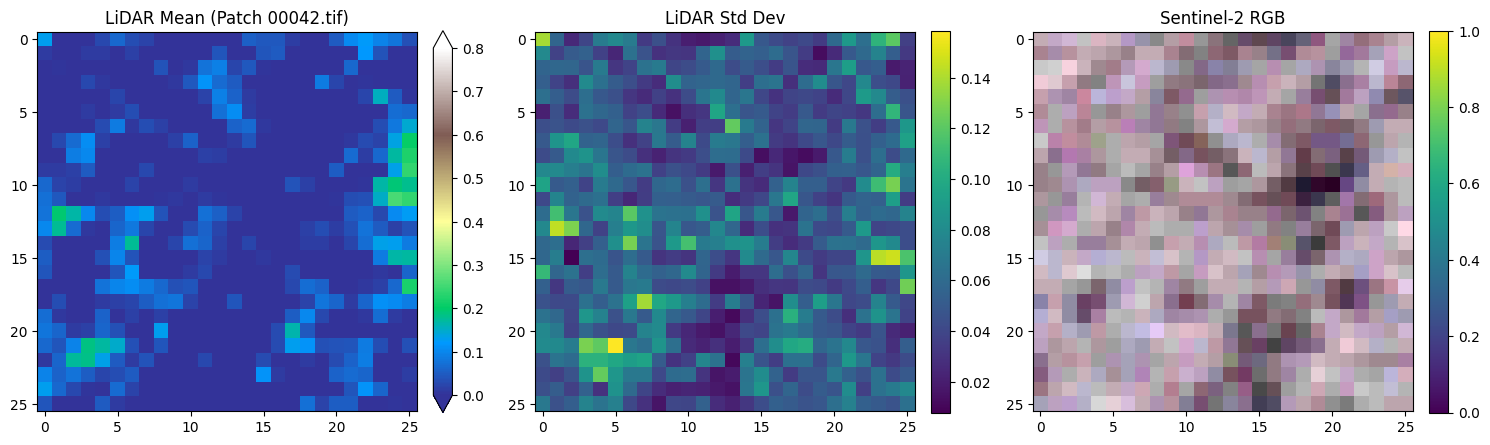

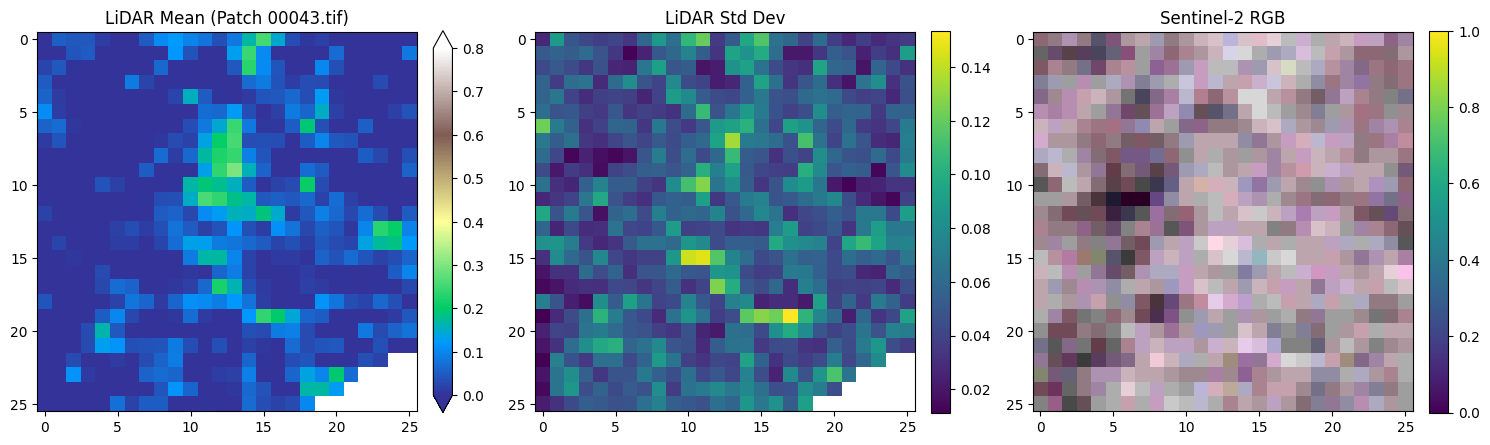

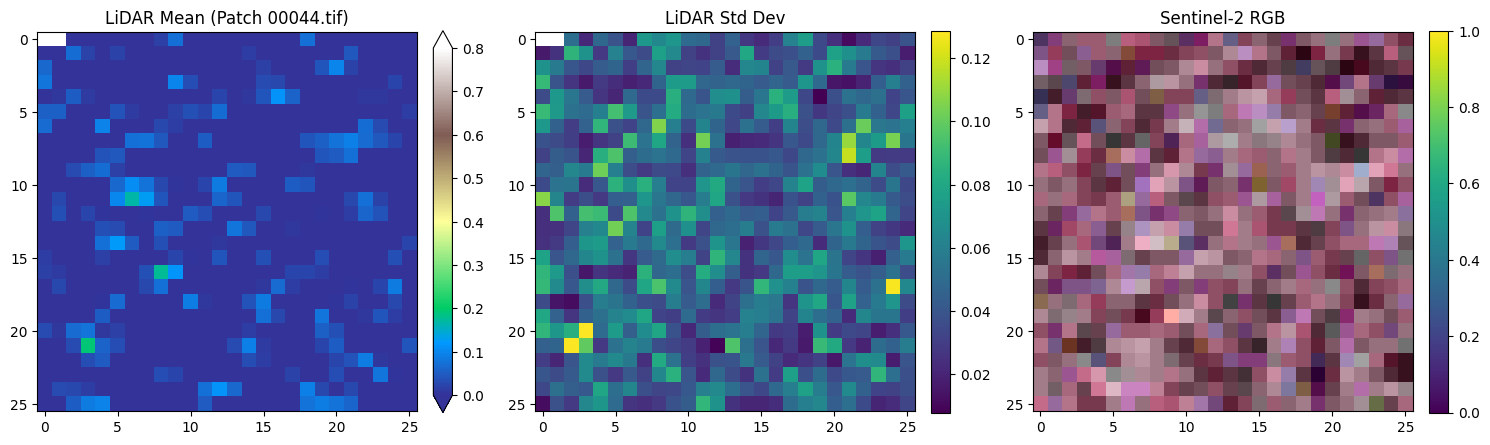

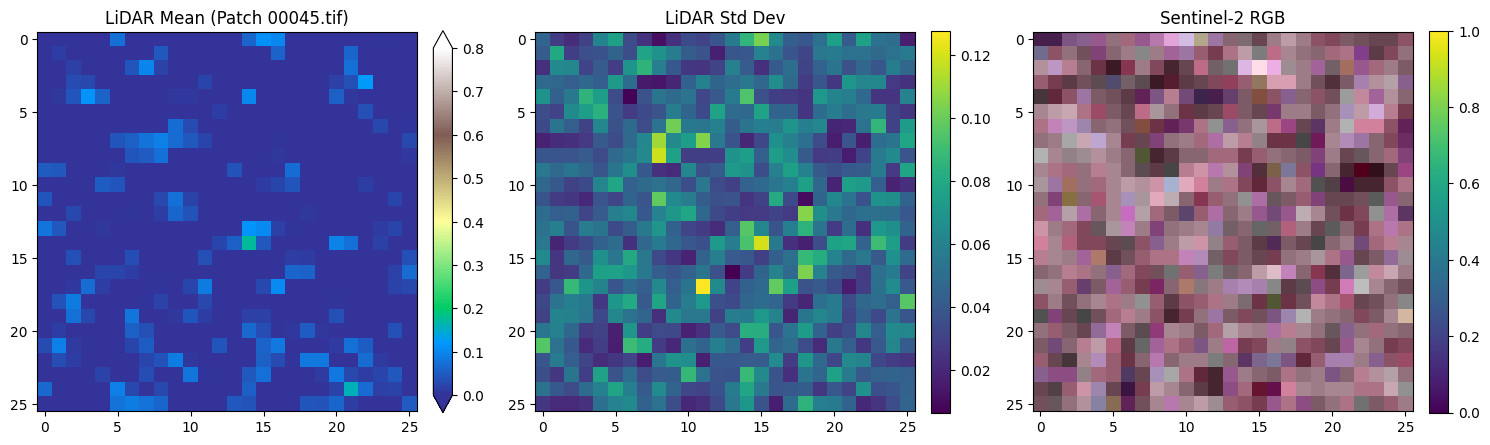

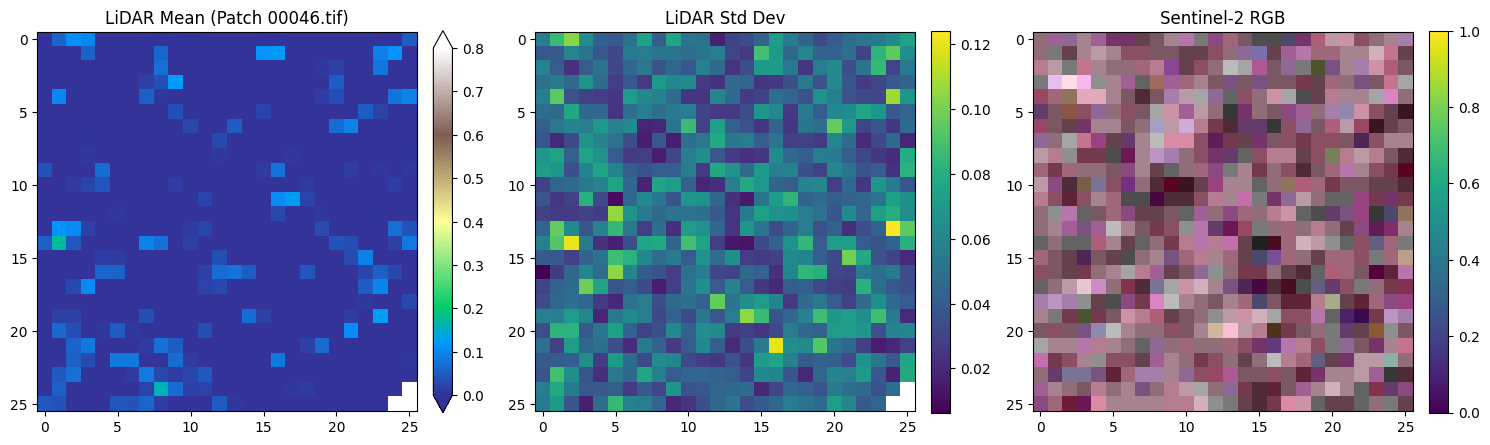

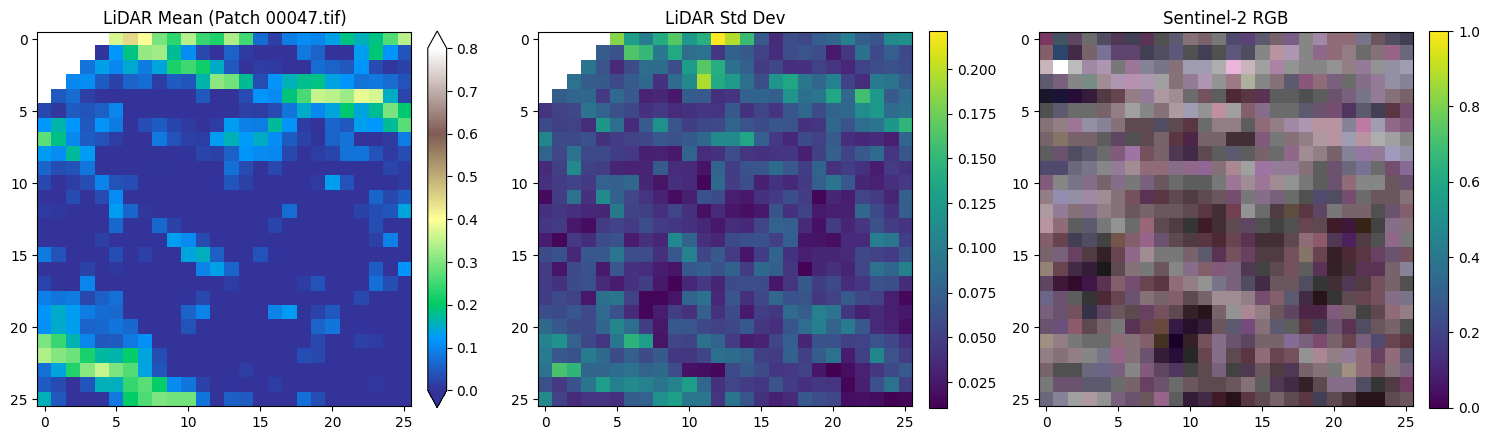

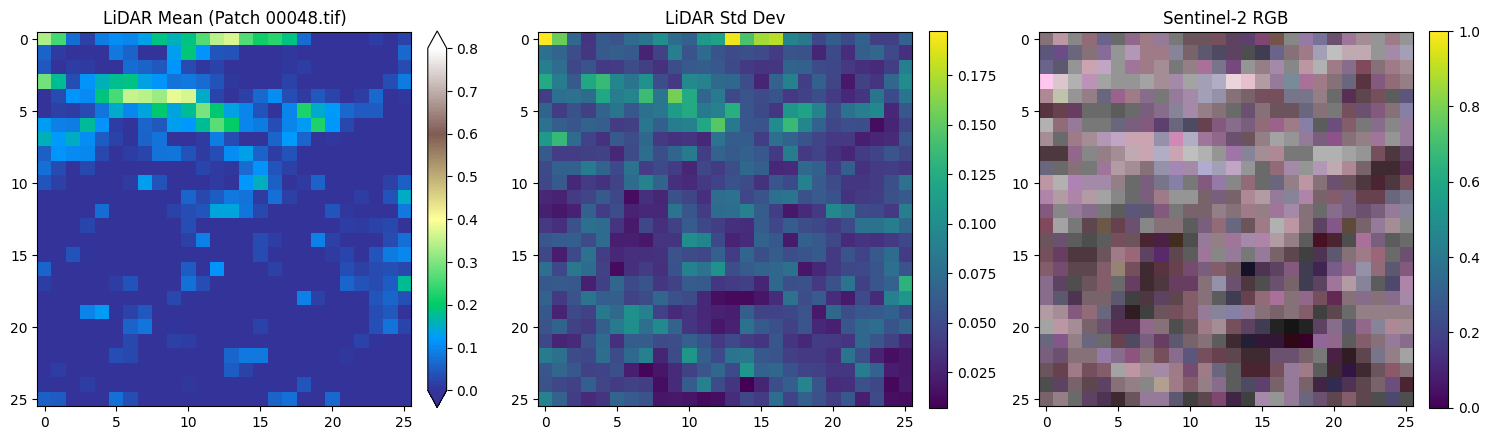

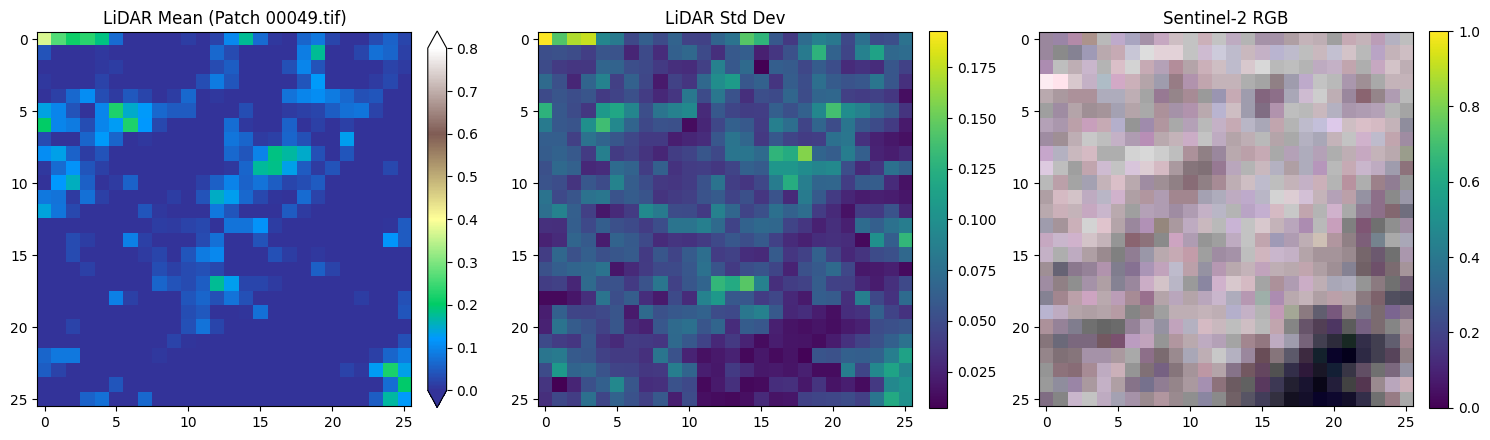

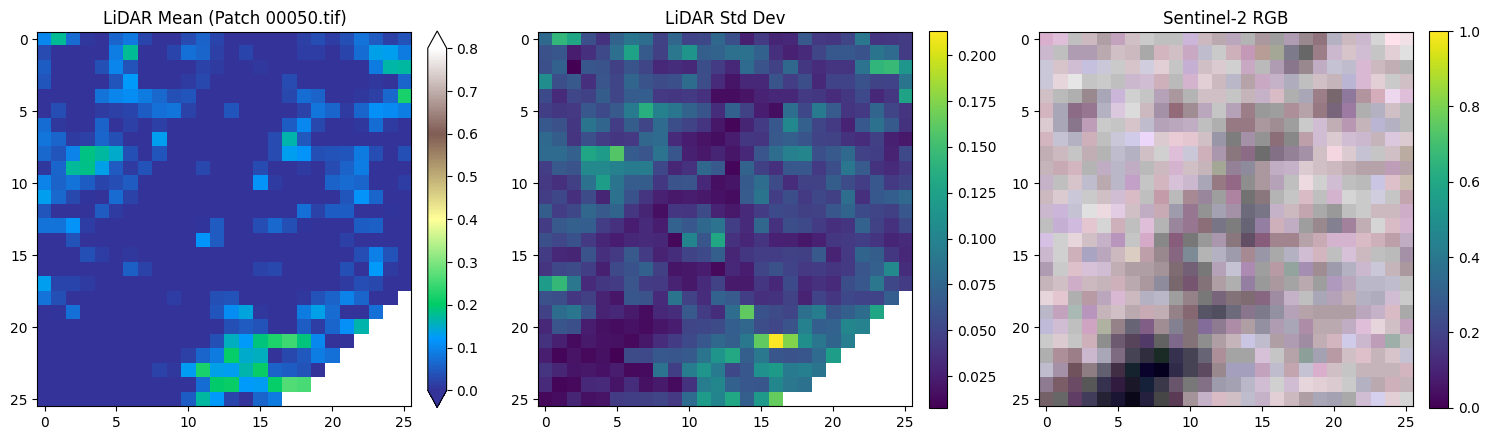

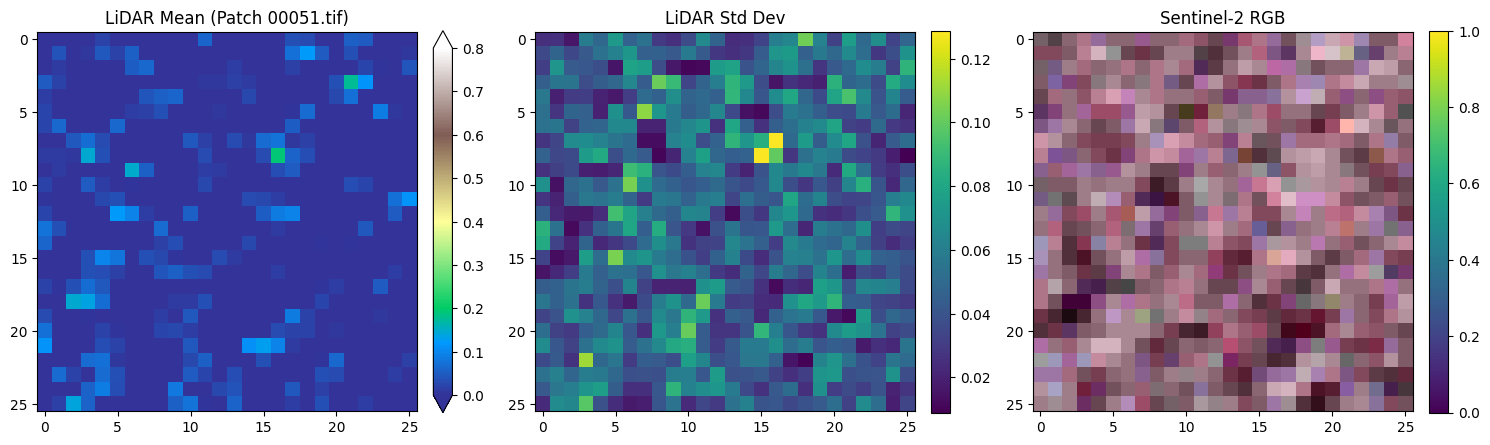

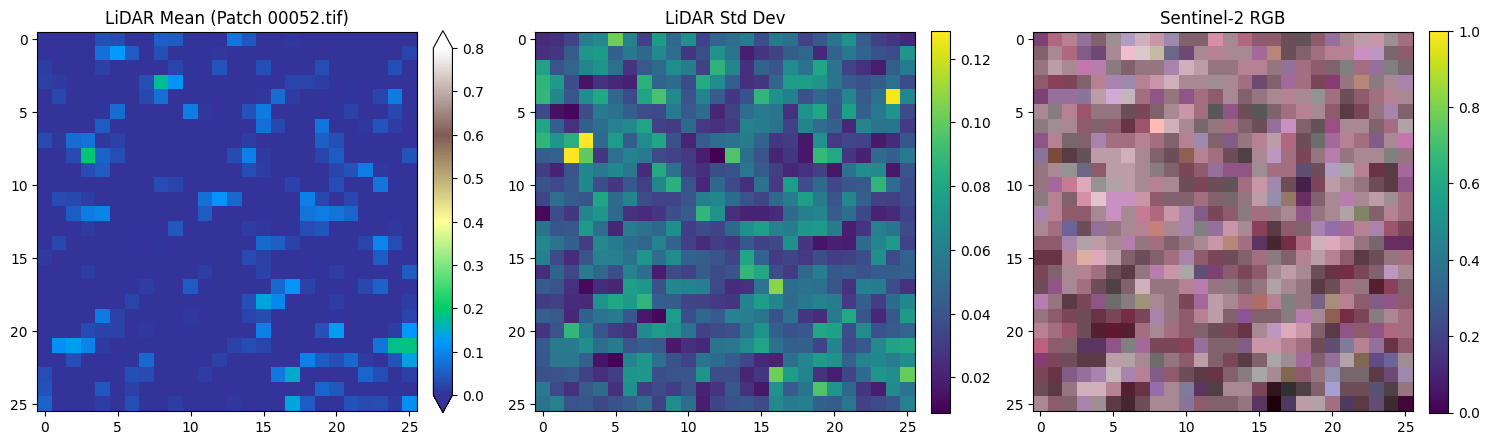

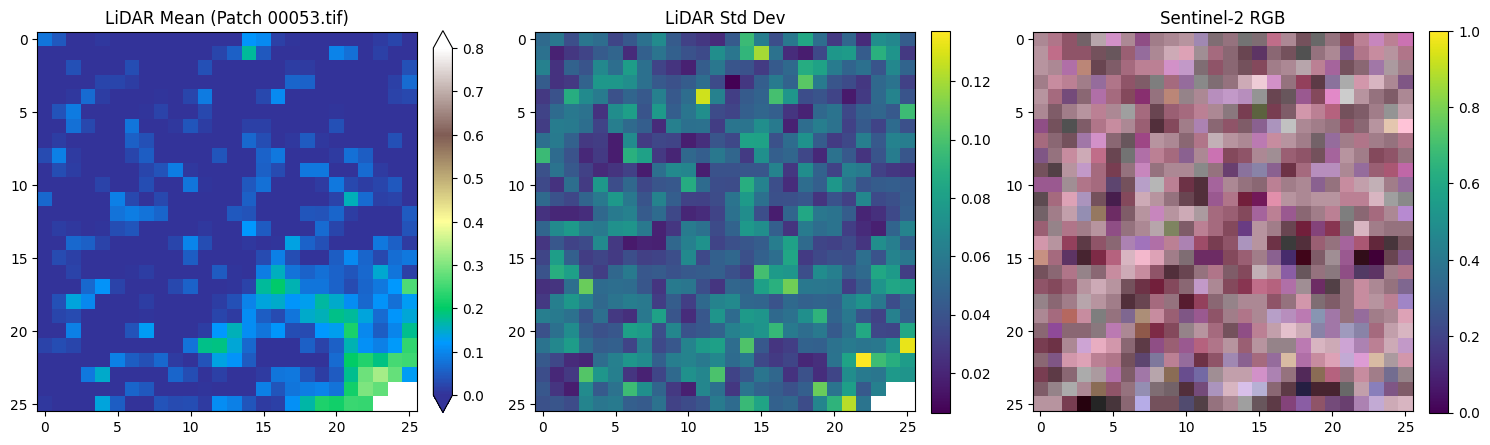

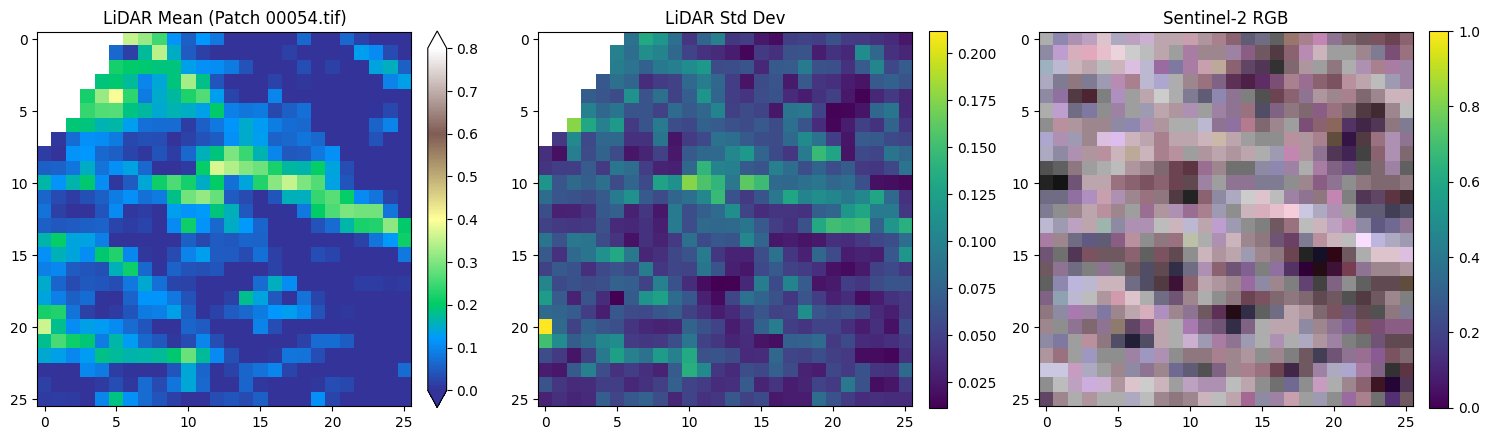

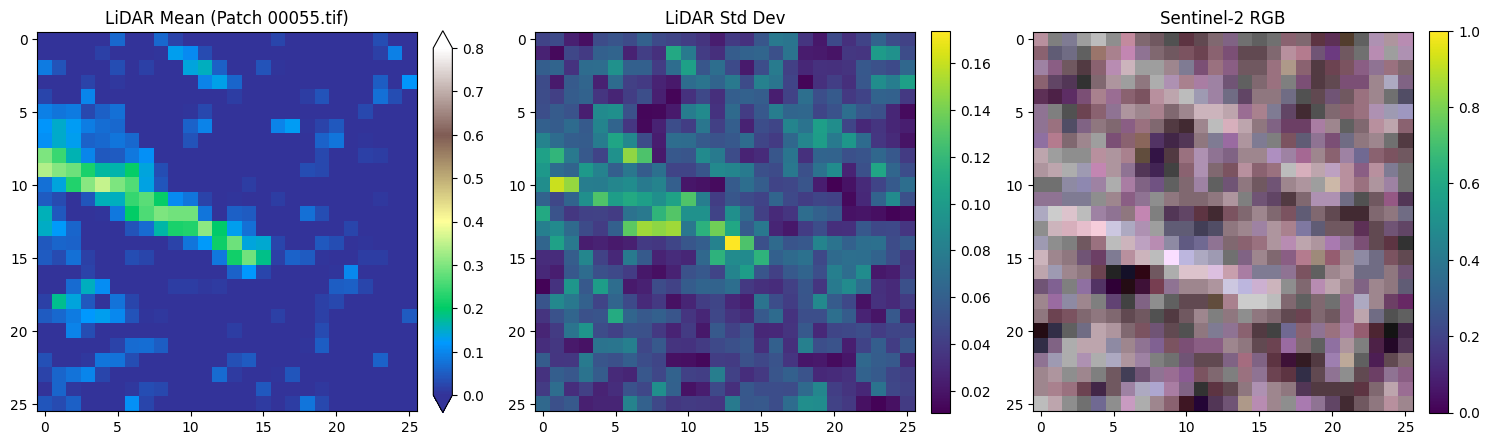

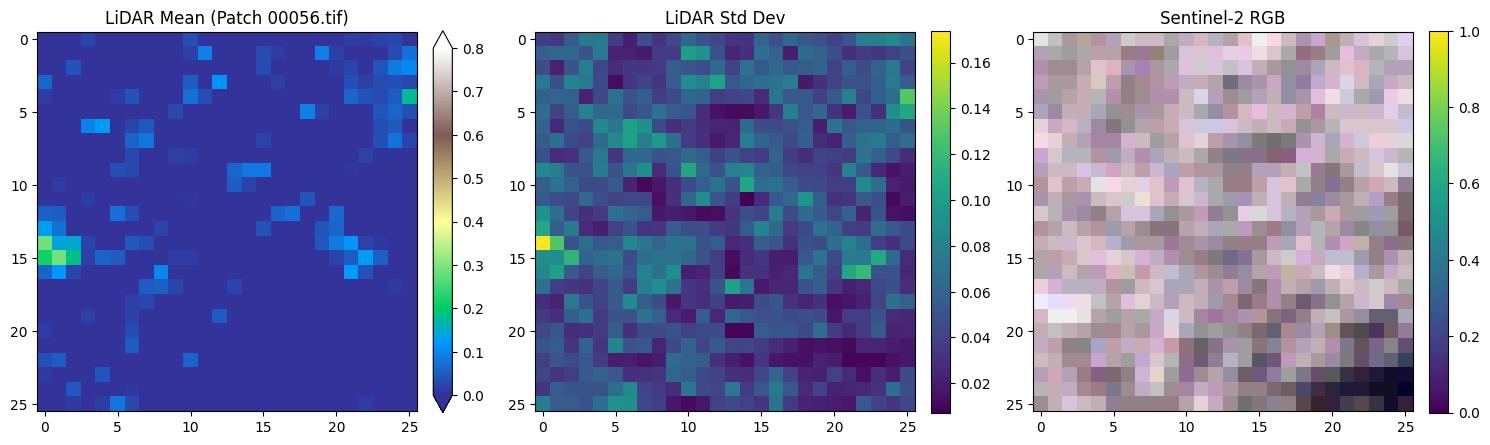

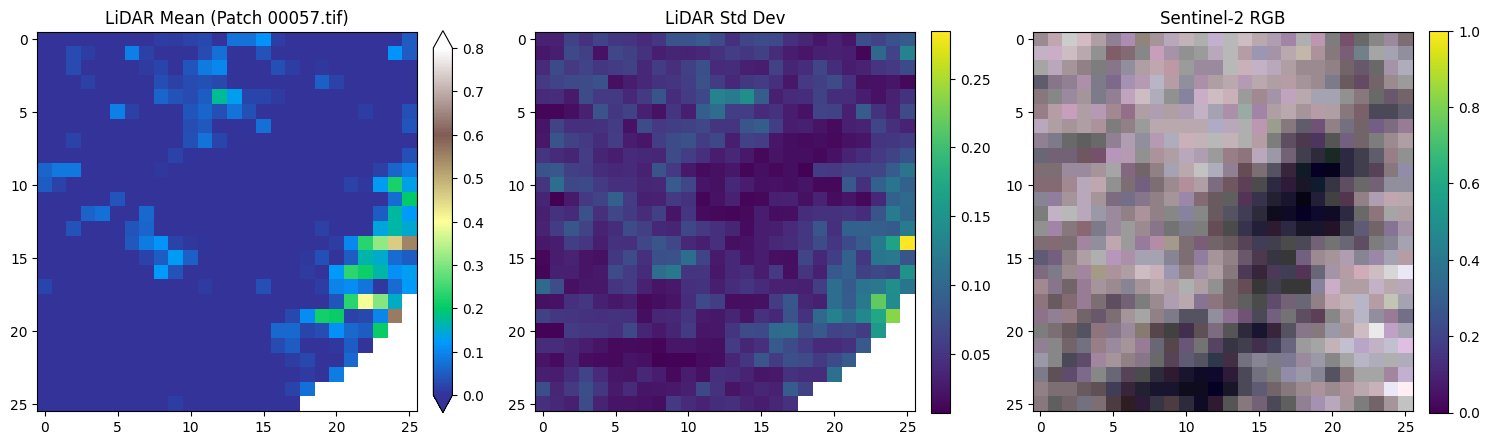

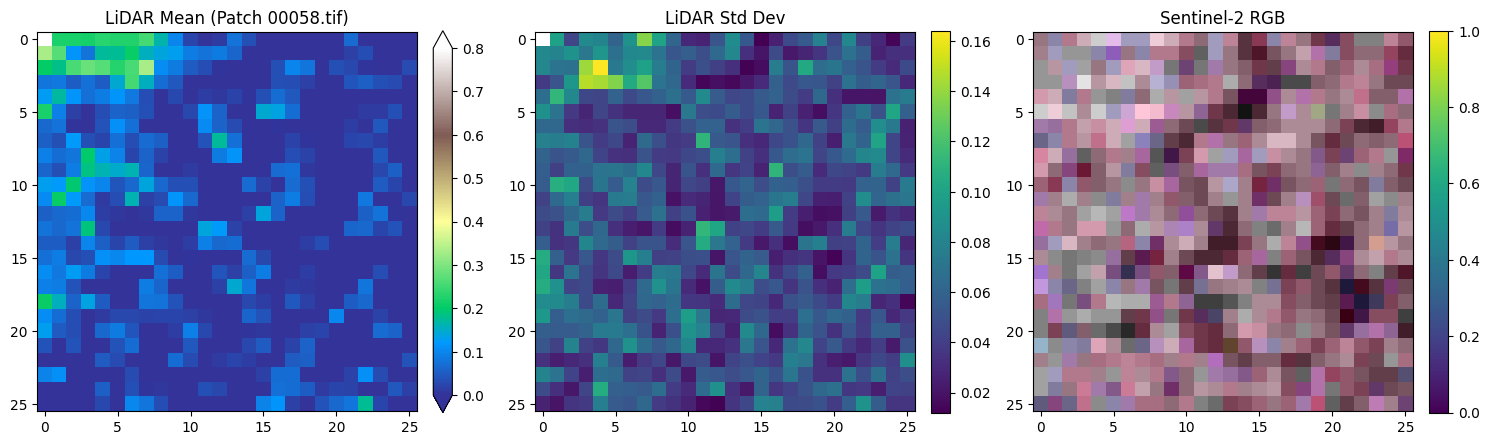

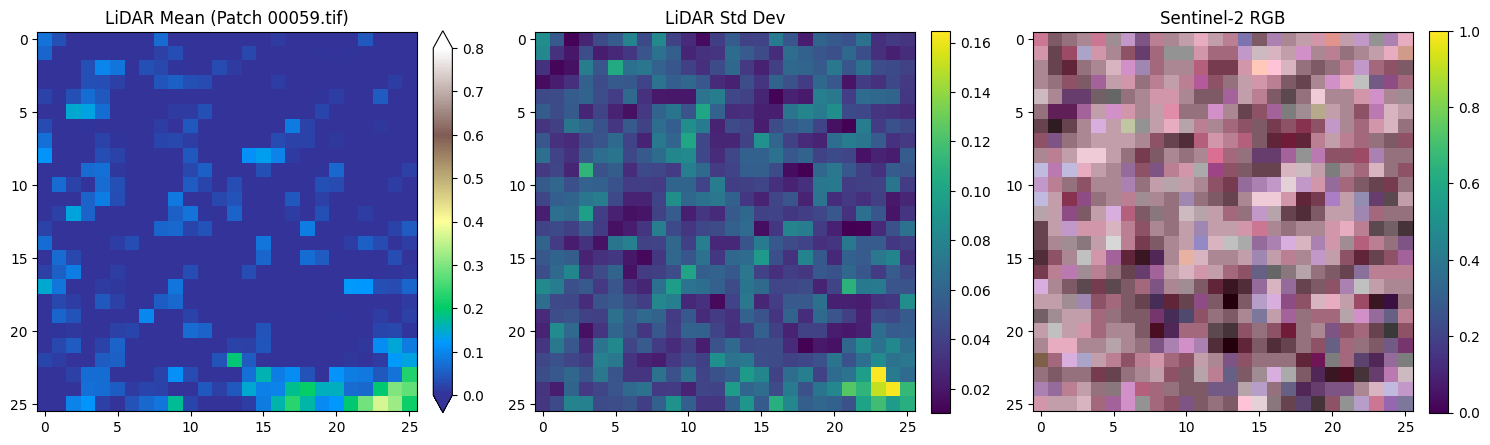

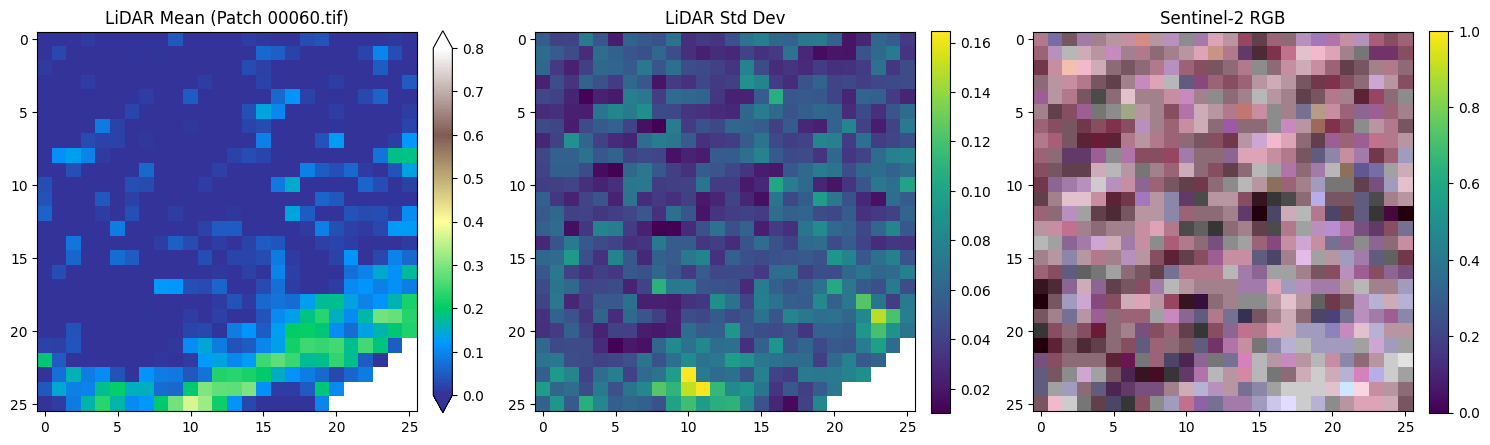

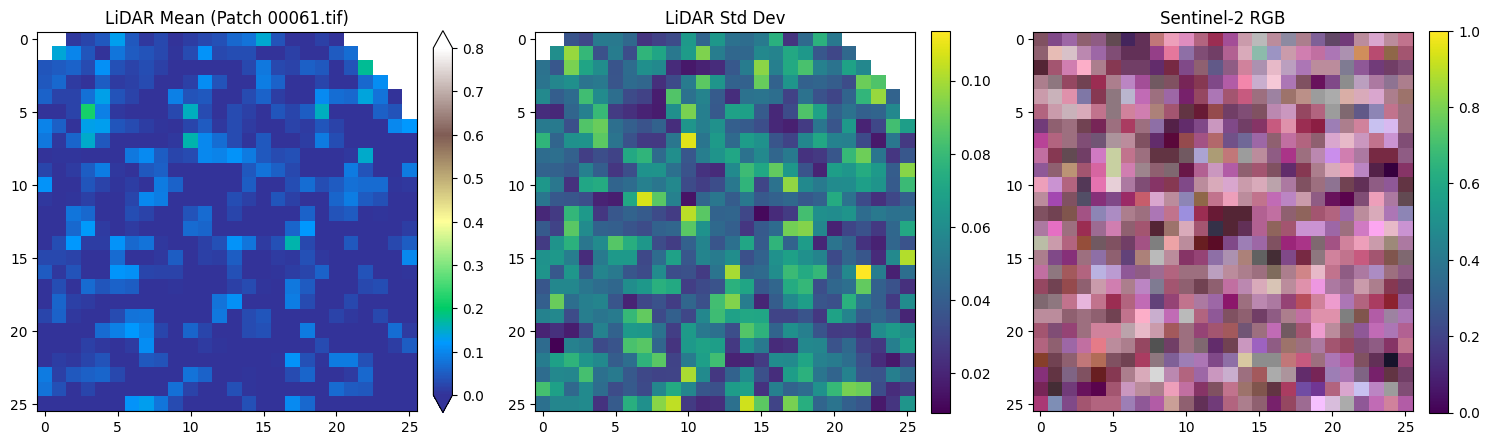

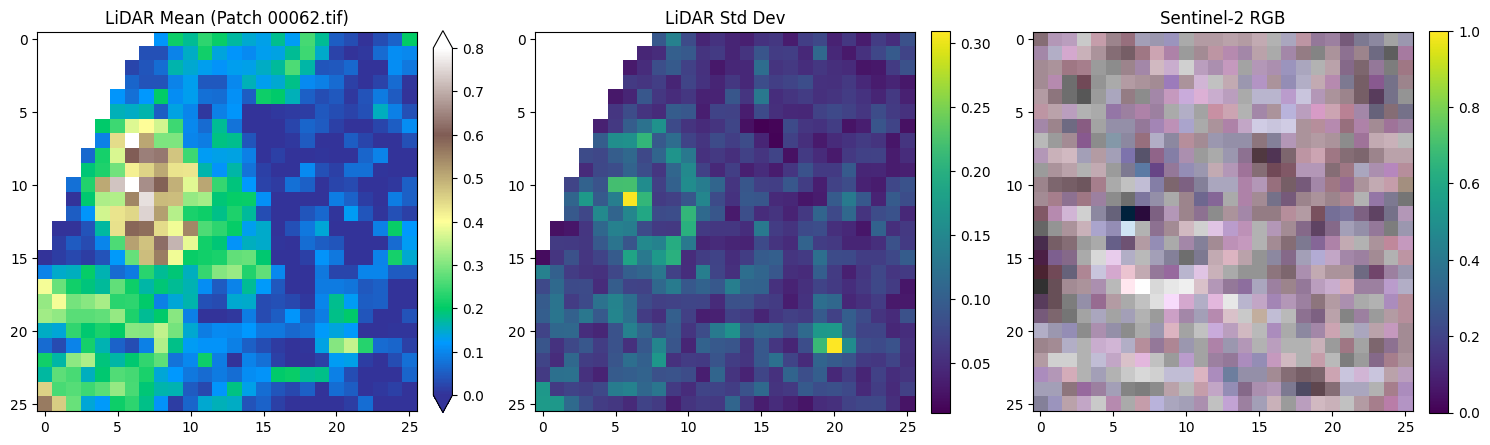

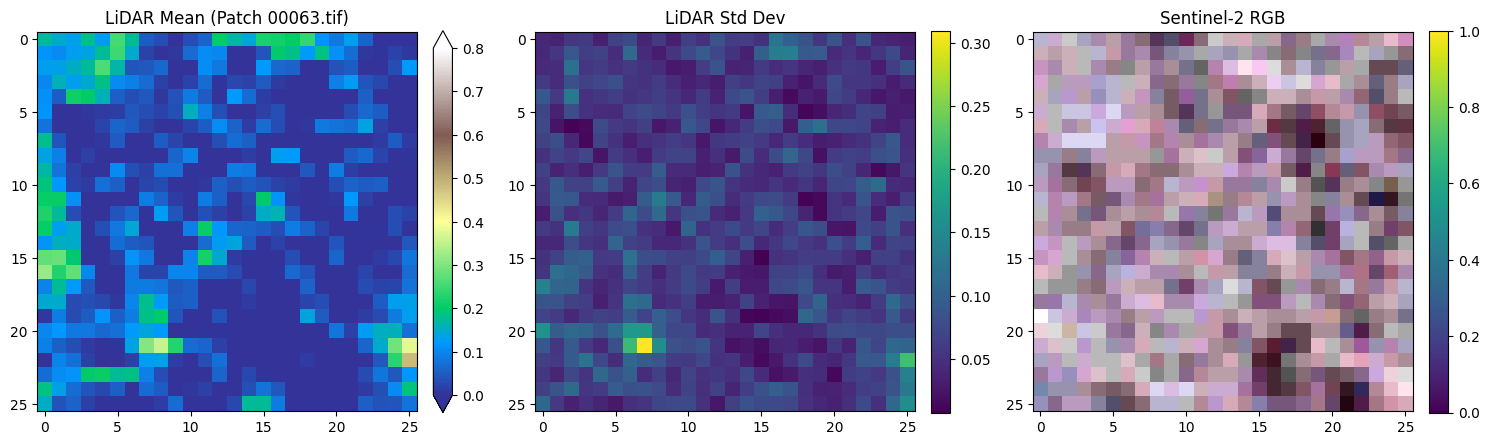

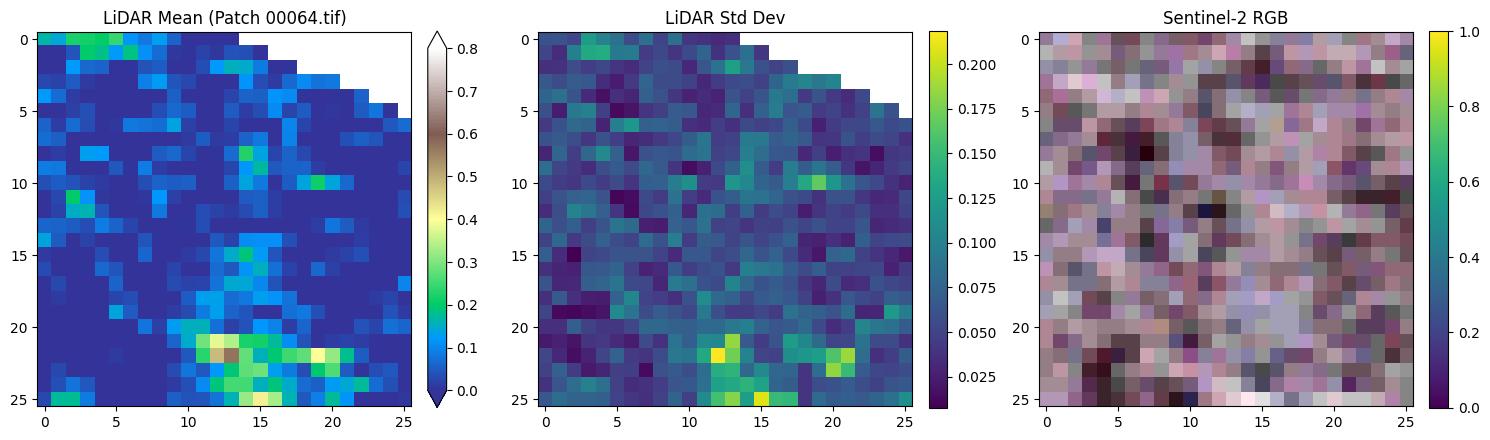

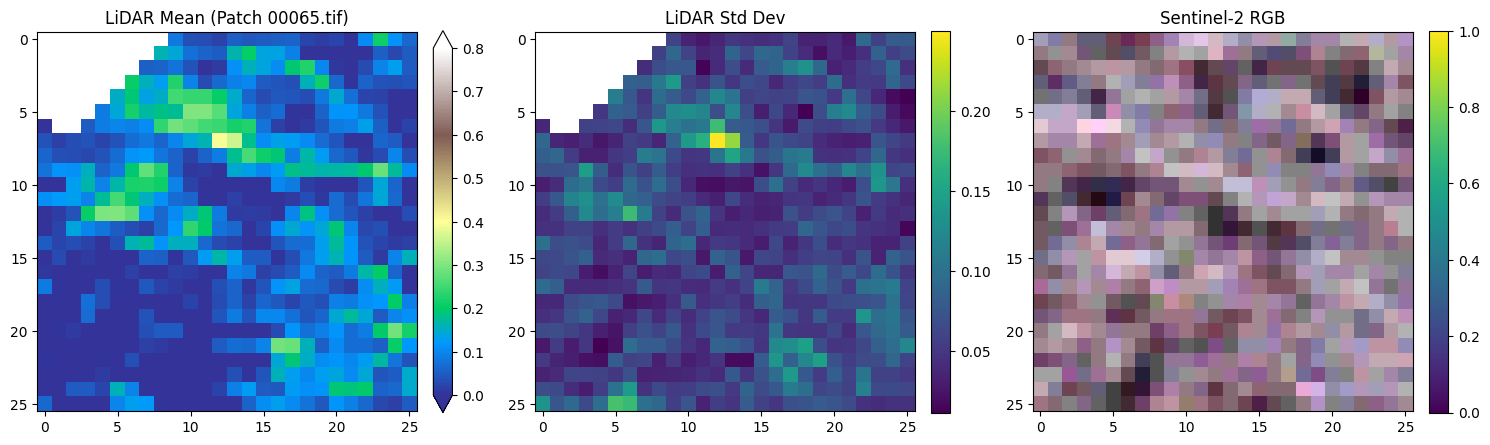

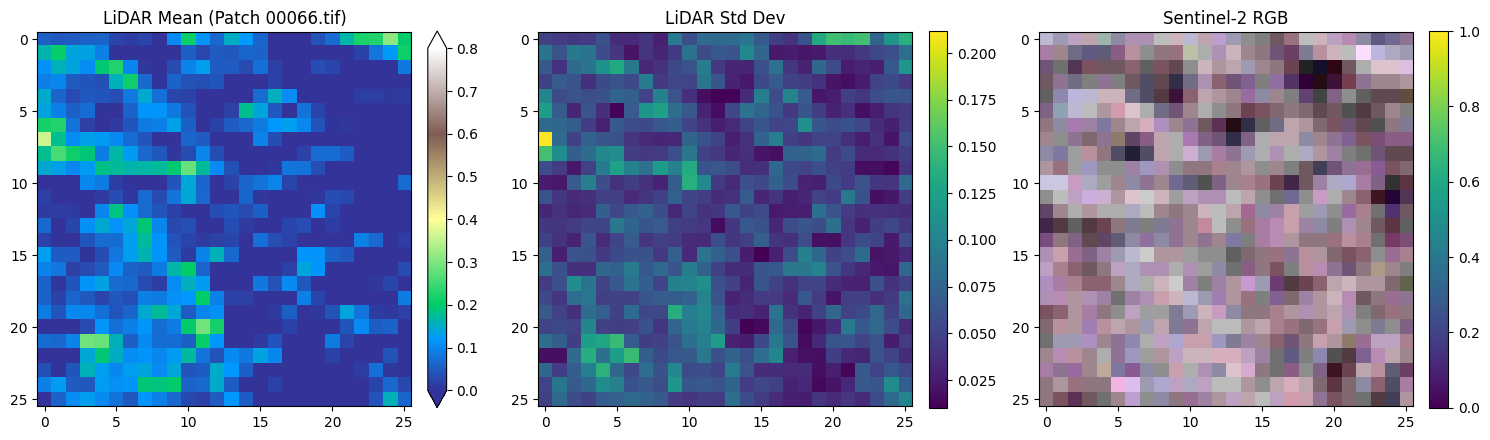

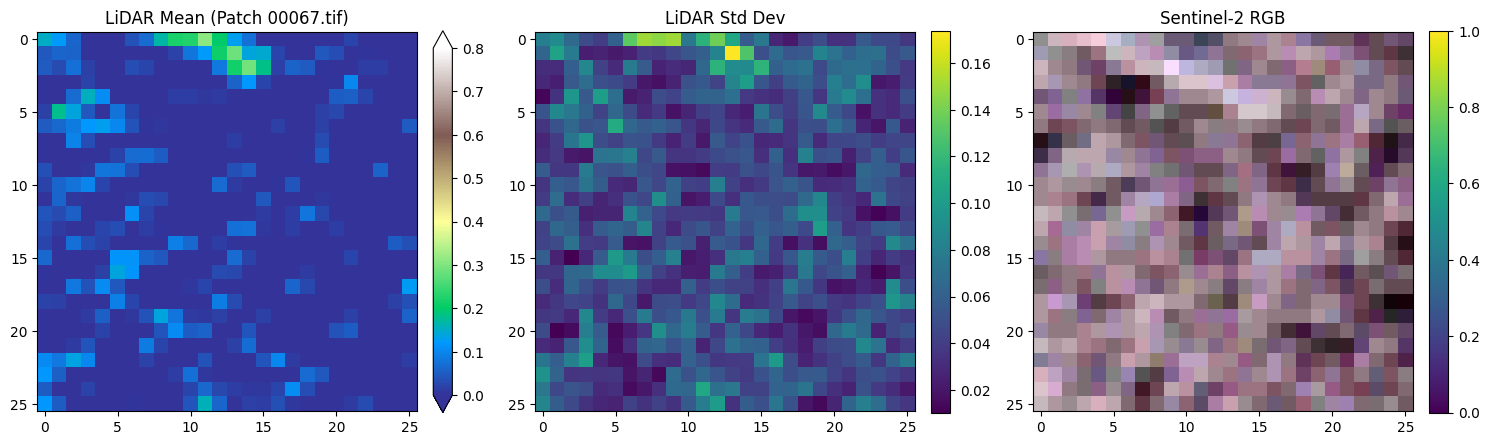

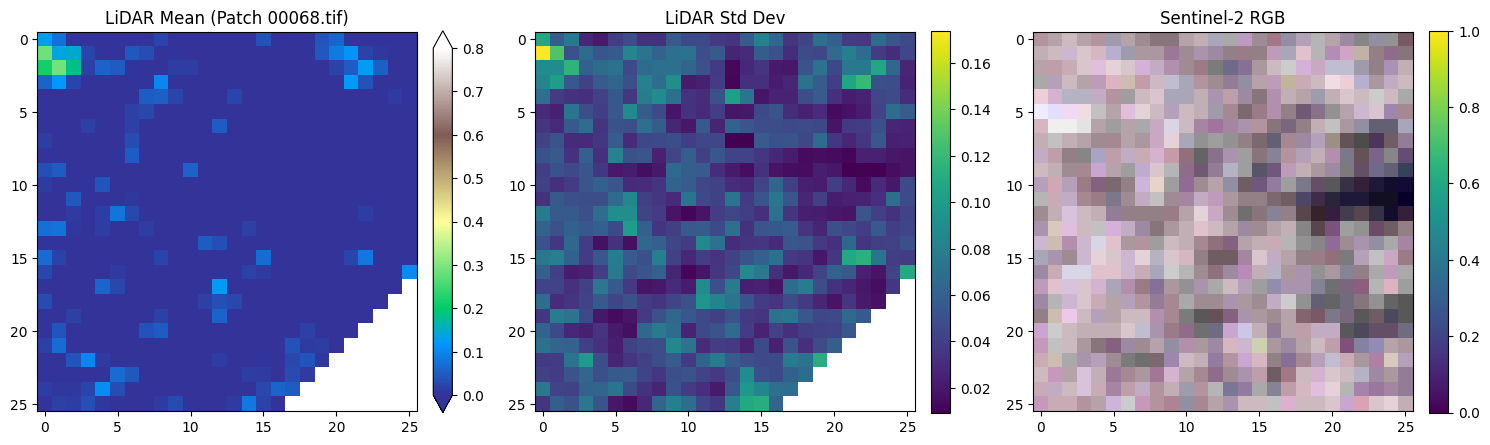

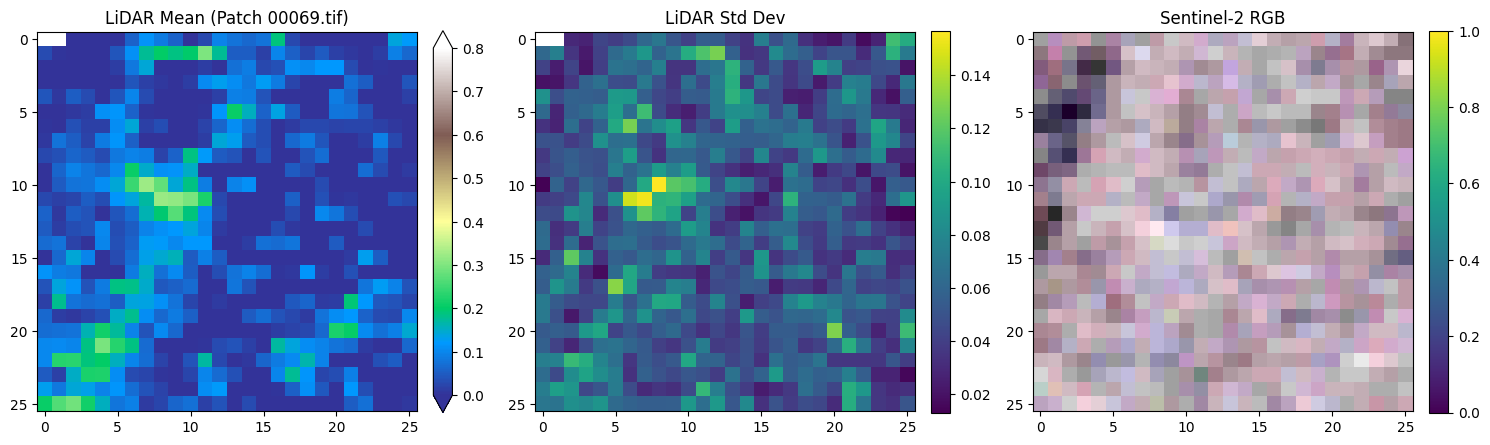

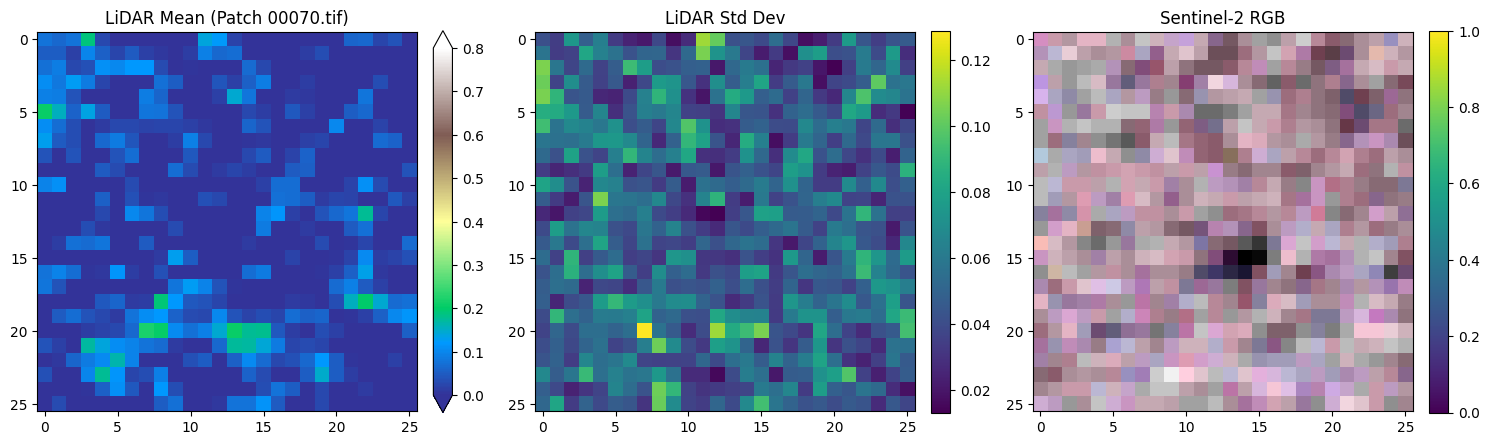

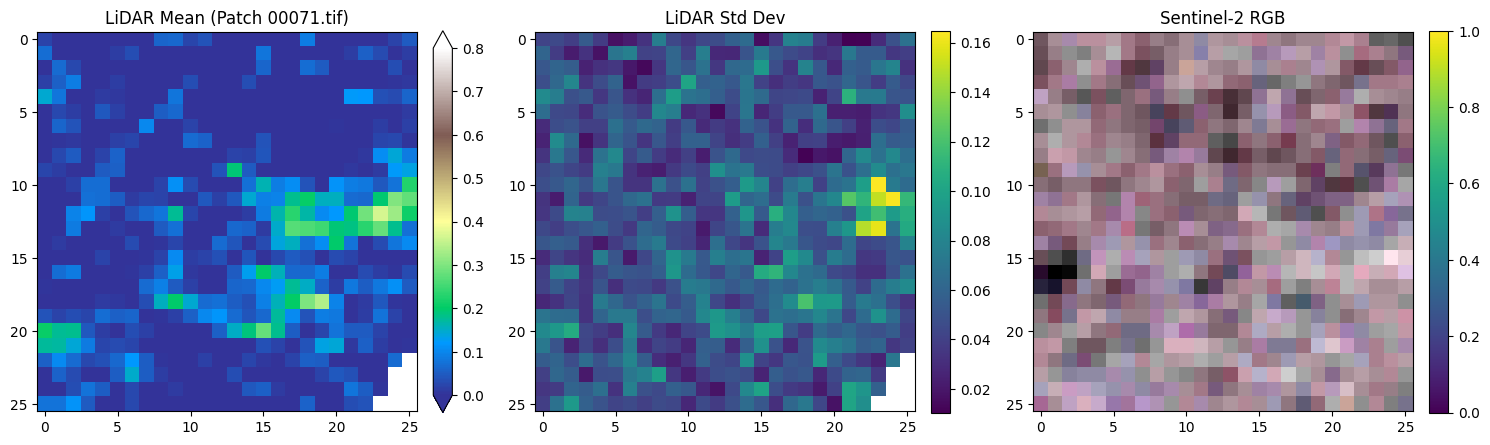

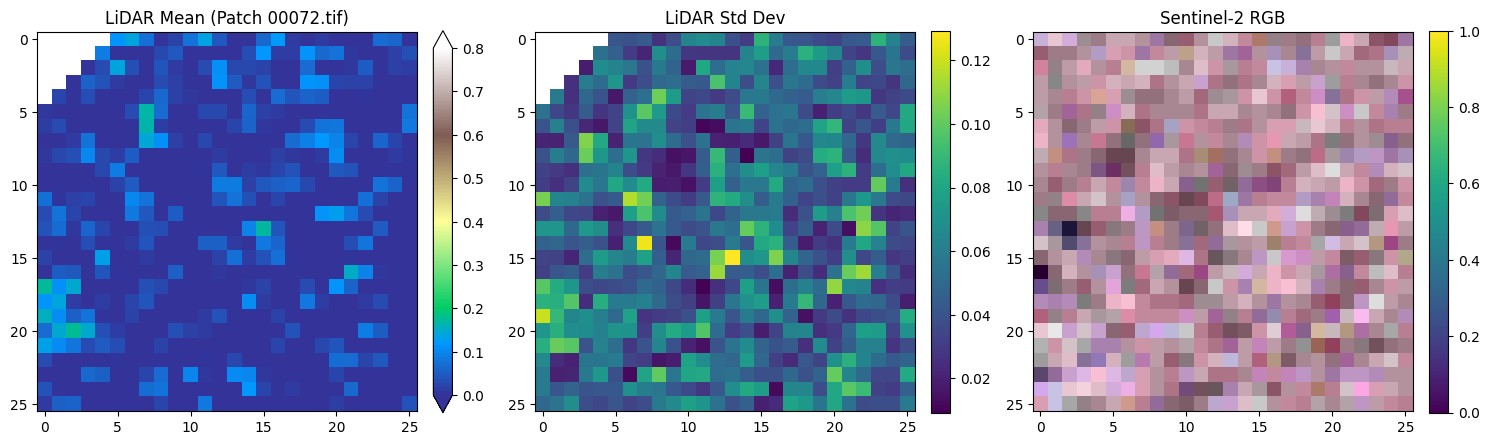

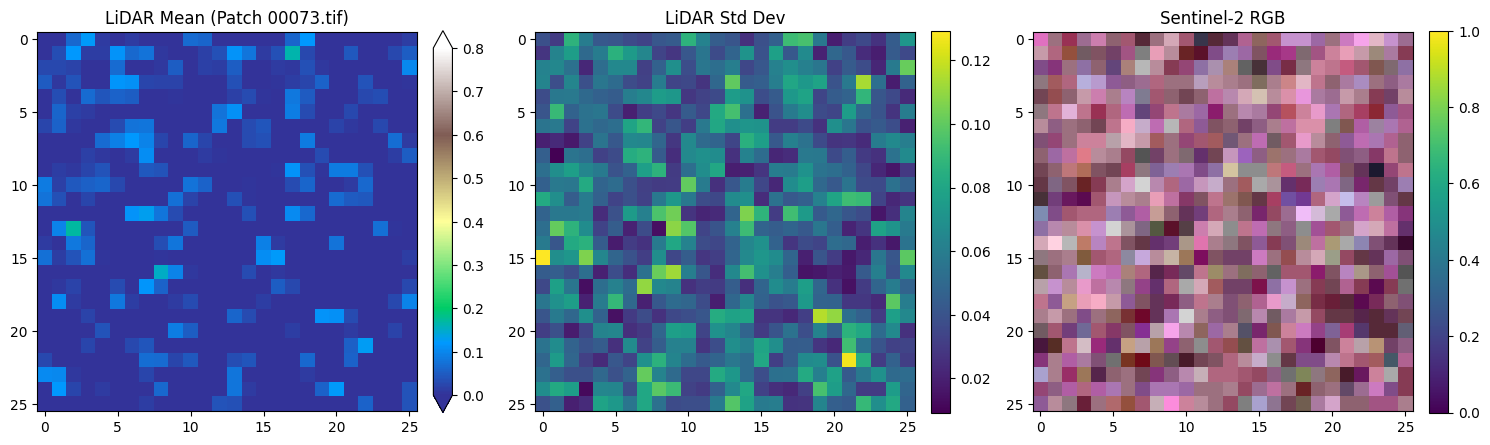

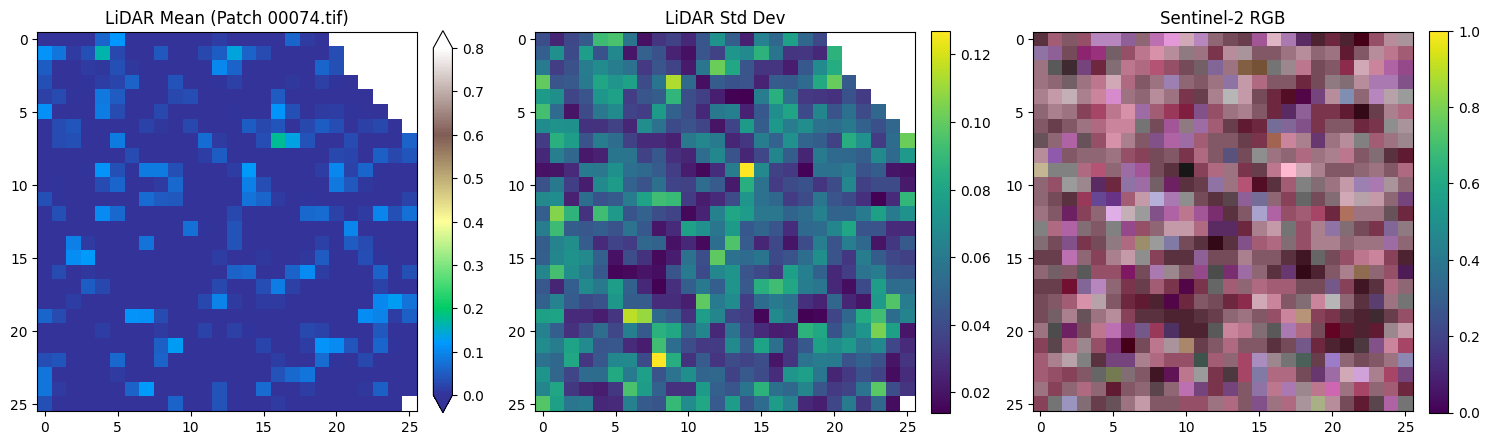

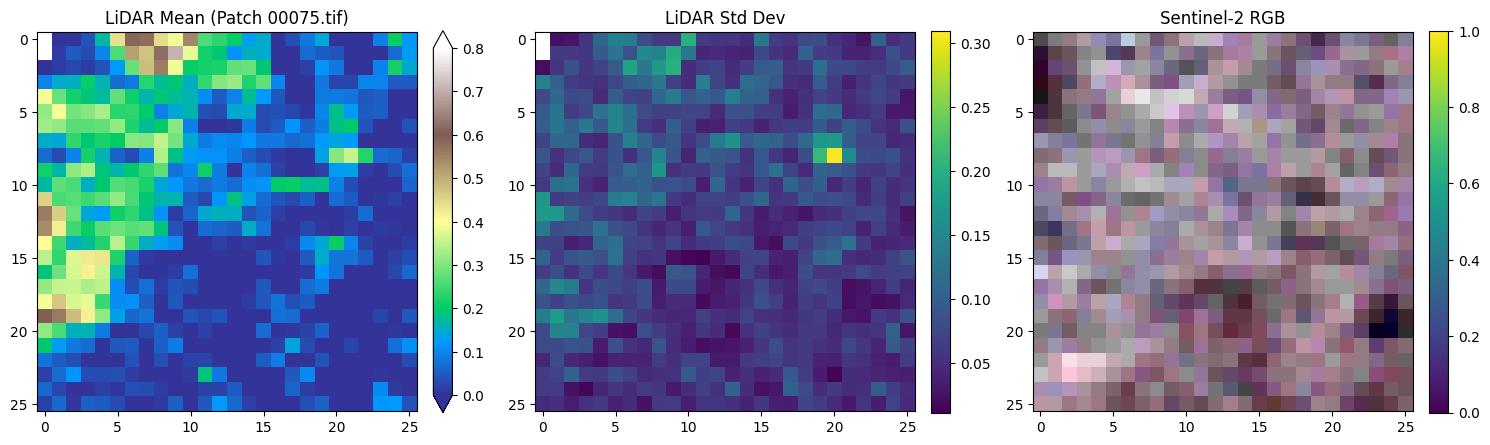

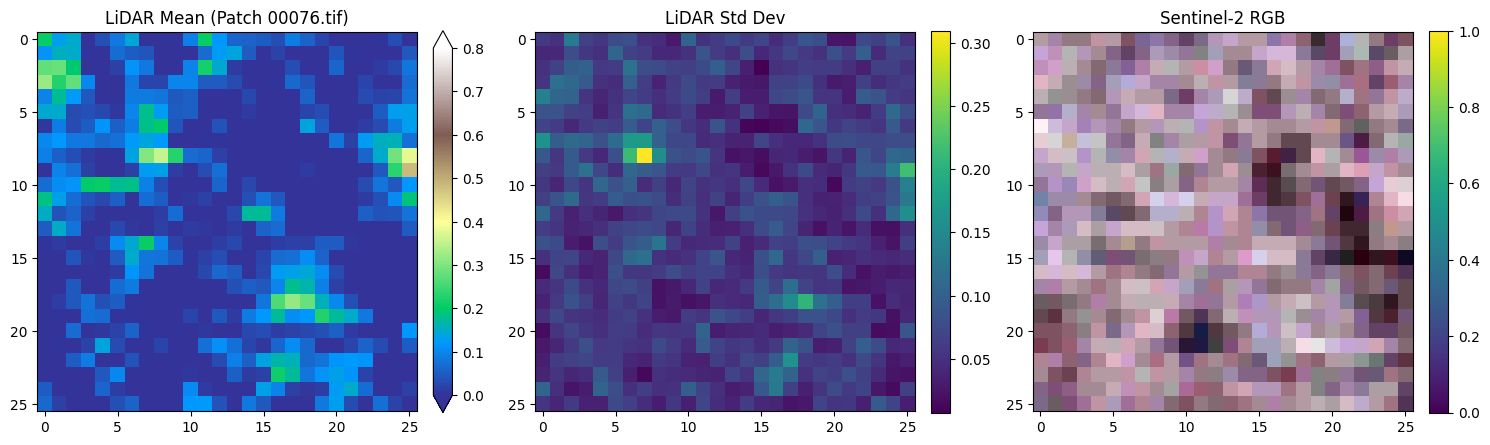

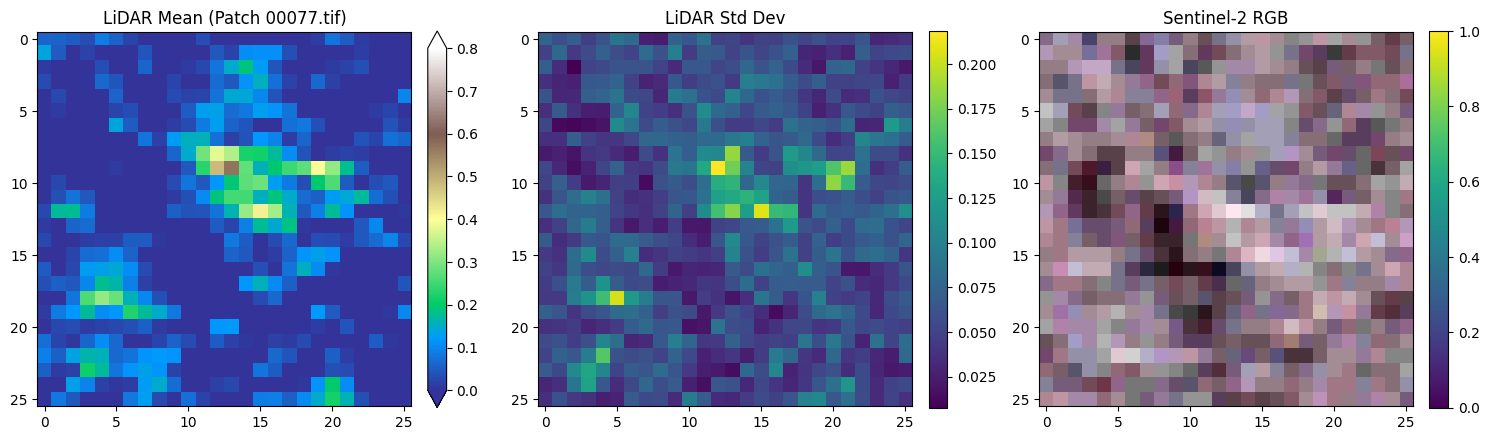

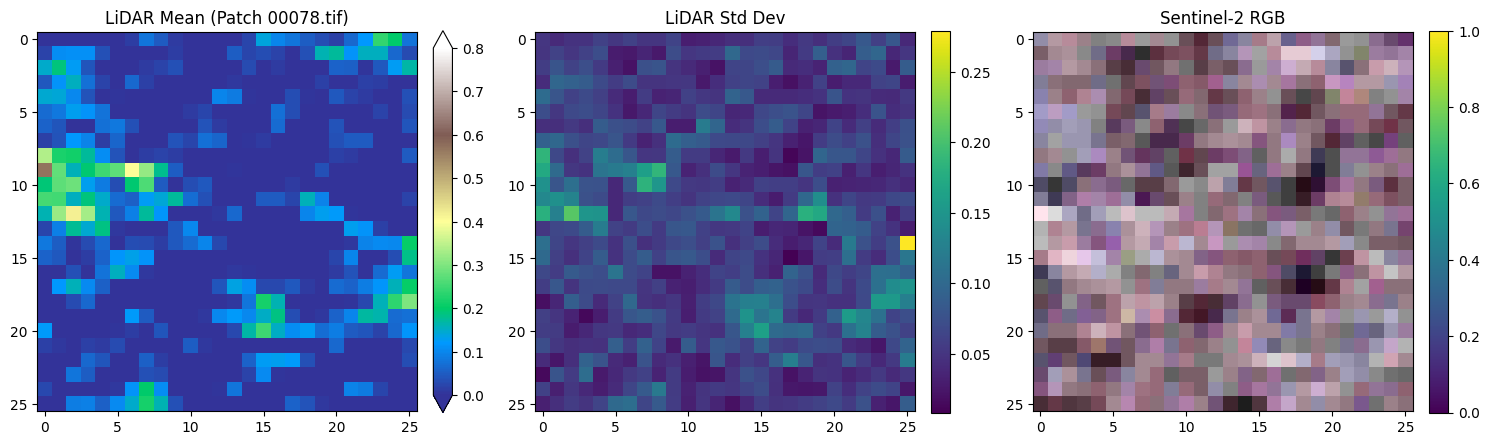

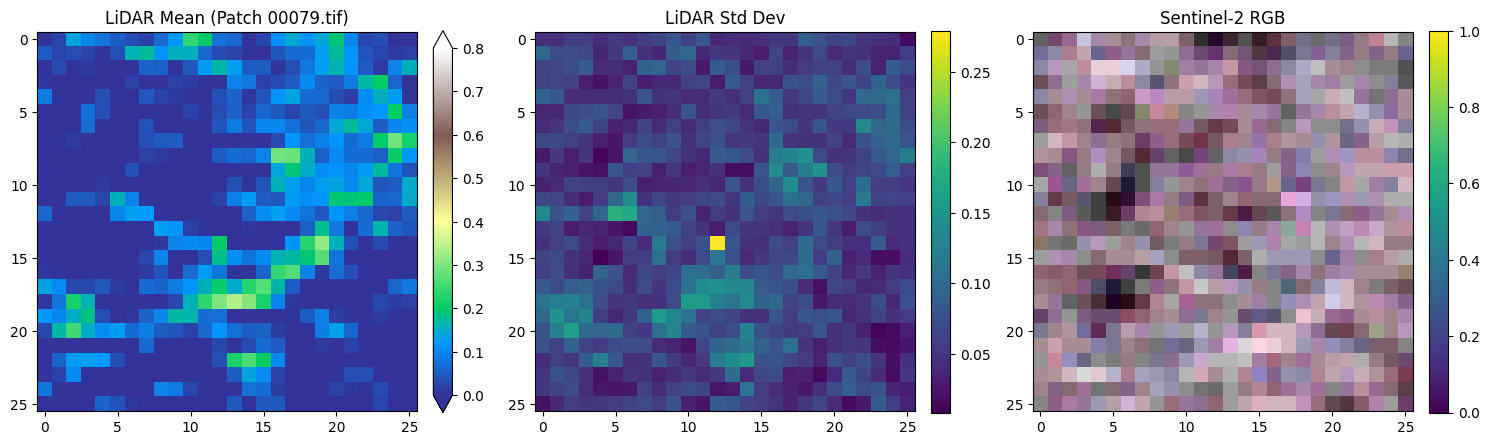

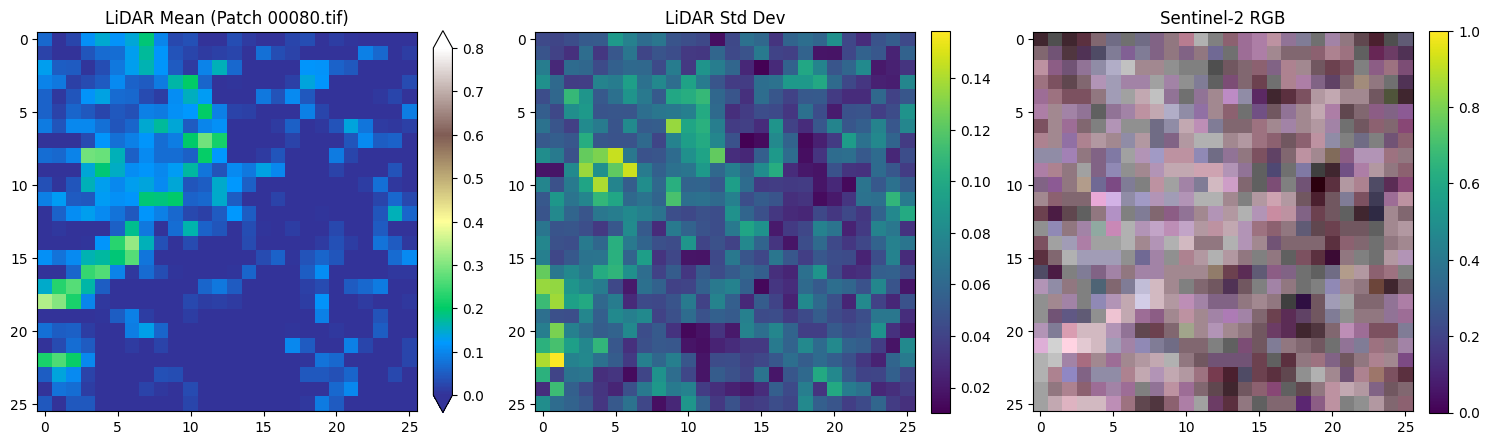

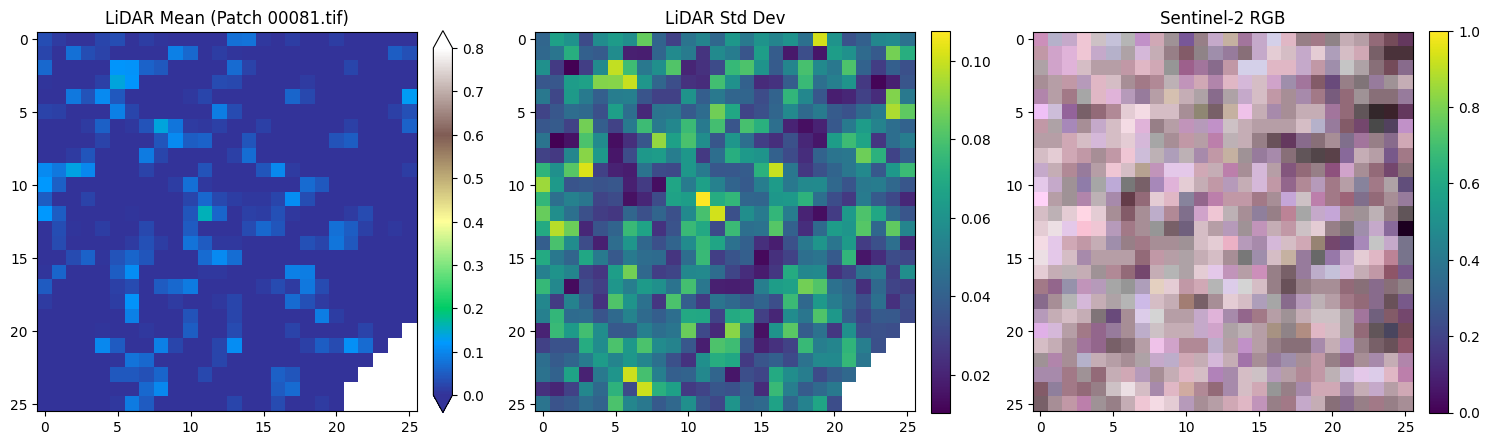

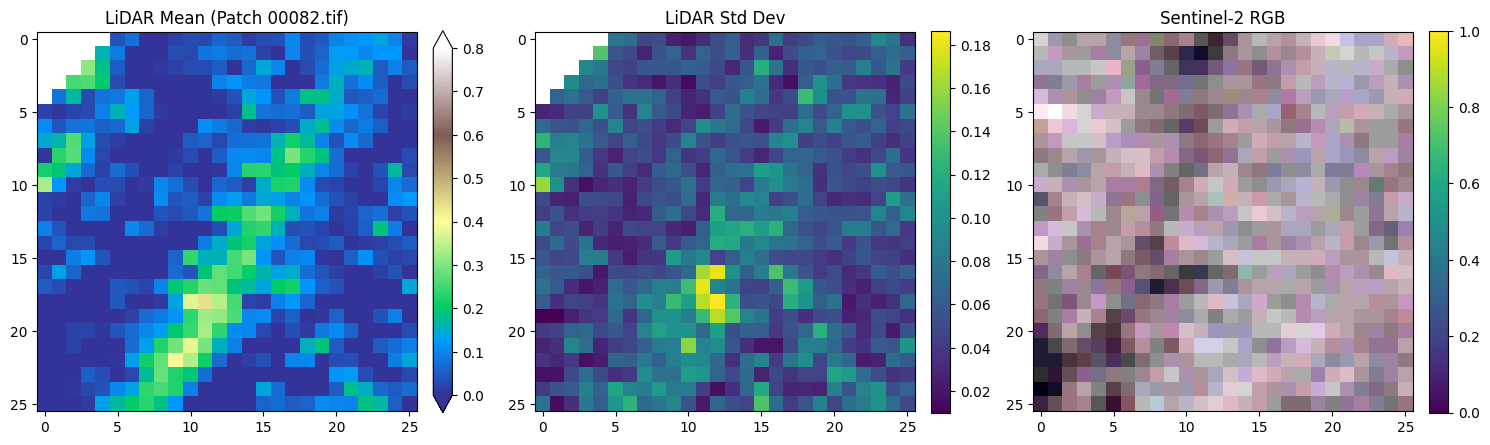

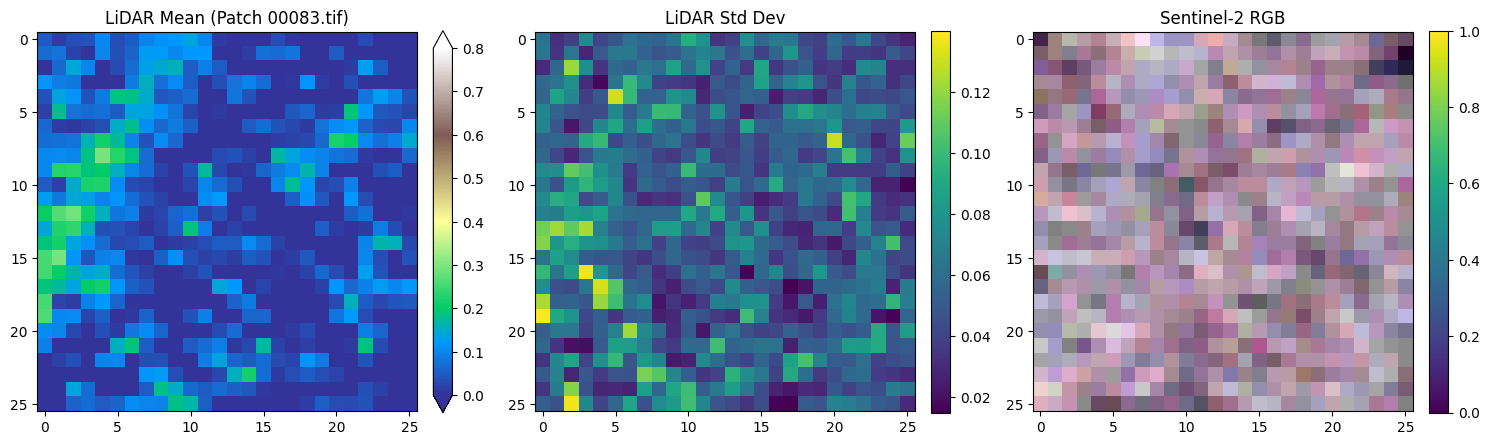

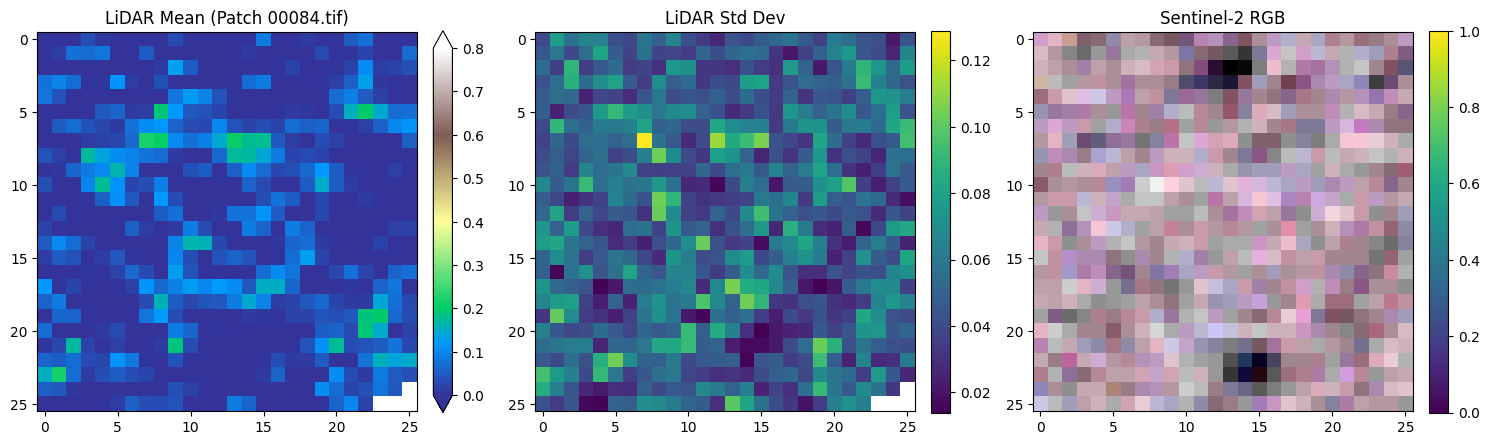

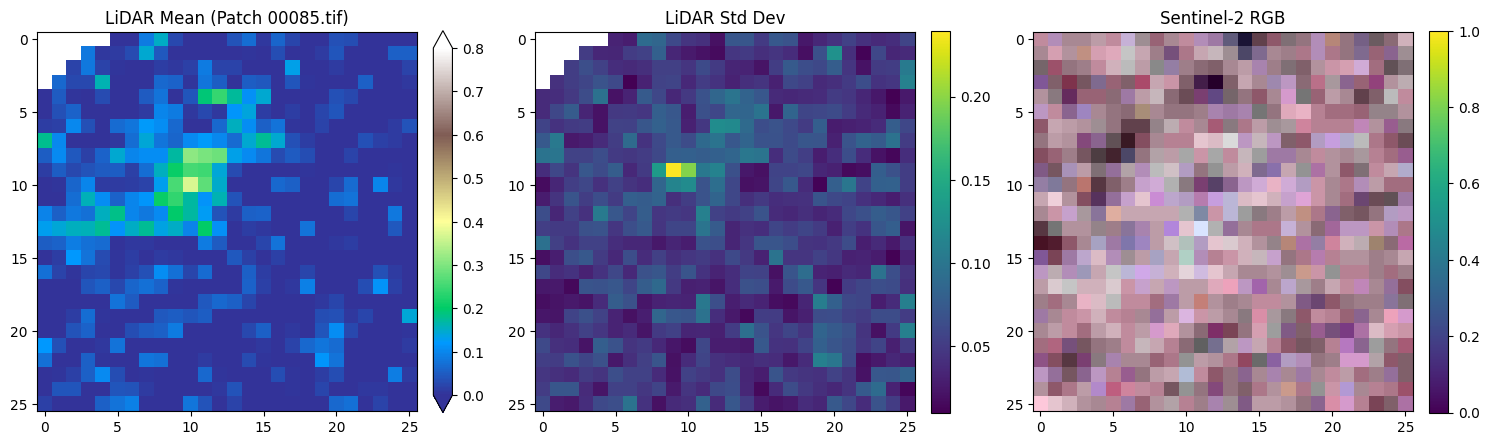

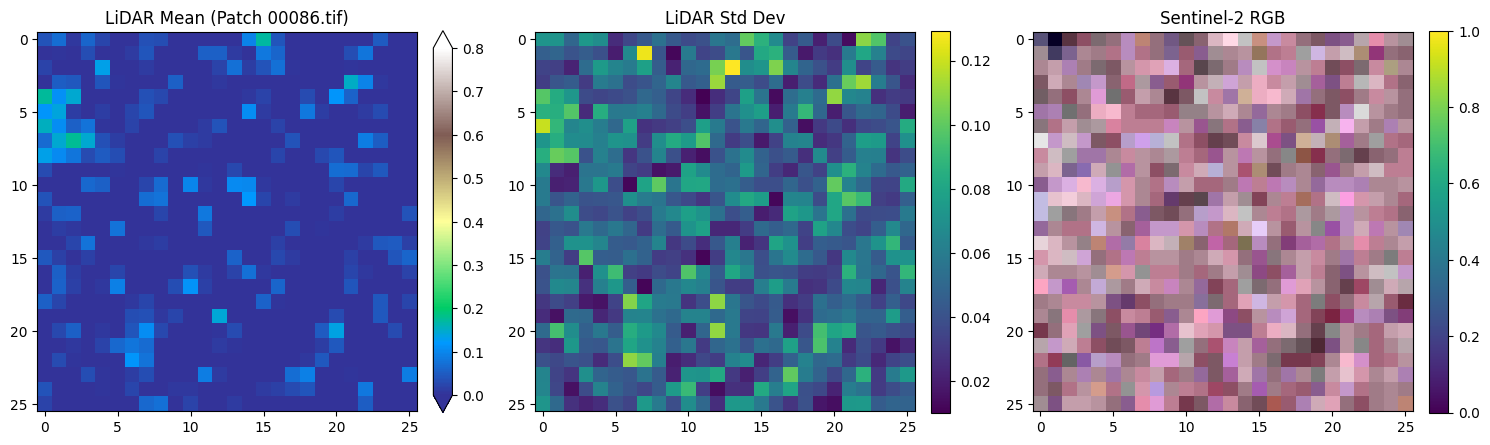

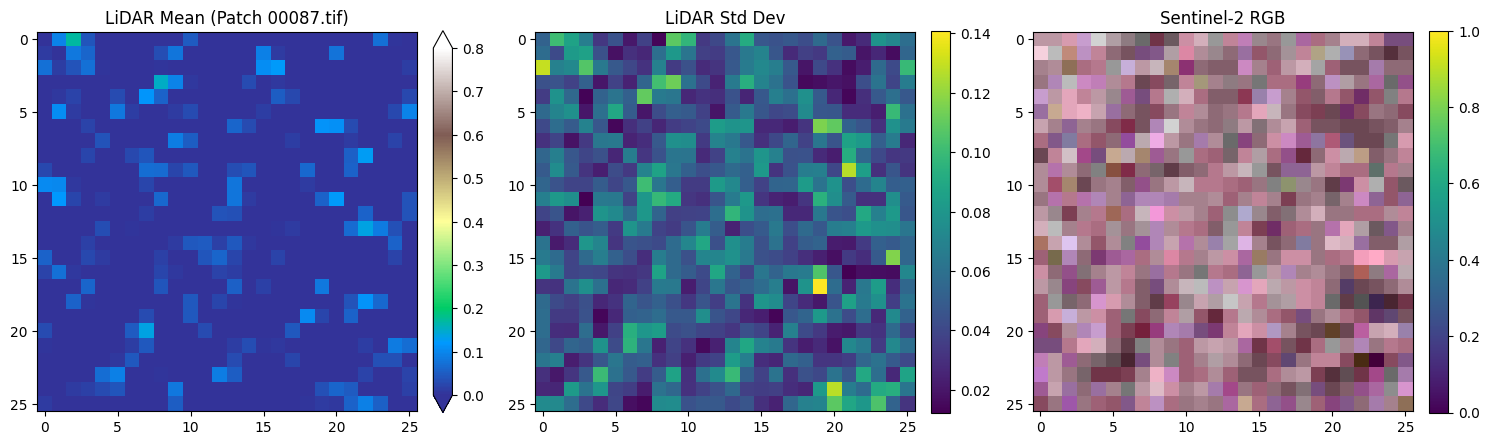

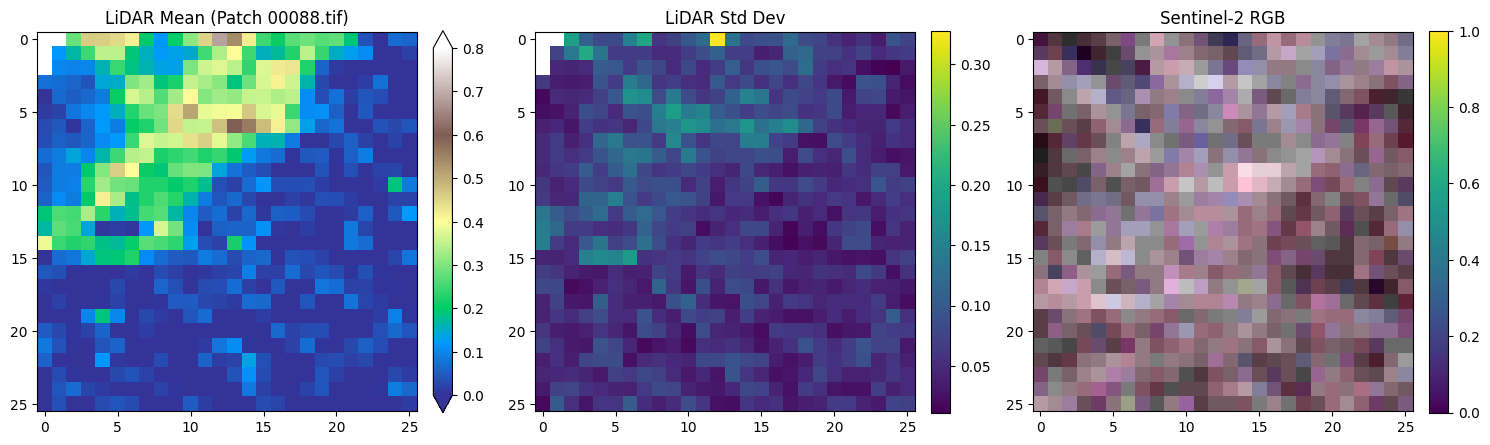

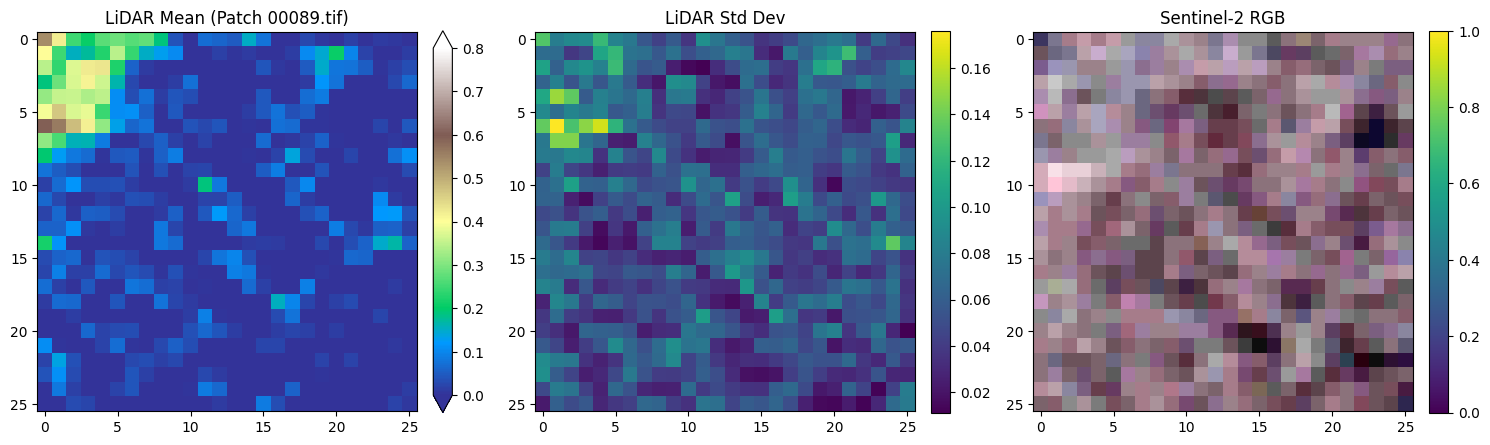

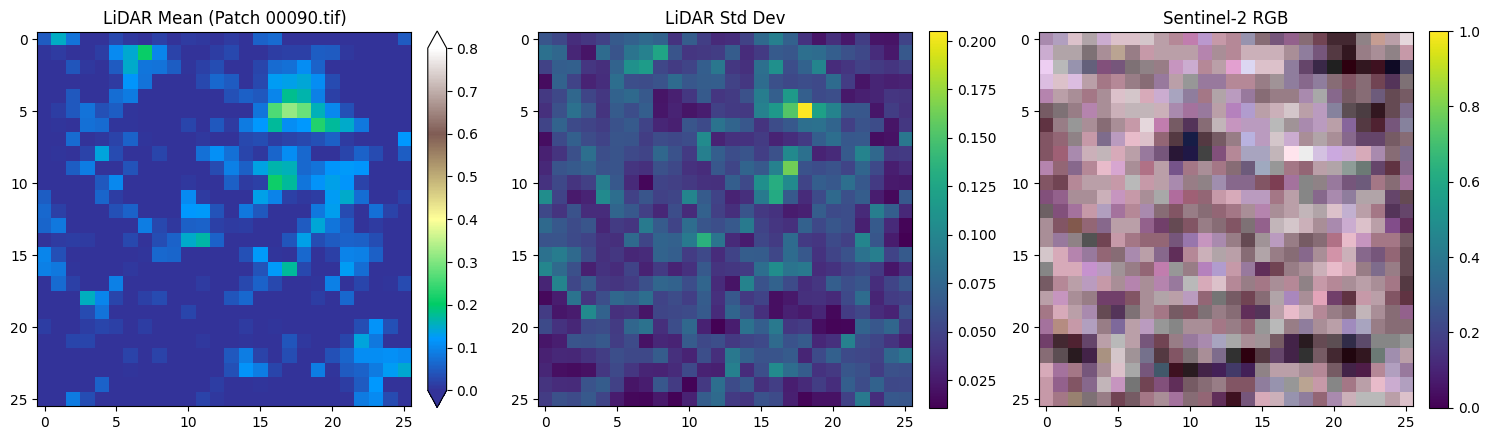

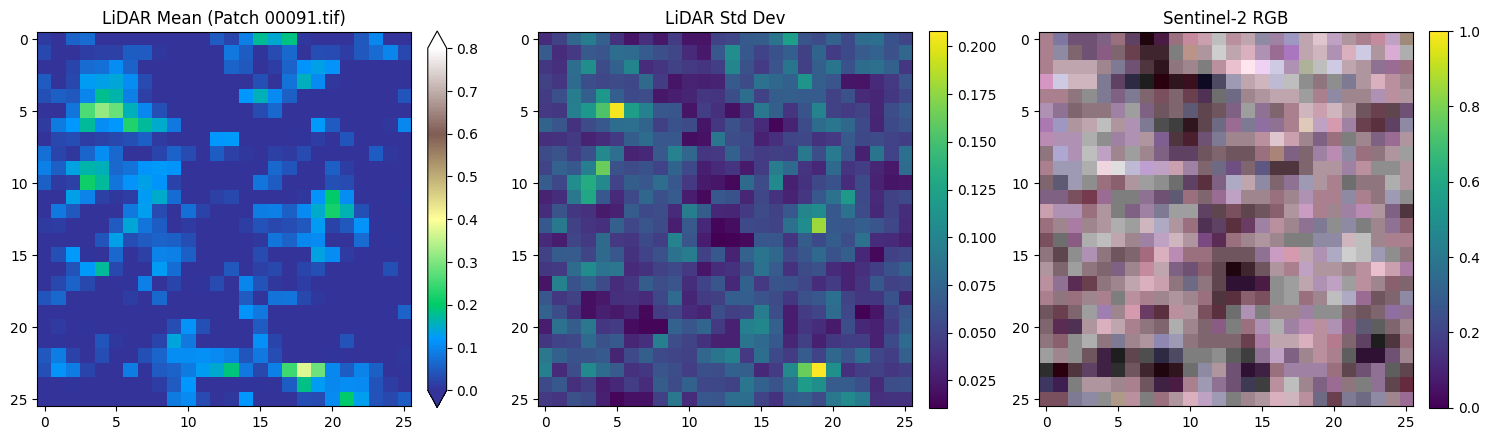

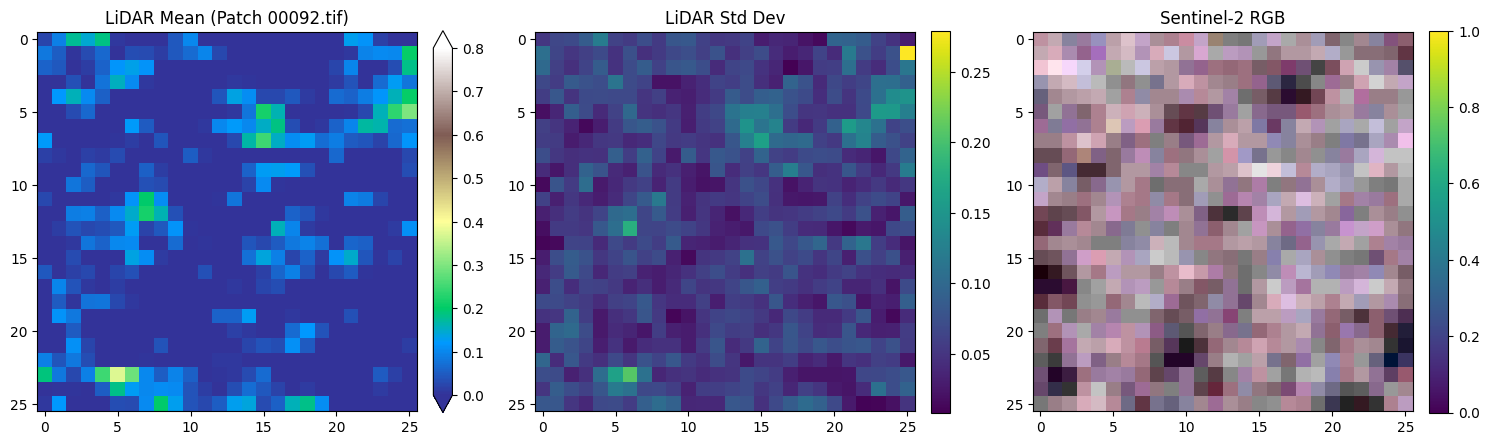

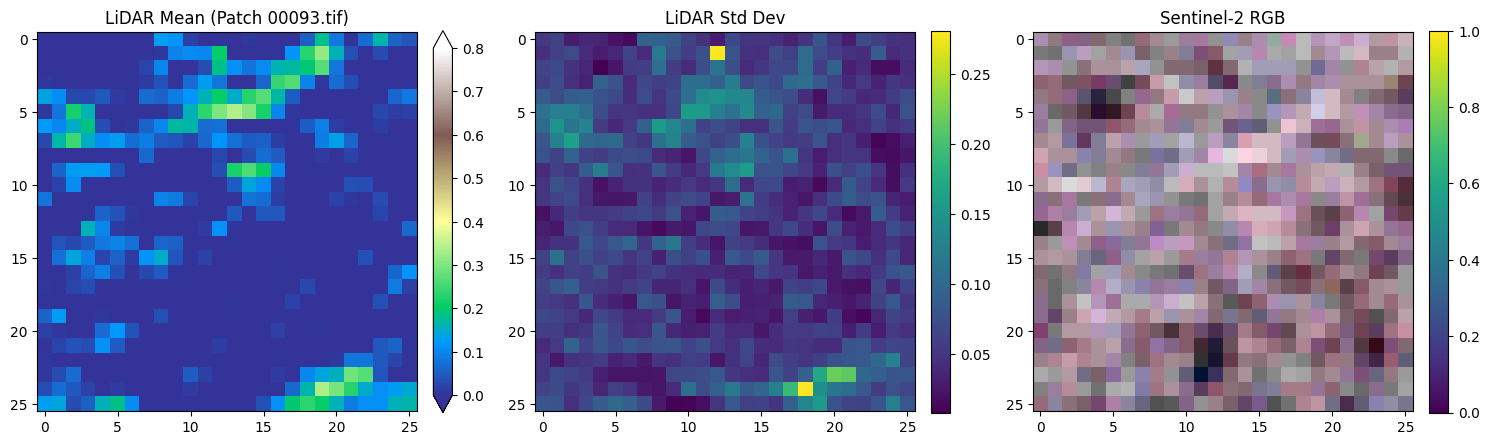

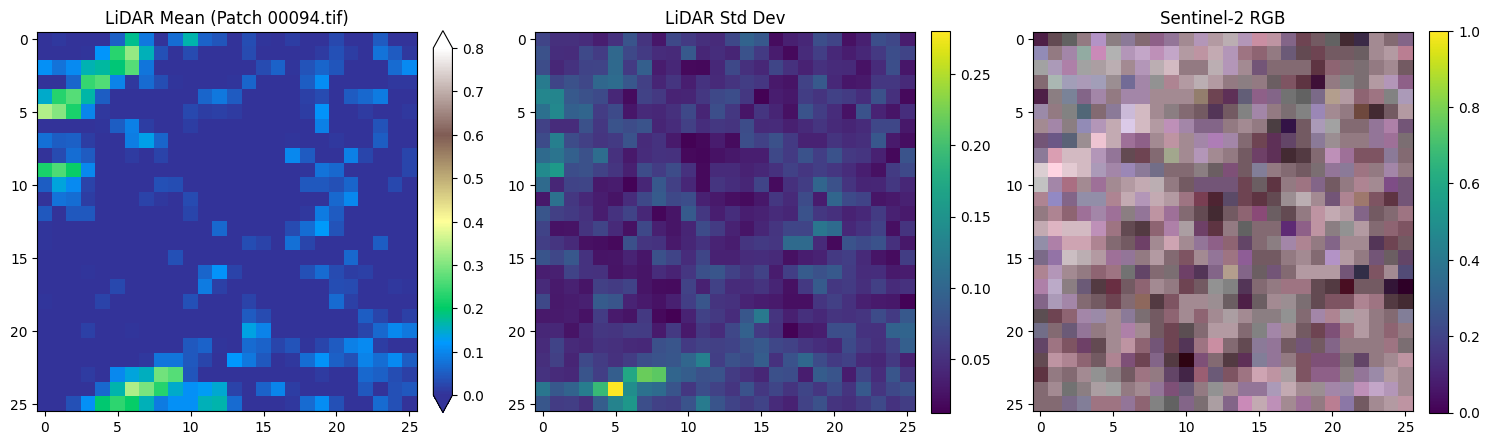

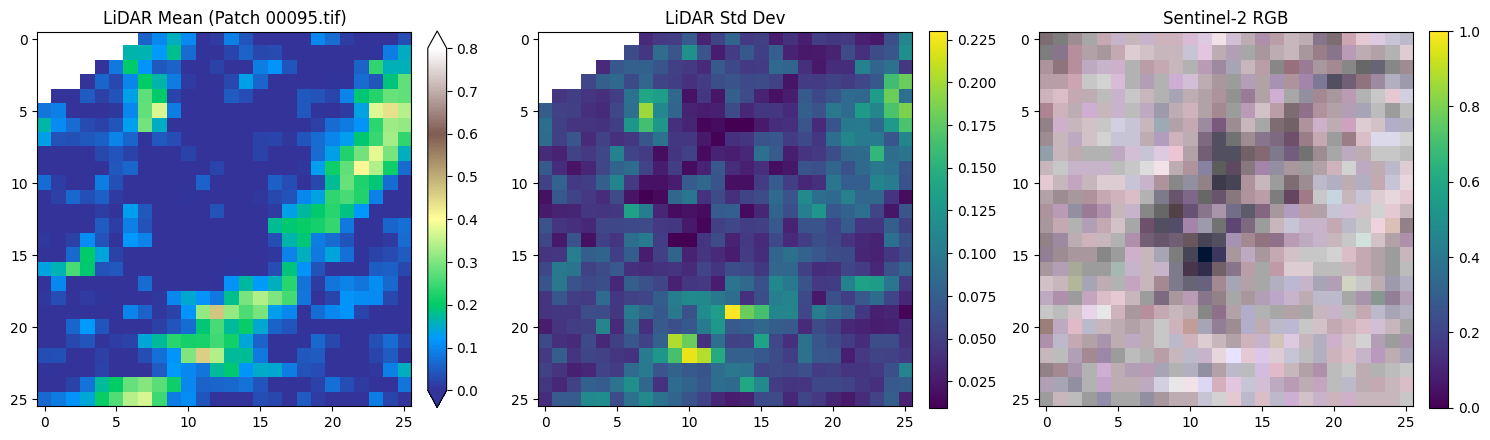

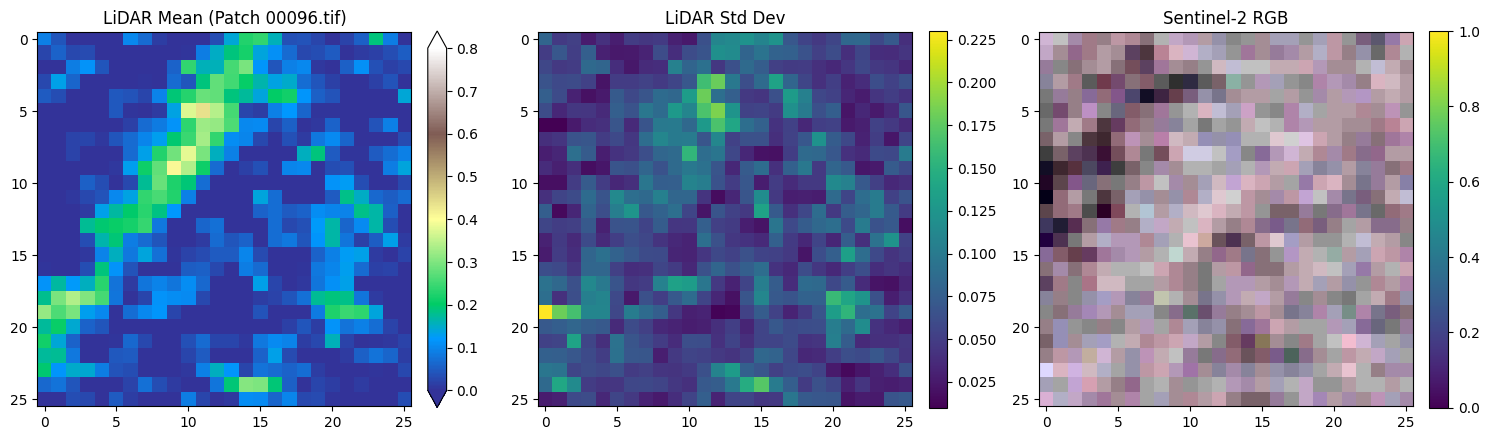

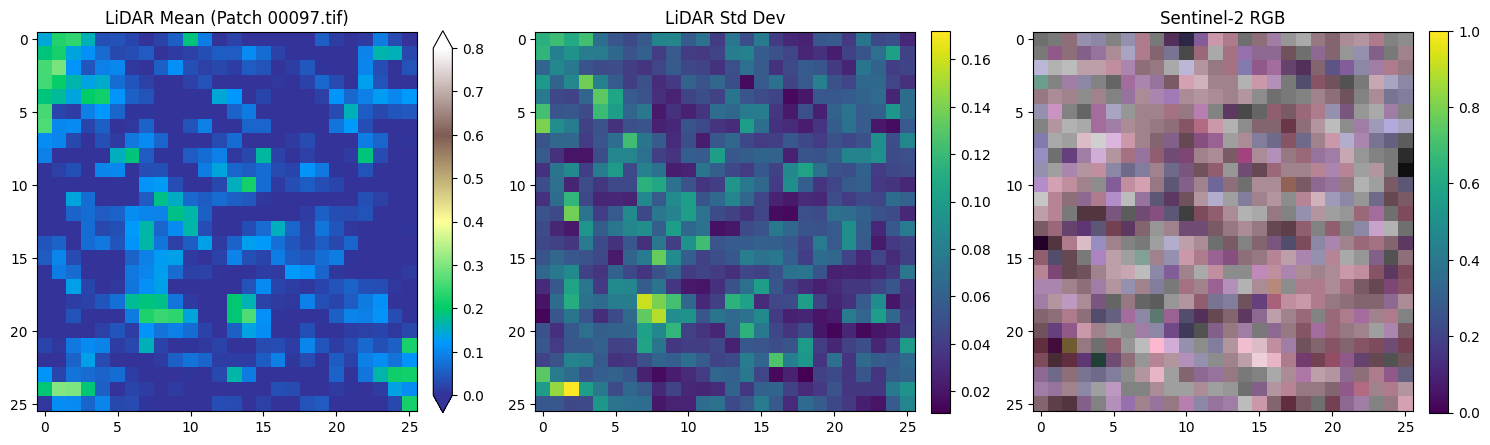

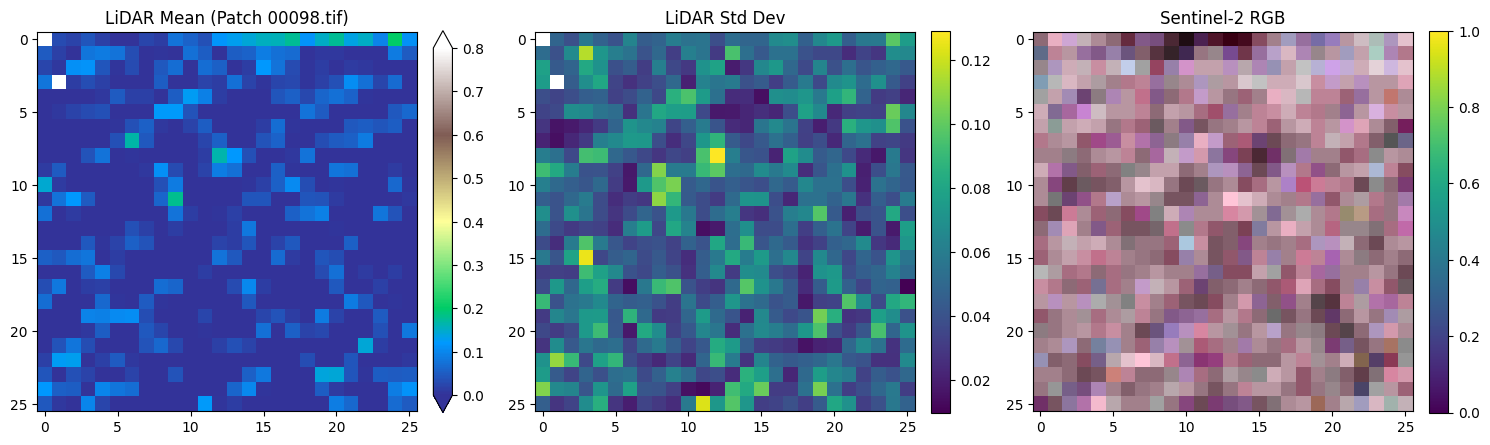

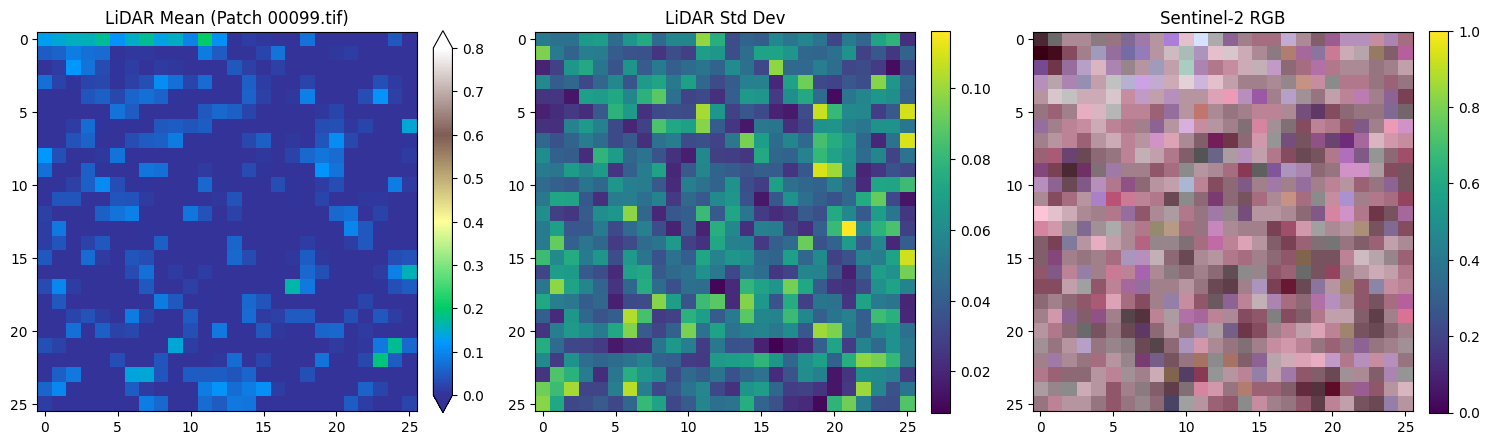

In [ ]:
sample_ids = sorted(glob(os.path.join(out_lidar_dir, "*.tif")))[0:100]

def normalize(img):
    return np.clip((img - np.min(img)) / (np.max(img) - np.min(img)), 0, 1)

for lidar_path in sample_ids:
    patch_id = os.path.basename(lidar_path).split("_")[-1]
    s2_path = os.path.join(out_s2_dir, f"s2_patch_{patch_id}")

    with rasterio.open(lidar_path) as src:
        lidar_mean = src.read(1)
        lidar_std = src.read(2)

    with rasterio.open(s2_path) as src:
        s2_rgb = src.read([1, 2, 3])

    lidar_mean = np.where(lidar_mean < 0, 0, lidar_mean)
    s2_rgb = np.moveaxis(s2_rgb, 0, -1)
    s2_rgb_norm = normalize(s2_rgb)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # LiDAR Mean
    im0 = axes[0].imshow(lidar_mean, cmap="terrain")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, extend='both')
    im0.set_clim(0, 0.8)
    axes[0].set_title(f"LiDAR Mean (Patch {patch_id})")

    # LiDAR Std
    im1 = axes[1].imshow(lidar_std, cmap="viridis")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].set_title("LiDAR Std Dev")

    # Sentinel-2 RGB
    axes[2].imshow(s2_rgb_norm)
    axes[2].set_title("Sentinel-2 RGB")
    plt.colorbar(axes[2].imshow(s2_rgb_norm), ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()